In [1]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from skimage.feature import hog
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

import pickle
import random
from collections import deque
import itertools

from utils import *

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pickle_filename =   "YCrCb0v0"

#pickle_filename =  "HLSALLv0"
#cutoff= 150

with open(pickle_filename, 'rb') as f:
        dataset = pickle.load(f)
        
svc = dataset["svc"]
orient = dataset["orient"]
pix_per_cell = dataset["pix_per_cell"]
cell_per_block = dataset["cell_per_block"]
spatial_size = dataset["spatial_size"]
hist_bins = dataset["hist_bins"]
hog_channel = dataset["hog_channel"]
cspace= dataset["cspace"]
cutoff=dataset["cutoff"]

In [3]:
print('orient : %d' % orient)
print('pix_per_cell : %s' % pix_per_cell)
print('cell_per_block : %s' %  cell_per_block)
print('spatial_size : %s' %  str(spatial_size))
print('hist_bins : %d' %  hist_bins)
print('svc : %s' %  svc)
print('hog_channel : %s' %  hog_channel)
print('cspace : %s' %  cspace)
print('cutoff : %s' %  cutoff)

orient : 12
pix_per_cell : 8
cell_per_block : 2
spatial_size : (32, 32)
hist_bins : 32
svc : LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
hog_channel : 0
cspace : YCrCb
cutoff : 15


http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

In [4]:
"""
pyramid = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
           ((192, 192),[450, None]),
#             ((256, 256),[450, None])
      ]

image_size = (720, 1280)
windows = create_windows(pyramid, image_size)
"""

pyramid = [
            ((42, 42),  [400, 500]),
           ((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
#           ((192, 192),[450, None]),
#             ((256, 256),[450, None])
      ]

image_size = (720, 1280)
windows = create_windows(pyramid, image_size,xy_overlap=(0.5, 0.75))

#print(windows)

In [5]:
heat_box = []
box_threshold = 1
sum_array_threshold = 0
labeled_image = []

d = deque(maxlen=5)

for image in range(6):
 
    prefix = 'test_images/test'
    
    image = mpimg.imread( prefix + str(image+1) + '.jpg')
    
    test, box_list, pred_dist = find_cars(image, windows, svc, image_size= (64,64), cutoff=cutoff, 
                            cspace=cspace, spatial_size=spatial_size,  hist_bins=hist_bins, 
                            hog_channel=hog_channel,  orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,car_image=True)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
    heats = add_heat(heat,box_list)
    
    hot_heat = apply_threshold(heats,box_threshold)
    
#    print(hot_heat)
    
    d.append(hot_heat)
    
    d_array = np.array(d)
    
    print("d_array shape %s " % str(d_array.shape))
    
    sum_array = d_array.sum(axis=0)         
    print("sum_array shape %s " % str(sum_array.shape))
    
    sum_array_thresh = apply_threshold(sum_array,sum_array_threshold)
            
    labels = label(sum_array)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    labeled_image.append(draw_img)
         
    heat_box.append(sum_array_thresh)
    

d_array shape (1, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (2, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (3, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (4, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (5, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (5, 720, 1280) 
sum_array shape (720, 1280) 


14.0
0.0


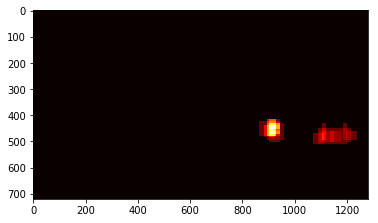

In [6]:
print(np.max(sum_array))
print(np.min(sum_array))
plt.imshow(sum_array, cmap='hot', interpolation='nearest')
plt.show()

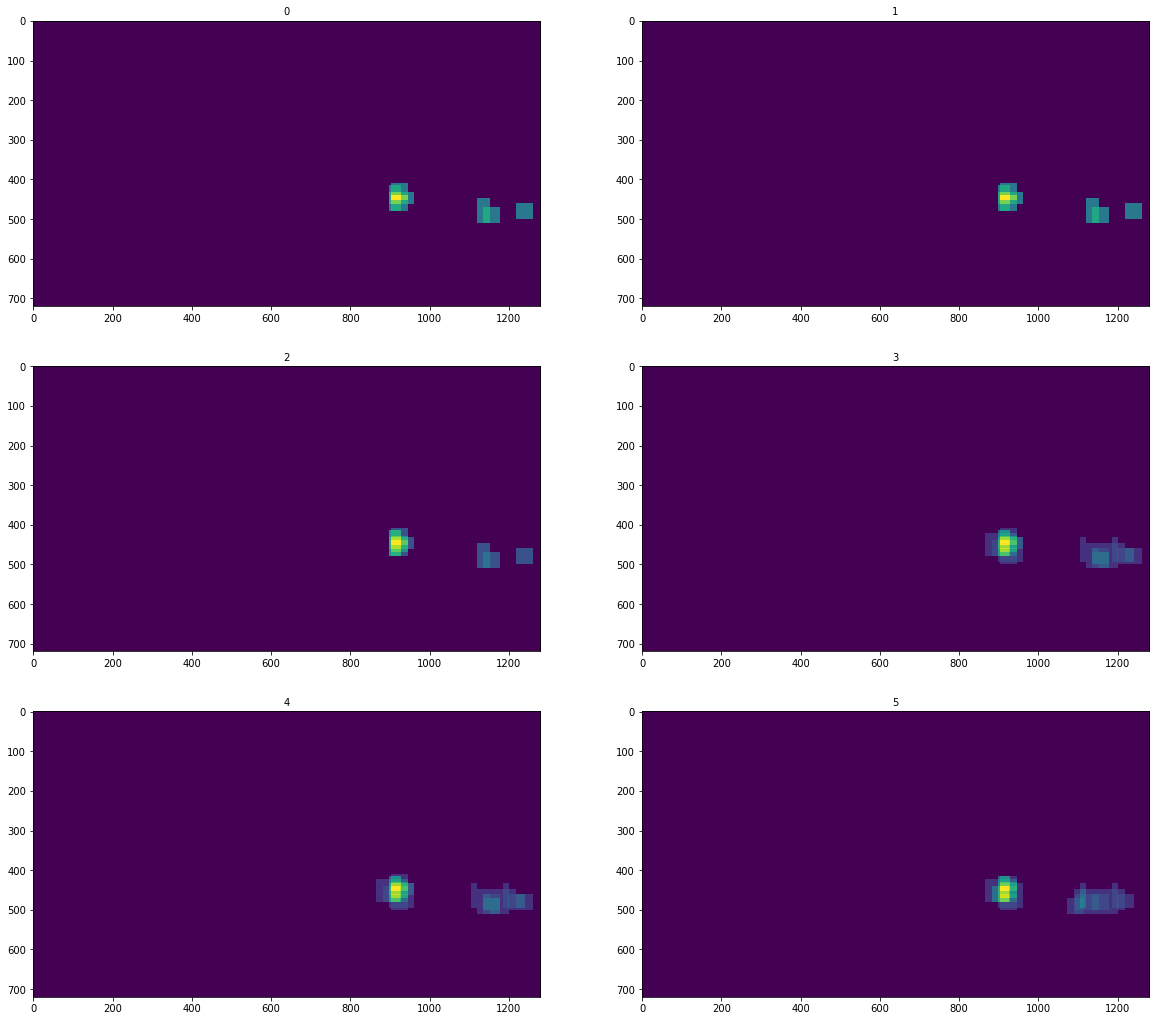

In [7]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,18))
ax1.imshow(heat_box[0])
ax1.set_title('0', fontsize=10)
#ax2.imshow(image)
ax2.imshow(heat_box[1])
ax2.set_title('1', fontsize=10)

ax3.imshow(heat_box[2])
ax3.set_title('2', fontsize=10)

ax4.imshow(heat_box[3])
ax4.set_title('3', fontsize=10)

ax5.imshow(heat_box[4])
ax5.set_title('4', fontsize=10)

ax6.imshow(heat_box[5])
ax6.set_title('5', fontsize=10)

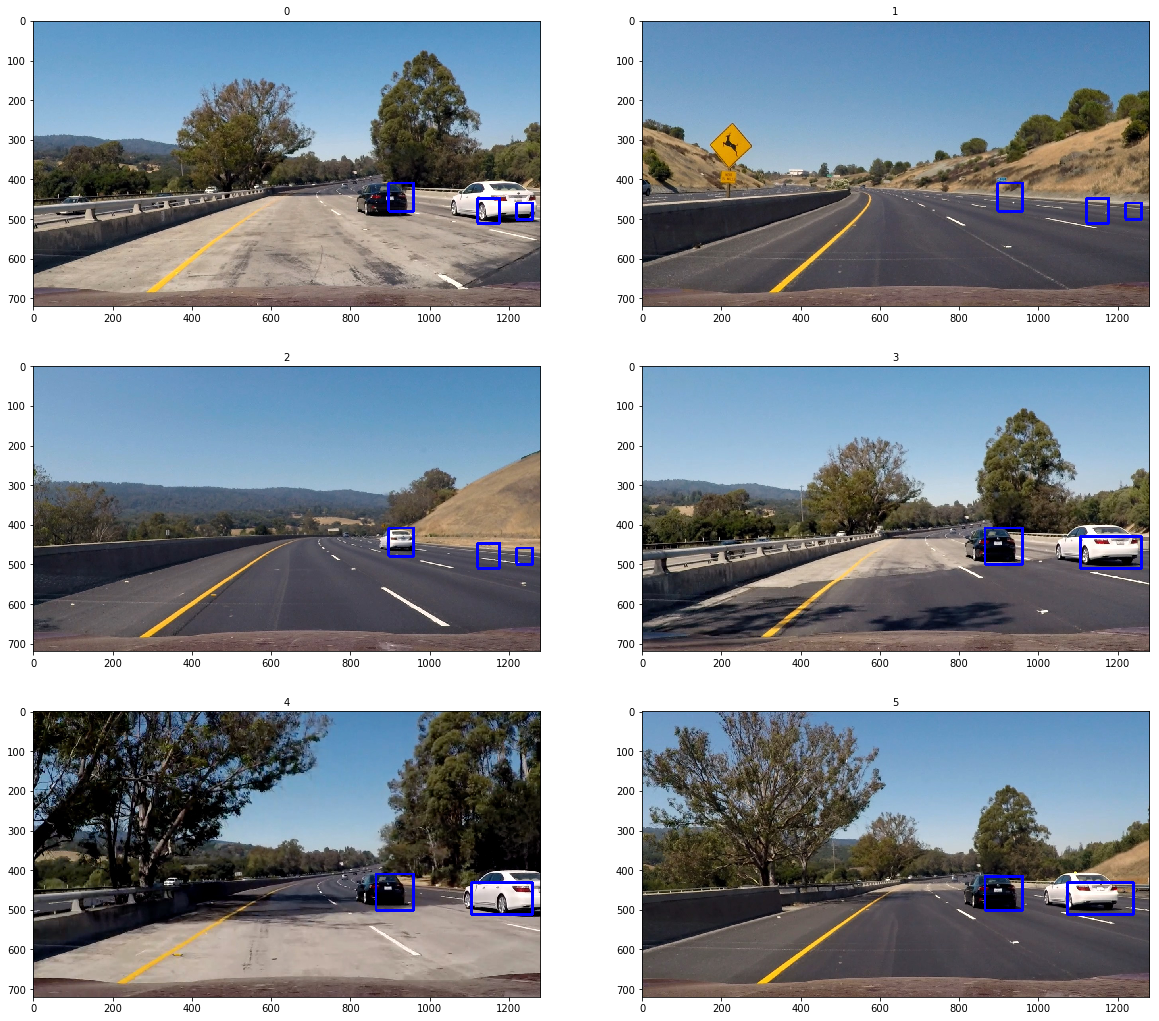

In [8]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,18))
ax1.imshow(labeled_image[0])
ax1.set_title('0', fontsize=10)
#ax2.imshow(image)
ax2.imshow(labeled_image[1])
ax2.set_title('1', fontsize=10)

ax3.imshow(labeled_image[2])
ax3.set_title('2', fontsize=10)

ax4.imshow(labeled_image[3])
ax4.set_title('3', fontsize=10)

ax5.imshow(labeled_image[4])
ax5.set_title('4', fontsize=10)

ax6.imshow(labeled_image[5])
ax6.set_title('5', fontsize=10)

In [121]:
def find_cars_t(img, windows,  svc, image_size= (64,64), cutoff=140, 
                            cspace='RGB', spatial_size=(32,32),  hist_bins=16, 
                            hog_channel='ALL', orient=9, pix_per_cell=8, cell_per_block=2,car_image =False):
    
    
    image = np.copy(img)
    
    pred_dist = []

    bbox_list = []

        
    for window in windows:
    
            img_region = image[window[0][1]:window[1][1],window[0][0]:window[1][0]]
        
            resized = cv2.resize(img_region, image_size)
        
            my_features = extract_single_features(resized,cspace=cspace, spatial_size=spatial_size,  hist_bins=hist_bins, 
                                                  hog_channel=hog_channel,  orient=orient, pix_per_cell=pix_per_cell,
                                                  cell_per_block=cell_per_block)
                
            y_prediction = svc.decision_function(my_features)
#            print('y_prediction is %s ' % y_prediction)
            pred_dist.append(y_prediction)
           

            if( y_prediction >  cutoff):
                
                                             
                cv2.rectangle(image,(window[0][0],window[0][1]),(window[1][0],window[1][1]),(0,0,255),6) 
                bbox_list.append(((window[0][0],window[0][1]),(window[1][0],window[1][1])))
   
    return image, bbox_list, pred_dist


In [122]:
box_threshold = 2
sum_array_threshold = 10
d = deque(maxlen=15)

params = {}
params['windows'] = windows 

def pipeline(image):
    
    all_windows = params['windows']
       
    t=time.time()  
    
    windows = itertools.chain(*all_windows)
         
    test, box_list, pred_dist = find_cars_t(image, windows, svc, image_size= (64,64), cutoff=cutoff, 
                            cspace=cspace, spatial_size=spatial_size,  hist_bins=hist_bins, 
                            hog_channel=hog_channel,  orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,car_image=True)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
    heats = add_heat(heat,box_list)
    
    hot_heat = apply_threshold(heats,box_threshold)
    
#    heat_box.append(hot_heat)

    #    print(hot_heat)
    
    d.append(hot_heat)    
    d_array = np.array(d)
    sum_array = d_array.sum(axis=0)      
    sum_array_thresh = apply_threshold(sum_array,sum_array_threshold)

   
    
#    heatmap= np.clip(hot_heat, 2, 255)

# Find final boxes from heatmap using label function
#    labels = label(heatmap)
    labels = label(sum_array_thresh)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
   
    t2 = time.time()
    print(round(t2-t, 2), 'image processing time...')
    
    return draw_img

In [123]:
def process_image(image):
    
    return pipeline(image)

In [124]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "base_v05.mp4"
%time project_clip.write_videofile(video_output, audio=False)

1.16 image processing time...
[MoviePy] >>>> Building video base_v05.mp4
[MoviePy] Writing video base_v05.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<24:27,  1.16s/it]

1.16 image processing time...




  0%|          | 2/1261 [00:02<24:31,  1.17s/it]

1.17 image processing time...




  0%|          | 3/1261 [00:03<24:30,  1.17s/it]

1.16 image processing time...




  0%|          | 4/1261 [00:04<24:30,  1.17s/it]

1.17 image processing time...




  0%|          | 5/1261 [00:05<24:26,  1.17s/it]

1.16 image processing time...




  0%|          | 6/1261 [00:07<24:21,  1.16s/it]

1.15 image processing time...




  1%|          | 7/1261 [00:08<24:21,  1.17s/it]

1.16 image processing time...




  1%|          | 8/1261 [00:09<24:19,  1.16s/it]

1.16 image processing time...




  1%|          | 9/1261 [00:10<24:17,  1.16s/it]

1.16 image processing time...




  1%|          | 10/1261 [00:11<24:18,  1.17s/it]

1.16 image processing time...




  1%|          | 11/1261 [00:12<24:16,  1.17s/it]

1.16 image processing time...




  1%|          | 12/1261 [00:13<24:15,  1.17s/it]

1.16 image processing time...




  1%|          | 13/1261 [00:15<24:14,  1.17s/it]

1.16 image processing time...




  1%|          | 14/1261 [00:16<24:17,  1.17s/it]

1.17 image processing time...




  1%|          | 15/1261 [00:17<24:19,  1.17s/it]

1.17 image processing time...




  1%|▏         | 16/1261 [00:18<24:20,  1.17s/it]

1.17 image processing time...




  1%|▏         | 17/1261 [00:19<24:21,  1.17s/it]

1.17 image processing time...




  1%|▏         | 18/1261 [00:21<24:24,  1.18s/it]

1.18 image processing time...




  2%|▏         | 19/1261 [00:22<24:23,  1.18s/it]

1.17 image processing time...




  2%|▏         | 20/1261 [00:23<24:21,  1.18s/it]

1.17 image processing time...




  2%|▏         | 21/1261 [00:24<24:16,  1.17s/it]

1.16 image processing time...




  2%|▏         | 22/1261 [00:25<24:17,  1.18s/it]

1.18 image processing time...




  2%|▏         | 23/1261 [00:26<24:15,  1.18s/it]

1.17 image processing time...




  2%|▏         | 24/1261 [00:28<24:14,  1.18s/it]

1.17 image processing time...




  2%|▏         | 25/1261 [00:29<24:14,  1.18s/it]

1.17 image processing time...




  2%|▏         | 26/1261 [00:30<24:10,  1.17s/it]

1.17 image processing time...




  2%|▏         | 27/1261 [00:31<24:06,  1.17s/it]

1.16 image processing time...




  2%|▏         | 28/1261 [00:32<24:04,  1.17s/it]

1.17 image processing time...




  2%|▏         | 29/1261 [00:33<24:04,  1.17s/it]

1.17 image processing time...




  2%|▏         | 30/1261 [00:35<24:06,  1.18s/it]

1.18 image processing time...




  2%|▏         | 31/1261 [00:36<24:10,  1.18s/it]

1.19 image processing time...




  3%|▎         | 32/1261 [00:37<24:09,  1.18s/it]

1.18 image processing time...




  3%|▎         | 33/1261 [00:38<24:24,  1.19s/it]

1.22 image processing time...




  3%|▎         | 34/1261 [00:39<24:20,  1.19s/it]

1.18 image processing time...




  3%|▎         | 35/1261 [00:41<24:12,  1.18s/it]

1.17 image processing time...




  3%|▎         | 36/1261 [00:42<24:06,  1.18s/it]

1.17 image processing time...




  3%|▎         | 37/1261 [00:43<24:04,  1.18s/it]

1.17 image processing time...




  3%|▎         | 38/1261 [00:44<23:59,  1.18s/it]

1.16 image processing time...




  3%|▎         | 39/1261 [00:45<23:58,  1.18s/it]

1.17 image processing time...




  3%|▎         | 40/1261 [00:46<23:54,  1.17s/it]

1.17 image processing time...




  3%|▎         | 41/1261 [00:48<23:49,  1.17s/it]

1.16 image processing time...




  3%|▎         | 42/1261 [00:49<23:46,  1.17s/it]

1.16 image processing time...




  3%|▎         | 43/1261 [00:50<23:45,  1.17s/it]

1.17 image processing time...




  3%|▎         | 44/1261 [00:51<23:46,  1.17s/it]

1.17 image processing time...




  4%|▎         | 45/1261 [00:52<23:46,  1.17s/it]

1.17 image processing time...




  4%|▎         | 46/1261 [00:53<23:44,  1.17s/it]

1.17 image processing time...




  4%|▎         | 47/1261 [00:55<23:46,  1.18s/it]

1.18 image processing time...




  4%|▍         | 48/1261 [00:56<23:43,  1.17s/it]

1.17 image processing time...




  4%|▍         | 49/1261 [00:57<23:44,  1.18s/it]

1.17 image processing time...




  4%|▍         | 50/1261 [00:58<23:45,  1.18s/it]

1.18 image processing time...




  4%|▍         | 51/1261 [00:59<23:44,  1.18s/it]

1.17 image processing time...




  4%|▍         | 52/1261 [01:01<23:45,  1.18s/it]

1.18 image processing time...




  4%|▍         | 53/1261 [01:02<23:43,  1.18s/it]

1.17 image processing time...




  4%|▍         | 54/1261 [01:03<23:41,  1.18s/it]

1.17 image processing time...




  4%|▍         | 55/1261 [01:04<23:42,  1.18s/it]

1.18 image processing time...




  4%|▍         | 56/1261 [01:05<23:42,  1.18s/it]

1.18 image processing time...




  5%|▍         | 57/1261 [01:06<23:39,  1.18s/it]

1.17 image processing time...




  5%|▍         | 58/1261 [01:08<23:42,  1.18s/it]

1.19 image processing time...




  5%|▍         | 59/1261 [01:09<23:39,  1.18s/it]

1.17 image processing time...




  5%|▍         | 60/1261 [01:10<23:37,  1.18s/it]

1.17 image processing time...




  5%|▍         | 61/1261 [01:11<23:40,  1.18s/it]

1.19 image processing time...




  5%|▍         | 62/1261 [01:12<23:39,  1.18s/it]

1.18 image processing time...




  5%|▍         | 63/1261 [01:14<23:35,  1.18s/it]

1.17 image processing time...




  5%|▌         | 64/1261 [01:15<23:33,  1.18s/it]

1.18 image processing time...




  5%|▌         | 65/1261 [01:16<23:31,  1.18s/it]

1.18 image processing time...




  5%|▌         | 66/1261 [01:17<23:29,  1.18s/it]

1.17 image processing time...




  5%|▌         | 67/1261 [01:18<23:27,  1.18s/it]

1.17 image processing time...




  5%|▌         | 68/1261 [01:19<23:25,  1.18s/it]

1.17 image processing time...




  5%|▌         | 69/1261 [01:21<23:23,  1.18s/it]

1.17 image processing time...




  6%|▌         | 70/1261 [01:22<23:22,  1.18s/it]

1.17 image processing time...




  6%|▌         | 71/1261 [01:23<23:21,  1.18s/it]

1.17 image processing time...




  6%|▌         | 72/1261 [01:24<23:19,  1.18s/it]

1.17 image processing time...




  6%|▌         | 73/1261 [01:25<23:19,  1.18s/it]

1.18 image processing time...




  6%|▌         | 74/1261 [01:27<23:18,  1.18s/it]

1.17 image processing time...




  6%|▌         | 75/1261 [01:28<23:15,  1.18s/it]

1.17 image processing time...




  6%|▌         | 76/1261 [01:29<23:12,  1.18s/it]

1.17 image processing time...




  6%|▌         | 77/1261 [01:30<23:11,  1.18s/it]

1.17 image processing time...




  6%|▌         | 78/1261 [01:31<23:10,  1.18s/it]

1.17 image processing time...




  6%|▋         | 79/1261 [01:32<23:09,  1.18s/it]

1.17 image processing time...




  6%|▋         | 80/1261 [01:34<23:08,  1.18s/it]

1.17 image processing time...




  6%|▋         | 81/1261 [01:35<23:06,  1.18s/it]

1.17 image processing time...




  7%|▋         | 82/1261 [01:36<23:05,  1.17s/it]

1.17 image processing time...




  7%|▋         | 83/1261 [01:37<23:03,  1.17s/it]

1.17 image processing time...




  7%|▋         | 84/1261 [01:38<23:02,  1.17s/it]

1.17 image processing time...




  7%|▋         | 85/1261 [01:39<23:02,  1.18s/it]

1.18 image processing time...




  7%|▋         | 86/1261 [01:41<23:01,  1.18s/it]

1.17 image processing time...




  7%|▋         | 87/1261 [01:42<23:00,  1.18s/it]

1.17 image processing time...




  7%|▋         | 88/1261 [01:43<23:00,  1.18s/it]

1.17 image processing time...




  7%|▋         | 89/1261 [01:44<22:59,  1.18s/it]

1.17 image processing time...




  7%|▋         | 90/1261 [01:45<22:58,  1.18s/it]

1.17 image processing time...




  7%|▋         | 91/1261 [01:47<22:59,  1.18s/it]

1.18 image processing time...




  7%|▋         | 92/1261 [01:48<22:58,  1.18s/it]

1.17 image processing time...




  7%|▋         | 93/1261 [01:49<22:57,  1.18s/it]

1.18 image processing time...




  7%|▋         | 94/1261 [01:50<22:52,  1.18s/it]

1.16 image processing time...




  8%|▊         | 95/1261 [01:51<22:56,  1.18s/it]

1.19 image processing time...




  8%|▊         | 96/1261 [01:52<22:53,  1.18s/it]

1.17 image processing time...




  8%|▊         | 97/1261 [01:54<22:52,  1.18s/it]

1.17 image processing time...




  8%|▊         | 98/1261 [01:55<22:52,  1.18s/it]

1.18 image processing time...




  8%|▊         | 99/1261 [01:56<22:50,  1.18s/it]

1.17 image processing time...




  8%|▊         | 100/1261 [01:57<22:47,  1.18s/it]

1.17 image processing time...




  8%|▊         | 101/1261 [01:58<22:48,  1.18s/it]

1.18 image processing time...




  8%|▊         | 102/1261 [01:59<22:47,  1.18s/it]

1.18 image processing time...




  8%|▊         | 103/1261 [02:01<22:44,  1.18s/it]

1.17 image processing time...




  8%|▊         | 104/1261 [02:02<22:43,  1.18s/it]

1.17 image processing time...




  8%|▊         | 105/1261 [02:03<22:42,  1.18s/it]

1.17 image processing time...




  8%|▊         | 106/1261 [02:04<22:40,  1.18s/it]

1.17 image processing time...




  8%|▊         | 107/1261 [02:05<22:37,  1.18s/it]

1.17 image processing time...




  9%|▊         | 108/1261 [02:07<22:35,  1.18s/it]

1.17 image processing time...




  9%|▊         | 109/1261 [02:08<22:34,  1.18s/it]

1.17 image processing time...




  9%|▊         | 110/1261 [02:09<22:38,  1.18s/it]

1.19 image processing time...




  9%|▉         | 111/1261 [02:10<22:37,  1.18s/it]

1.18 image processing time...




  9%|▉         | 112/1261 [02:11<22:35,  1.18s/it]

1.17 image processing time...




  9%|▉         | 113/1261 [02:12<22:34,  1.18s/it]

1.18 image processing time...




  9%|▉         | 114/1261 [02:14<22:32,  1.18s/it]

1.17 image processing time...




  9%|▉         | 115/1261 [02:15<22:31,  1.18s/it]

1.18 image processing time...




  9%|▉         | 116/1261 [02:16<22:31,  1.18s/it]

1.18 image processing time...




  9%|▉         | 117/1261 [02:17<22:27,  1.18s/it]

1.17 image processing time...




  9%|▉         | 118/1261 [02:18<22:26,  1.18s/it]

1.17 image processing time...




  9%|▉         | 119/1261 [02:20<22:26,  1.18s/it]

1.18 image processing time...




 10%|▉         | 120/1261 [02:21<22:27,  1.18s/it]

1.18 image processing time...




 10%|▉         | 121/1261 [02:22<22:28,  1.18s/it]

1.18 image processing time...




 10%|▉         | 122/1261 [02:23<22:27,  1.18s/it]

1.18 image processing time...




 10%|▉         | 123/1261 [02:24<22:26,  1.18s/it]

1.18 image processing time...




 10%|▉         | 124/1261 [02:25<22:21,  1.18s/it]

1.17 image processing time...




 10%|▉         | 125/1261 [02:27<22:20,  1.18s/it]

1.17 image processing time...




 10%|▉         | 126/1261 [02:28<22:18,  1.18s/it]

1.17 image processing time...




 10%|█         | 127/1261 [02:29<22:15,  1.18s/it]

1.17 image processing time...




 10%|█         | 128/1261 [02:30<22:13,  1.18s/it]

1.17 image processing time...




 10%|█         | 129/1261 [02:31<22:11,  1.18s/it]

1.17 image processing time...




 10%|█         | 130/1261 [02:32<22:09,  1.18s/it]

1.17 image processing time...




 10%|█         | 131/1261 [02:34<22:09,  1.18s/it]

1.17 image processing time...




 10%|█         | 132/1261 [02:35<22:08,  1.18s/it]

1.17 image processing time...




 11%|█         | 133/1261 [02:36<22:10,  1.18s/it]

1.18 image processing time...




 11%|█         | 134/1261 [02:37<22:14,  1.18s/it]

1.19 image processing time...




 11%|█         | 135/1261 [02:38<22:27,  1.20s/it]

1.22 image processing time...




 11%|█         | 136/1261 [02:40<22:24,  1.20s/it]

1.19 image processing time...




 11%|█         | 137/1261 [02:41<22:17,  1.19s/it]

1.17 image processing time...




 11%|█         | 138/1261 [02:42<22:13,  1.19s/it]

1.18 image processing time...




 11%|█         | 139/1261 [02:43<22:08,  1.18s/it]

1.17 image processing time...




 11%|█         | 140/1261 [02:44<22:07,  1.18s/it]

1.18 image processing time...




 11%|█         | 141/1261 [02:46<22:04,  1.18s/it]

1.17 image processing time...




 11%|█▏        | 142/1261 [02:47<22:05,  1.18s/it]

1.19 image processing time...




 11%|█▏        | 143/1261 [02:48<22:03,  1.18s/it]

1.18 image processing time...




 11%|█▏        | 144/1261 [02:49<21:59,  1.18s/it]

1.17 image processing time...




 11%|█▏        | 145/1261 [02:50<21:59,  1.18s/it]

1.18 image processing time...




 12%|█▏        | 146/1261 [02:51<22:00,  1.18s/it]

1.19 image processing time...




 12%|█▏        | 147/1261 [02:53<21:58,  1.18s/it]

1.18 image processing time...




 12%|█▏        | 148/1261 [02:54<21:57,  1.18s/it]

1.18 image processing time...




 12%|█▏        | 149/1261 [02:55<21:57,  1.18s/it]

1.18 image processing time...




 12%|█▏        | 150/1261 [02:56<21:53,  1.18s/it]

1.17 image processing time...




 12%|█▏        | 151/1261 [02:57<21:53,  1.18s/it]

1.18 image processing time...




 12%|█▏        | 152/1261 [02:59<21:52,  1.18s/it]

1.18 image processing time...




 12%|█▏        | 153/1261 [03:00<21:51,  1.18s/it]

1.18 image processing time...




 12%|█▏        | 154/1261 [03:01<21:48,  1.18s/it]

1.18 image processing time...




 12%|█▏        | 155/1261 [03:02<21:44,  1.18s/it]

1.17 image processing time...




 12%|█▏        | 156/1261 [03:03<21:42,  1.18s/it]

1.17 image processing time...




 12%|█▏        | 157/1261 [03:04<21:39,  1.18s/it]

1.17 image processing time...




 13%|█▎        | 158/1261 [03:06<21:38,  1.18s/it]

1.17 image processing time...




 13%|█▎        | 159/1261 [03:07<21:37,  1.18s/it]

1.17 image processing time...




 13%|█▎        | 160/1261 [03:08<21:35,  1.18s/it]

1.17 image processing time...




 13%|█▎        | 161/1261 [03:09<21:32,  1.18s/it]

1.17 image processing time...




 13%|█▎        | 162/1261 [03:10<21:32,  1.18s/it]

1.17 image processing time...




 13%|█▎        | 163/1261 [03:11<21:32,  1.18s/it]

1.17 image processing time...




 13%|█▎        | 164/1261 [03:13<21:30,  1.18s/it]

1.17 image processing time...




 13%|█▎        | 165/1261 [03:14<21:32,  1.18s/it]

1.18 image processing time...




 13%|█▎        | 166/1261 [03:15<21:30,  1.18s/it]

1.17 image processing time...




 13%|█▎        | 167/1261 [03:16<21:32,  1.18s/it]

1.18 image processing time...




 13%|█▎        | 168/1261 [03:17<21:31,  1.18s/it]

1.18 image processing time...




 13%|█▎        | 169/1261 [03:19<21:31,  1.18s/it]

1.18 image processing time...




 13%|█▎        | 170/1261 [03:20<21:29,  1.18s/it]

1.17 image processing time...




 14%|█▎        | 171/1261 [03:21<21:25,  1.18s/it]

1.17 image processing time...




 14%|█▎        | 172/1261 [03:22<21:24,  1.18s/it]

1.18 image processing time...




 14%|█▎        | 173/1261 [03:23<21:24,  1.18s/it]

1.18 image processing time...




 14%|█▍        | 174/1261 [03:24<21:24,  1.18s/it]

1.18 image processing time...




 14%|█▍        | 175/1261 [03:26<21:23,  1.18s/it]

1.18 image processing time...




 14%|█▍        | 176/1261 [03:27<21:24,  1.18s/it]

1.18 image processing time...




 14%|█▍        | 177/1261 [03:28<21:22,  1.18s/it]

1.18 image processing time...




 14%|█▍        | 178/1261 [03:29<21:21,  1.18s/it]

1.18 image processing time...




 14%|█▍        | 179/1261 [03:30<21:20,  1.18s/it]

1.18 image processing time...




 14%|█▍        | 180/1261 [03:32<21:17,  1.18s/it]

1.17 image processing time...




 14%|█▍        | 181/1261 [03:33<21:21,  1.19s/it]

1.19 image processing time...




 14%|█▍        | 182/1261 [03:34<21:18,  1.19s/it]

1.18 image processing time...




 15%|█▍        | 183/1261 [03:35<21:17,  1.18s/it]

1.18 image processing time...




 15%|█▍        | 184/1261 [03:36<21:15,  1.18s/it]

1.18 image processing time...




 15%|█▍        | 185/1261 [03:38<21:14,  1.18s/it]

1.18 image processing time...




 15%|█▍        | 186/1261 [03:39<21:12,  1.18s/it]

1.18 image processing time...




 15%|█▍        | 187/1261 [03:40<21:09,  1.18s/it]

1.17 image processing time...




 15%|█▍        | 188/1261 [03:41<21:07,  1.18s/it]

1.17 image processing time...




 15%|█▍        | 189/1261 [03:42<21:06,  1.18s/it]

1.18 image processing time...




 15%|█▌        | 190/1261 [03:43<21:05,  1.18s/it]

1.18 image processing time...




 15%|█▌        | 191/1261 [03:45<21:04,  1.18s/it]

1.18 image processing time...




 15%|█▌        | 192/1261 [03:46<21:02,  1.18s/it]

1.17 image processing time...




 15%|█▌        | 193/1261 [03:47<21:00,  1.18s/it]

1.17 image processing time...




 15%|█▌        | 194/1261 [03:48<21:00,  1.18s/it]

1.18 image processing time...




 15%|█▌        | 195/1261 [03:49<20:58,  1.18s/it]

1.17 image processing time...




 16%|█▌        | 196/1261 [03:51<20:56,  1.18s/it]

1.17 image processing time...




 16%|█▌        | 197/1261 [03:52<20:55,  1.18s/it]

1.18 image processing time...




 16%|█▌        | 198/1261 [03:53<20:54,  1.18s/it]

1.17 image processing time...




 16%|█▌        | 199/1261 [03:54<20:55,  1.18s/it]

1.18 image processing time...




 16%|█▌        | 200/1261 [03:55<20:52,  1.18s/it]

1.17 image processing time...




 16%|█▌        | 201/1261 [03:56<20:52,  1.18s/it]

1.18 image processing time...




 16%|█▌        | 202/1261 [03:58<20:51,  1.18s/it]

1.18 image processing time...




 16%|█▌        | 203/1261 [03:59<20:52,  1.18s/it]

1.18 image processing time...




 16%|█▌        | 204/1261 [04:00<20:49,  1.18s/it]

1.18 image processing time...




 16%|█▋        | 205/1261 [04:01<20:50,  1.18s/it]

1.18 image processing time...




 16%|█▋        | 206/1261 [04:02<20:48,  1.18s/it]

1.18 image processing time...




 16%|█▋        | 207/1261 [04:04<20:49,  1.19s/it]

1.19 image processing time...




 16%|█▋        | 208/1261 [04:05<20:48,  1.19s/it]

1.18 image processing time...




 17%|█▋        | 209/1261 [04:06<20:47,  1.19s/it]

1.18 image processing time...




 17%|█▋        | 210/1261 [04:07<20:46,  1.19s/it]

1.18 image processing time...




 17%|█▋        | 211/1261 [04:08<20:47,  1.19s/it]

1.19 image processing time...




 17%|█▋        | 212/1261 [04:09<20:44,  1.19s/it]

1.18 image processing time...




 17%|█▋        | 213/1261 [04:11<20:41,  1.18s/it]

1.18 image processing time...




 17%|█▋        | 214/1261 [04:12<20:41,  1.19s/it]

1.18 image processing time...




 17%|█▋        | 215/1261 [04:13<20:40,  1.19s/it]

1.18 image processing time...




 17%|█▋        | 216/1261 [04:14<20:39,  1.19s/it]

1.18 image processing time...




 17%|█▋        | 217/1261 [04:15<20:38,  1.19s/it]

1.18 image processing time...




 17%|█▋        | 218/1261 [04:17<20:35,  1.18s/it]

1.18 image processing time...




 17%|█▋        | 219/1261 [04:18<20:32,  1.18s/it]

1.18 image processing time...




 17%|█▋        | 220/1261 [04:19<20:31,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 221/1261 [04:20<20:32,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 222/1261 [04:21<20:31,  1.19s/it]

1.18 image processing time...




 18%|█▊        | 223/1261 [04:22<20:29,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 224/1261 [04:24<20:27,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 225/1261 [04:25<20:26,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 226/1261 [04:26<20:25,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 227/1261 [04:27<20:23,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 228/1261 [04:28<20:23,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 229/1261 [04:30<20:21,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 230/1261 [04:31<20:19,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 231/1261 [04:32<20:16,  1.18s/it]

1.17 image processing time...




 18%|█▊        | 232/1261 [04:33<20:15,  1.18s/it]

1.18 image processing time...




 18%|█▊        | 233/1261 [04:34<20:15,  1.18s/it]

1.18 image processing time...




 19%|█▊        | 234/1261 [04:35<20:16,  1.18s/it]

1.19 image processing time...




 19%|█▊        | 235/1261 [04:37<20:13,  1.18s/it]

1.17 image processing time...




 19%|█▊        | 236/1261 [04:38<20:26,  1.20s/it]

1.22 image processing time...




 19%|█▉        | 237/1261 [04:39<20:28,  1.20s/it]

1.2 image processing time...




 19%|█▉        | 238/1261 [04:40<20:27,  1.20s/it]

1.2 image processing time...




 19%|█▉        | 239/1261 [04:42<20:22,  1.20s/it]

1.18 image processing time...




 19%|█▉        | 240/1261 [04:43<20:16,  1.19s/it]

1.18 image processing time...




 19%|█▉        | 241/1261 [04:44<20:17,  1.19s/it]

1.19 image processing time...




 19%|█▉        | 242/1261 [04:45<20:13,  1.19s/it]

1.18 image processing time...




 19%|█▉        | 243/1261 [04:46<20:09,  1.19s/it]

1.18 image processing time...




 19%|█▉        | 244/1261 [04:47<20:06,  1.19s/it]

1.18 image processing time...




 19%|█▉        | 245/1261 [04:49<20:01,  1.18s/it]

1.17 image processing time...




 20%|█▉        | 246/1261 [04:50<19:59,  1.18s/it]

1.18 image processing time...




 20%|█▉        | 247/1261 [04:51<19:58,  1.18s/it]

1.18 image processing time...




 20%|█▉        | 248/1261 [04:52<20:00,  1.18s/it]

1.19 image processing time...




 20%|█▉        | 249/1261 [04:53<19:59,  1.19s/it]

1.18 image processing time...




 20%|█▉        | 250/1261 [04:55<19:58,  1.19s/it]

1.18 image processing time...




 20%|█▉        | 251/1261 [04:56<19:58,  1.19s/it]

1.18 image processing time...




 20%|█▉        | 252/1261 [04:57<19:57,  1.19s/it]

1.18 image processing time...




 20%|██        | 253/1261 [04:58<19:55,  1.19s/it]

1.18 image processing time...




 20%|██        | 254/1261 [04:59<19:54,  1.19s/it]

1.18 image processing time...




 20%|██        | 255/1261 [05:00<19:52,  1.18s/it]

1.18 image processing time...




 20%|██        | 256/1261 [05:02<19:50,  1.18s/it]

1.18 image processing time...




 20%|██        | 257/1261 [05:03<19:49,  1.18s/it]

1.18 image processing time...




 20%|██        | 258/1261 [05:04<19:47,  1.18s/it]

1.18 image processing time...




 21%|██        | 259/1261 [05:05<19:46,  1.18s/it]

1.18 image processing time...




 21%|██        | 260/1261 [05:06<19:47,  1.19s/it]

1.19 image processing time...




 21%|██        | 261/1261 [05:08<19:45,  1.19s/it]

1.18 image processing time...




 21%|██        | 262/1261 [05:09<19:45,  1.19s/it]

1.18 image processing time...




 21%|██        | 263/1261 [05:10<19:42,  1.19s/it]

1.18 image processing time...




 21%|██        | 264/1261 [05:11<19:41,  1.19s/it]

1.18 image processing time...




 21%|██        | 265/1261 [05:12<19:39,  1.18s/it]

1.18 image processing time...




 21%|██        | 266/1261 [05:13<19:37,  1.18s/it]

1.18 image processing time...




 21%|██        | 267/1261 [05:15<19:36,  1.18s/it]

1.18 image processing time...




 21%|██▏       | 268/1261 [05:16<19:35,  1.18s/it]

1.18 image processing time...




 21%|██▏       | 269/1261 [05:17<19:33,  1.18s/it]

1.18 image processing time...




 21%|██▏       | 270/1261 [05:18<19:33,  1.18s/it]

1.18 image processing time...




 21%|██▏       | 271/1261 [05:19<19:34,  1.19s/it]

1.19 image processing time...




 22%|██▏       | 272/1261 [05:21<19:32,  1.19s/it]

1.18 image processing time...




 22%|██▏       | 273/1261 [05:22<19:30,  1.18s/it]

1.18 image processing time...




 22%|██▏       | 274/1261 [05:23<19:26,  1.18s/it]

1.17 image processing time...




 22%|██▏       | 275/1261 [05:24<19:24,  1.18s/it]

1.18 image processing time...




 22%|██▏       | 276/1261 [05:25<19:22,  1.18s/it]

1.18 image processing time...




 22%|██▏       | 277/1261 [05:26<19:21,  1.18s/it]

1.18 image processing time...




 22%|██▏       | 278/1261 [05:28<19:21,  1.18s/it]

1.18 image processing time...




 22%|██▏       | 279/1261 [05:29<19:20,  1.18s/it]

1.18 image processing time...




 22%|██▏       | 280/1261 [05:30<19:19,  1.18s/it]

1.18 image processing time...




 22%|██▏       | 281/1261 [05:31<19:18,  1.18s/it]

1.18 image processing time...




 22%|██▏       | 282/1261 [05:32<19:15,  1.18s/it]

1.17 image processing time...




 22%|██▏       | 283/1261 [05:34<19:14,  1.18s/it]

1.18 image processing time...




 23%|██▎       | 284/1261 [05:35<19:13,  1.18s/it]

1.18 image processing time...




 23%|██▎       | 285/1261 [05:36<19:11,  1.18s/it]

1.17 image processing time...




 23%|██▎       | 286/1261 [05:37<19:10,  1.18s/it]

1.18 image processing time...




 23%|██▎       | 287/1261 [05:38<19:10,  1.18s/it]

1.18 image processing time...




 23%|██▎       | 288/1261 [05:39<19:10,  1.18s/it]

1.18 image processing time...




 23%|██▎       | 289/1261 [05:41<19:11,  1.18s/it]

1.19 image processing time...




 23%|██▎       | 290/1261 [05:42<19:10,  1.19s/it]

1.18 image processing time...




 23%|██▎       | 291/1261 [05:43<19:10,  1.19s/it]

1.18 image processing time...




 23%|██▎       | 292/1261 [05:44<19:08,  1.19s/it]

1.18 image processing time...




 23%|██▎       | 293/1261 [05:45<19:07,  1.19s/it]

1.18 image processing time...




 23%|██▎       | 294/1261 [05:47<19:08,  1.19s/it]

1.19 image processing time...




 23%|██▎       | 295/1261 [05:48<19:06,  1.19s/it]

1.18 image processing time...




 23%|██▎       | 296/1261 [05:49<19:03,  1.18s/it]

1.18 image processing time...




 24%|██▎       | 297/1261 [05:50<19:01,  1.18s/it]

1.18 image processing time...




 24%|██▎       | 298/1261 [05:51<18:59,  1.18s/it]

1.17 image processing time...




 24%|██▎       | 299/1261 [05:53<18:55,  1.18s/it]

1.17 image processing time...




 24%|██▍       | 300/1261 [05:54<18:53,  1.18s/it]

1.17 image processing time...




 24%|██▍       | 301/1261 [05:55<18:56,  1.18s/it]

1.19 image processing time...




 24%|██▍       | 302/1261 [05:56<18:55,  1.18s/it]

1.18 image processing time...




 24%|██▍       | 303/1261 [05:57<18:51,  1.18s/it]

1.17 image processing time...




 24%|██▍       | 304/1261 [05:58<18:49,  1.18s/it]

1.17 image processing time...




 24%|██▍       | 305/1261 [06:00<18:46,  1.18s/it]

1.17 image processing time...




 24%|██▍       | 306/1261 [06:01<18:45,  1.18s/it]

1.17 image processing time...




 24%|██▍       | 307/1261 [06:02<18:41,  1.18s/it]

1.17 image processing time...




 24%|██▍       | 308/1261 [06:03<18:39,  1.17s/it]

1.17 image processing time...




 25%|██▍       | 309/1261 [06:04<18:39,  1.18s/it]

1.18 image processing time...




 25%|██▍       | 310/1261 [06:05<18:38,  1.18s/it]

1.17 image processing time...




 25%|██▍       | 311/1261 [06:07<18:37,  1.18s/it]

1.17 image processing time...




 25%|██▍       | 312/1261 [06:08<18:35,  1.18s/it]

1.17 image processing time...




 25%|██▍       | 313/1261 [06:09<18:37,  1.18s/it]

1.18 image processing time...




 25%|██▍       | 314/1261 [06:10<18:45,  1.19s/it]

1.21 image processing time...




 25%|██▍       | 315/1261 [06:11<18:42,  1.19s/it]

1.18 image processing time...




 25%|██▌       | 316/1261 [06:13<18:37,  1.18s/it]

1.17 image processing time...




 25%|██▌       | 317/1261 [06:14<18:35,  1.18s/it]

1.18 image processing time...




 25%|██▌       | 318/1261 [06:15<18:35,  1.18s/it]

1.18 image processing time...




 25%|██▌       | 319/1261 [06:16<18:34,  1.18s/it]

1.18 image processing time...




 25%|██▌       | 320/1261 [06:17<18:35,  1.18s/it]

1.19 image processing time...




 25%|██▌       | 321/1261 [06:19<18:35,  1.19s/it]

1.19 image processing time...




 26%|██▌       | 322/1261 [06:20<18:34,  1.19s/it]

1.18 image processing time...




 26%|██▌       | 323/1261 [06:21<18:32,  1.19s/it]

1.18 image processing time...




 26%|██▌       | 324/1261 [06:22<18:30,  1.19s/it]

1.18 image processing time...




 26%|██▌       | 325/1261 [06:23<18:27,  1.18s/it]

1.18 image processing time...




 26%|██▌       | 326/1261 [06:24<18:25,  1.18s/it]

1.17 image processing time...




 26%|██▌       | 327/1261 [06:26<18:25,  1.18s/it]

1.18 image processing time...




 26%|██▌       | 328/1261 [06:27<18:25,  1.19s/it]

1.19 image processing time...




 26%|██▌       | 329/1261 [06:28<18:23,  1.18s/it]

1.18 image processing time...




 26%|██▌       | 330/1261 [06:29<18:21,  1.18s/it]

1.18 image processing time...




 26%|██▌       | 331/1261 [06:30<18:33,  1.20s/it]

1.23 image processing time...




 26%|██▋       | 332/1261 [06:32<18:29,  1.19s/it]

1.19 image processing time...




 26%|██▋       | 333/1261 [06:33<18:25,  1.19s/it]

1.18 image processing time...




 26%|██▋       | 334/1261 [06:34<18:19,  1.19s/it]

1.17 image processing time...




 27%|██▋       | 335/1261 [06:35<18:17,  1.18s/it]

1.18 image processing time...




 27%|██▋       | 336/1261 [06:36<18:15,  1.18s/it]

1.18 image processing time...




 27%|██▋       | 337/1261 [06:38<18:25,  1.20s/it]

1.22 image processing time...




 27%|██▋       | 338/1261 [06:39<18:27,  1.20s/it]

1.21 image processing time...




 27%|██▋       | 339/1261 [06:40<18:21,  1.19s/it]

1.18 image processing time...




 27%|██▋       | 340/1261 [06:41<18:16,  1.19s/it]

1.17 image processing time...




 27%|██▋       | 341/1261 [06:42<18:12,  1.19s/it]

1.18 image processing time...




 27%|██▋       | 342/1261 [06:43<18:09,  1.19s/it]

1.18 image processing time...




 27%|██▋       | 343/1261 [06:45<18:08,  1.19s/it]

1.18 image processing time...




 27%|██▋       | 344/1261 [06:46<18:06,  1.18s/it]

1.18 image processing time...




 27%|██▋       | 345/1261 [06:47<18:04,  1.18s/it]

1.18 image processing time...




 27%|██▋       | 346/1261 [06:48<18:04,  1.18s/it]

1.18 image processing time...




 28%|██▊       | 347/1261 [06:49<18:01,  1.18s/it]

1.18 image processing time...




 28%|██▊       | 348/1261 [06:51<18:00,  1.18s/it]

1.18 image processing time...




 28%|██▊       | 349/1261 [06:52<18:01,  1.19s/it]

1.19 image processing time...




 28%|██▊       | 350/1261 [06:53<17:59,  1.19s/it]

1.18 image processing time...




 28%|██▊       | 351/1261 [06:54<17:58,  1.19s/it]

1.18 image processing time...




 28%|██▊       | 352/1261 [06:55<17:57,  1.19s/it]

1.18 image processing time...




 28%|██▊       | 353/1261 [06:56<17:54,  1.18s/it]

1.18 image processing time...




 28%|██▊       | 354/1261 [06:58<17:55,  1.19s/it]

1.19 image processing time...




 28%|██▊       | 355/1261 [06:59<17:51,  1.18s/it]

1.17 image processing time...




 28%|██▊       | 356/1261 [07:00<17:48,  1.18s/it]

1.17 image processing time...




 28%|██▊       | 357/1261 [07:01<17:48,  1.18s/it]

1.18 image processing time...




 28%|██▊       | 358/1261 [07:02<17:48,  1.18s/it]

1.18 image processing time...




 28%|██▊       | 359/1261 [07:04<17:46,  1.18s/it]

1.18 image processing time...




 29%|██▊       | 360/1261 [07:05<17:46,  1.18s/it]

1.18 image processing time...




 29%|██▊       | 361/1261 [07:06<17:46,  1.19s/it]

1.19 image processing time...




 29%|██▊       | 362/1261 [07:07<17:45,  1.19s/it]

1.18 image processing time...




 29%|██▉       | 363/1261 [07:08<17:43,  1.18s/it]

1.18 image processing time...




 29%|██▉       | 364/1261 [07:10<17:42,  1.18s/it]

1.18 image processing time...




 29%|██▉       | 365/1261 [07:11<17:42,  1.19s/it]

1.18 image processing time...




 29%|██▉       | 366/1261 [07:12<17:40,  1.19s/it]

1.18 image processing time...




 29%|██▉       | 367/1261 [07:13<17:38,  1.18s/it]

1.18 image processing time...




 29%|██▉       | 368/1261 [07:14<17:38,  1.19s/it]

1.18 image processing time...




 29%|██▉       | 369/1261 [07:15<17:35,  1.18s/it]

1.18 image processing time...




 29%|██▉       | 370/1261 [07:17<17:35,  1.18s/it]

1.18 image processing time...




 29%|██▉       | 371/1261 [07:18<17:33,  1.18s/it]

1.18 image processing time...




 30%|██▉       | 372/1261 [07:19<17:31,  1.18s/it]

1.18 image processing time...




 30%|██▉       | 373/1261 [07:20<17:29,  1.18s/it]

1.18 image processing time...




 30%|██▉       | 374/1261 [07:21<17:27,  1.18s/it]

1.17 image processing time...




 30%|██▉       | 375/1261 [07:23<17:26,  1.18s/it]

1.18 image processing time...




 30%|██▉       | 376/1261 [07:24<17:25,  1.18s/it]

1.18 image processing time...




 30%|██▉       | 377/1261 [07:25<17:26,  1.18s/it]

1.18 image processing time...




 30%|██▉       | 378/1261 [07:26<17:24,  1.18s/it]

1.18 image processing time...




 30%|███       | 379/1261 [07:27<17:21,  1.18s/it]

1.17 image processing time...




 30%|███       | 380/1261 [07:28<17:21,  1.18s/it]

1.18 image processing time...




 30%|███       | 381/1261 [07:30<17:20,  1.18s/it]

1.18 image processing time...




 30%|███       | 382/1261 [07:31<17:23,  1.19s/it]

1.2 image processing time...




 30%|███       | 383/1261 [07:32<17:19,  1.18s/it]

1.17 image processing time...




 30%|███       | 384/1261 [07:33<17:18,  1.18s/it]

1.18 image processing time...




 31%|███       | 385/1261 [07:34<17:16,  1.18s/it]

1.18 image processing time...




 31%|███       | 386/1261 [07:36<17:15,  1.18s/it]

1.18 image processing time...




 31%|███       | 387/1261 [07:37<17:13,  1.18s/it]

1.18 image processing time...




 31%|███       | 388/1261 [07:38<17:11,  1.18s/it]

1.18 image processing time...




 31%|███       | 389/1261 [07:39<17:09,  1.18s/it]

1.17 image processing time...




 31%|███       | 390/1261 [07:40<17:06,  1.18s/it]

1.17 image processing time...




 31%|███       | 391/1261 [07:41<17:08,  1.18s/it]

1.19 image processing time...




 31%|███       | 392/1261 [07:43<17:06,  1.18s/it]

1.18 image processing time...




 31%|███       | 393/1261 [07:44<17:05,  1.18s/it]

1.18 image processing time...




 31%|███       | 394/1261 [07:45<17:07,  1.19s/it]

1.19 image processing time...




 31%|███▏      | 395/1261 [07:46<17:03,  1.18s/it]

1.17 image processing time...




 31%|███▏      | 396/1261 [07:47<17:00,  1.18s/it]

1.17 image processing time...




 31%|███▏      | 397/1261 [07:49<16:58,  1.18s/it]

1.17 image processing time...




 32%|███▏      | 398/1261 [07:50<16:56,  1.18s/it]

1.17 image processing time...




 32%|███▏      | 399/1261 [07:51<16:55,  1.18s/it]

1.17 image processing time...




 32%|███▏      | 400/1261 [07:52<16:55,  1.18s/it]

1.18 image processing time...




 32%|███▏      | 401/1261 [07:53<16:55,  1.18s/it]

1.18 image processing time...




 32%|███▏      | 402/1261 [07:54<16:55,  1.18s/it]

1.18 image processing time...




 32%|███▏      | 403/1261 [07:56<17:04,  1.19s/it]

1.22 image processing time...




 32%|███▏      | 404/1261 [07:57<17:03,  1.19s/it]

1.19 image processing time...




 32%|███▏      | 405/1261 [07:58<16:58,  1.19s/it]

1.17 image processing time...




 32%|███▏      | 406/1261 [07:59<16:54,  1.19s/it]

1.17 image processing time...




 32%|███▏      | 407/1261 [08:00<16:51,  1.18s/it]

1.18 image processing time...




 32%|███▏      | 408/1261 [08:02<16:50,  1.18s/it]

1.18 image processing time...




 32%|███▏      | 409/1261 [08:03<16:49,  1.19s/it]

1.18 image processing time...




 33%|███▎      | 410/1261 [08:04<16:48,  1.18s/it]

1.18 image processing time...




 33%|███▎      | 411/1261 [08:05<16:46,  1.18s/it]

1.18 image processing time...




 33%|███▎      | 412/1261 [08:06<16:44,  1.18s/it]

1.18 image processing time...




 33%|███▎      | 413/1261 [08:07<16:43,  1.18s/it]

1.18 image processing time...




 33%|███▎      | 414/1261 [08:09<16:43,  1.18s/it]

1.18 image processing time...




 33%|███▎      | 415/1261 [08:10<16:41,  1.18s/it]

1.18 image processing time...




 33%|███▎      | 416/1261 [08:11<16:40,  1.18s/it]

1.18 image processing time...




 33%|███▎      | 417/1261 [08:12<16:40,  1.19s/it]

1.18 image processing time...




 33%|███▎      | 418/1261 [08:13<16:38,  1.18s/it]

1.18 image processing time...




 33%|███▎      | 419/1261 [08:15<16:37,  1.18s/it]

1.18 image processing time...




 33%|███▎      | 420/1261 [08:16<16:33,  1.18s/it]

1.17 image processing time...




 33%|███▎      | 421/1261 [08:17<16:34,  1.18s/it]

1.18 image processing time...




 33%|███▎      | 422/1261 [08:18<16:33,  1.18s/it]

1.18 image processing time...




 34%|███▎      | 423/1261 [08:19<16:32,  1.18s/it]

1.18 image processing time...




 34%|███▎      | 424/1261 [08:21<16:28,  1.18s/it]

1.17 image processing time...




 34%|███▎      | 425/1261 [08:22<16:25,  1.18s/it]

1.17 image processing time...




 34%|███▍      | 426/1261 [08:23<16:24,  1.18s/it]

1.17 image processing time...




 34%|███▍      | 427/1261 [08:24<16:21,  1.18s/it]

1.17 image processing time...




 34%|███▍      | 428/1261 [08:25<16:19,  1.18s/it]

1.17 image processing time...




 34%|███▍      | 429/1261 [08:26<16:18,  1.18s/it]

1.17 image processing time...




 34%|███▍      | 430/1261 [08:28<16:19,  1.18s/it]

1.18 image processing time...




 34%|███▍      | 431/1261 [08:29<16:17,  1.18s/it]

1.17 image processing time...




 34%|███▍      | 432/1261 [08:30<16:14,  1.18s/it]

1.17 image processing time...




 34%|███▍      | 433/1261 [08:31<16:15,  1.18s/it]

1.18 image processing time...




 34%|███▍      | 434/1261 [08:32<16:14,  1.18s/it]

1.18 image processing time...




 34%|███▍      | 435/1261 [08:33<16:12,  1.18s/it]

1.17 image processing time...




 35%|███▍      | 436/1261 [08:35<16:11,  1.18s/it]

1.17 image processing time...




 35%|███▍      | 437/1261 [08:36<16:09,  1.18s/it]

1.17 image processing time...




 35%|███▍      | 438/1261 [08:37<16:07,  1.18s/it]

1.17 image processing time...




 35%|███▍      | 439/1261 [08:38<16:21,  1.19s/it]

1.23 image processing time...




 35%|███▍      | 440/1261 [08:39<16:22,  1.20s/it]

1.2 image processing time...




 35%|███▍      | 441/1261 [08:41<16:16,  1.19s/it]

1.17 image processing time...




 35%|███▌      | 442/1261 [08:42<16:11,  1.19s/it]

1.17 image processing time...




 35%|███▌      | 443/1261 [08:43<16:07,  1.18s/it]

1.17 image processing time...




 35%|███▌      | 444/1261 [08:44<16:05,  1.18s/it]

1.18 image processing time...




 35%|███▌      | 445/1261 [08:45<16:05,  1.18s/it]

1.18 image processing time...




 35%|███▌      | 446/1261 [08:46<16:02,  1.18s/it]

1.17 image processing time...




 35%|███▌      | 447/1261 [08:48<16:01,  1.18s/it]

1.18 image processing time...




 36%|███▌      | 448/1261 [08:49<15:59,  1.18s/it]

1.17 image processing time...




 36%|███▌      | 449/1261 [08:50<15:57,  1.18s/it]

1.17 image processing time...




 36%|███▌      | 450/1261 [08:51<15:55,  1.18s/it]

1.17 image processing time...




 36%|███▌      | 451/1261 [08:52<15:58,  1.18s/it]

1.19 image processing time...




 36%|███▌      | 452/1261 [08:54<15:58,  1.18s/it]

1.18 image processing time...




 36%|███▌      | 453/1261 [08:55<15:57,  1.19s/it]

1.18 image processing time...




 36%|███▌      | 454/1261 [08:56<15:54,  1.18s/it]

1.17 image processing time...




 36%|███▌      | 455/1261 [08:57<15:53,  1.18s/it]

1.18 image processing time...




 36%|███▌      | 456/1261 [08:58<15:52,  1.18s/it]

1.18 image processing time...




 36%|███▌      | 457/1261 [08:59<15:51,  1.18s/it]

1.18 image processing time...




 36%|███▋      | 458/1261 [09:01<15:50,  1.18s/it]

1.18 image processing time...




 36%|███▋      | 459/1261 [09:02<15:47,  1.18s/it]

1.17 image processing time...




 36%|███▋      | 460/1261 [09:03<15:47,  1.18s/it]

1.18 image processing time...




 37%|███▋      | 461/1261 [09:04<15:46,  1.18s/it]

1.18 image processing time...




 37%|███▋      | 462/1261 [09:05<15:45,  1.18s/it]

1.18 image processing time...




 37%|███▋      | 463/1261 [09:07<15:44,  1.18s/it]

1.18 image processing time...




 37%|███▋      | 464/1261 [09:08<15:41,  1.18s/it]

1.17 image processing time...




 37%|███▋      | 465/1261 [09:09<15:39,  1.18s/it]

1.18 image processing time...




 37%|███▋      | 466/1261 [09:10<15:37,  1.18s/it]

1.17 image processing time...




 37%|███▋      | 467/1261 [09:11<15:37,  1.18s/it]

1.18 image processing time...




 37%|███▋      | 468/1261 [09:12<15:36,  1.18s/it]

1.18 image processing time...




 37%|███▋      | 469/1261 [09:14<15:34,  1.18s/it]

1.17 image processing time...




 37%|███▋      | 470/1261 [09:15<15:34,  1.18s/it]

1.18 image processing time...




 37%|███▋      | 471/1261 [09:16<15:33,  1.18s/it]

1.18 image processing time...




 37%|███▋      | 472/1261 [09:17<15:31,  1.18s/it]

1.17 image processing time...




 38%|███▊      | 473/1261 [09:18<15:29,  1.18s/it]

1.17 image processing time...




 38%|███▊      | 474/1261 [09:20<15:27,  1.18s/it]

1.17 image processing time...




 38%|███▊      | 475/1261 [09:21<15:27,  1.18s/it]

1.18 image processing time...




 38%|███▊      | 476/1261 [09:22<15:26,  1.18s/it]

1.18 image processing time...




 38%|███▊      | 477/1261 [09:23<15:26,  1.18s/it]

1.18 image processing time...




 38%|███▊      | 478/1261 [09:24<15:26,  1.18s/it]

1.18 image processing time...




 38%|███▊      | 479/1261 [09:25<15:24,  1.18s/it]

1.17 image processing time...




 38%|███▊      | 480/1261 [09:27<15:23,  1.18s/it]

1.18 image processing time...




 38%|███▊      | 481/1261 [09:28<15:24,  1.18s/it]

1.19 image processing time...




 38%|███▊      | 482/1261 [09:29<15:22,  1.18s/it]

1.18 image processing time...




 38%|███▊      | 483/1261 [09:30<15:21,  1.18s/it]

1.18 image processing time...




 38%|███▊      | 484/1261 [09:31<15:17,  1.18s/it]

1.17 image processing time...




 38%|███▊      | 485/1261 [09:33<15:16,  1.18s/it]

1.18 image processing time...




 39%|███▊      | 486/1261 [09:34<15:14,  1.18s/it]

1.17 image processing time...




 39%|███▊      | 487/1261 [09:35<15:12,  1.18s/it]

1.17 image processing time...




 39%|███▊      | 488/1261 [09:36<15:11,  1.18s/it]

1.18 image processing time...




 39%|███▉      | 489/1261 [09:37<15:10,  1.18s/it]

1.18 image processing time...




 39%|███▉      | 490/1261 [09:38<15:09,  1.18s/it]

1.18 image processing time...




 39%|███▉      | 491/1261 [09:40<15:09,  1.18s/it]

1.18 image processing time...




 39%|███▉      | 492/1261 [09:41<15:08,  1.18s/it]

1.18 image processing time...




 39%|███▉      | 493/1261 [09:42<15:07,  1.18s/it]

1.18 image processing time...




 39%|███▉      | 494/1261 [09:43<15:05,  1.18s/it]

1.17 image processing time...




 39%|███▉      | 495/1261 [09:44<15:04,  1.18s/it]

1.18 image processing time...




 39%|███▉      | 496/1261 [09:46<15:02,  1.18s/it]

1.17 image processing time...




 39%|███▉      | 497/1261 [09:47<15:00,  1.18s/it]

1.17 image processing time...




 39%|███▉      | 498/1261 [09:48<14:59,  1.18s/it]

1.18 image processing time...




 40%|███▉      | 499/1261 [09:49<14:57,  1.18s/it]

1.17 image processing time...




 40%|███▉      | 500/1261 [09:50<14:56,  1.18s/it]

1.18 image processing time...




 40%|███▉      | 501/1261 [09:51<14:54,  1.18s/it]

1.17 image processing time...




 40%|███▉      | 502/1261 [09:53<14:53,  1.18s/it]

1.17 image processing time...




 40%|███▉      | 503/1261 [09:54<14:52,  1.18s/it]

1.18 image processing time...




 40%|███▉      | 504/1261 [09:55<14:51,  1.18s/it]

1.17 image processing time...




 40%|████      | 505/1261 [09:56<14:50,  1.18s/it]

1.18 image processing time...




 40%|████      | 506/1261 [09:57<14:49,  1.18s/it]

1.17 image processing time...




 40%|████      | 507/1261 [09:59<14:48,  1.18s/it]

1.17 image processing time...




 40%|████      | 508/1261 [10:00<14:48,  1.18s/it]

1.18 image processing time...




 40%|████      | 509/1261 [10:01<14:45,  1.18s/it]

1.17 image processing time...




 40%|████      | 510/1261 [10:02<14:43,  1.18s/it]

1.17 image processing time...




 41%|████      | 511/1261 [10:03<14:45,  1.18s/it]

1.19 image processing time...




 41%|████      | 512/1261 [10:04<14:45,  1.18s/it]

1.18 image processing time...




 41%|████      | 513/1261 [10:06<14:42,  1.18s/it]

1.17 image processing time...




 41%|████      | 514/1261 [10:07<14:42,  1.18s/it]

1.18 image processing time...




 41%|████      | 515/1261 [10:08<14:38,  1.18s/it]

1.17 image processing time...




 41%|████      | 516/1261 [10:09<14:35,  1.17s/it]

1.16 image processing time...




 41%|████      | 517/1261 [10:10<14:32,  1.17s/it]

1.16 image processing time...




 41%|████      | 518/1261 [10:11<14:32,  1.17s/it]

1.17 image processing time...




 41%|████      | 519/1261 [10:13<14:29,  1.17s/it]

1.16 image processing time...




 41%|████      | 520/1261 [10:14<14:27,  1.17s/it]

1.17 image processing time...




 41%|████▏     | 521/1261 [10:15<14:26,  1.17s/it]

1.17 image processing time...




 41%|████▏     | 522/1261 [10:16<14:27,  1.17s/it]

1.18 image processing time...




 41%|████▏     | 523/1261 [10:17<14:25,  1.17s/it]

1.17 image processing time...




 42%|████▏     | 524/1261 [10:18<14:22,  1.17s/it]

1.16 image processing time...




 42%|████▏     | 525/1261 [10:20<14:20,  1.17s/it]

1.16 image processing time...




 42%|████▏     | 526/1261 [10:21<14:19,  1.17s/it]

1.16 image processing time...




 42%|████▏     | 527/1261 [10:22<14:17,  1.17s/it]

1.16 image processing time...




 42%|████▏     | 528/1261 [10:23<14:16,  1.17s/it]

1.16 image processing time...




 42%|████▏     | 529/1261 [10:24<14:14,  1.17s/it]

1.16 image processing time...




 42%|████▏     | 530/1261 [10:25<14:14,  1.17s/it]

1.17 image processing time...




 42%|████▏     | 531/1261 [10:27<14:14,  1.17s/it]

1.17 image processing time...




 42%|████▏     | 532/1261 [10:28<14:13,  1.17s/it]

1.17 image processing time...




 42%|████▏     | 533/1261 [10:29<14:13,  1.17s/it]

1.17 image processing time...




 42%|████▏     | 534/1261 [10:30<14:11,  1.17s/it]

1.17 image processing time...




 42%|████▏     | 535/1261 [10:31<14:09,  1.17s/it]

1.17 image processing time...




 43%|████▎     | 536/1261 [10:33<14:07,  1.17s/it]

1.16 image processing time...




 43%|████▎     | 537/1261 [10:34<14:06,  1.17s/it]

1.16 image processing time...




 43%|████▎     | 538/1261 [10:35<14:05,  1.17s/it]

1.17 image processing time...




 43%|████▎     | 539/1261 [10:36<14:04,  1.17s/it]

1.16 image processing time...




 43%|████▎     | 540/1261 [10:37<14:04,  1.17s/it]

1.17 image processing time...




 43%|████▎     | 541/1261 [10:38<14:08,  1.18s/it]

1.19 image processing time...




 43%|████▎     | 542/1261 [10:40<14:11,  1.18s/it]

1.19 image processing time...




 43%|████▎     | 543/1261 [10:41<14:11,  1.19s/it]

1.18 image processing time...




 43%|████▎     | 544/1261 [10:42<14:08,  1.18s/it]

1.17 image processing time...




 43%|████▎     | 545/1261 [10:43<14:05,  1.18s/it]

1.17 image processing time...




 43%|████▎     | 546/1261 [10:44<14:03,  1.18s/it]

1.17 image processing time...




 43%|████▎     | 547/1261 [10:45<14:01,  1.18s/it]

1.17 image processing time...




 43%|████▎     | 548/1261 [10:47<13:58,  1.18s/it]

1.17 image processing time...




 44%|████▎     | 549/1261 [10:48<13:58,  1.18s/it]

1.18 image processing time...




 44%|████▎     | 550/1261 [10:49<13:56,  1.18s/it]

1.17 image processing time...




 44%|████▎     | 551/1261 [10:50<13:55,  1.18s/it]

1.17 image processing time...




 44%|████▍     | 552/1261 [10:51<13:52,  1.17s/it]

1.16 image processing time...




 44%|████▍     | 553/1261 [10:53<13:50,  1.17s/it]

1.17 image processing time...




 44%|████▍     | 554/1261 [10:54<13:49,  1.17s/it]

1.17 image processing time...




 44%|████▍     | 555/1261 [10:55<13:47,  1.17s/it]

1.17 image processing time...




 44%|████▍     | 556/1261 [10:56<13:44,  1.17s/it]

1.16 image processing time...




 44%|████▍     | 557/1261 [10:57<13:44,  1.17s/it]

1.17 image processing time...




 44%|████▍     | 558/1261 [10:58<13:44,  1.17s/it]

1.17 image processing time...




 44%|████▍     | 559/1261 [11:00<13:44,  1.17s/it]

1.17 image processing time...




 44%|████▍     | 560/1261 [11:01<13:44,  1.18s/it]

1.18 image processing time...




 44%|████▍     | 561/1261 [11:02<13:44,  1.18s/it]

1.17 image processing time...




 45%|████▍     | 562/1261 [11:03<13:42,  1.18s/it]

1.17 image processing time...




 45%|████▍     | 563/1261 [11:04<13:40,  1.18s/it]

1.17 image processing time...




 45%|████▍     | 564/1261 [11:05<13:37,  1.17s/it]

1.17 image processing time...




 45%|████▍     | 565/1261 [11:07<13:37,  1.18s/it]

1.17 image processing time...




 45%|████▍     | 566/1261 [11:08<13:37,  1.18s/it]

1.18 image processing time...




 45%|████▍     | 567/1261 [11:09<13:36,  1.18s/it]

1.17 image processing time...




 45%|████▌     | 568/1261 [11:10<13:34,  1.18s/it]

1.17 image processing time...




 45%|████▌     | 569/1261 [11:11<13:34,  1.18s/it]

1.18 image processing time...




 45%|████▌     | 570/1261 [11:13<13:33,  1.18s/it]

1.18 image processing time...




 45%|████▌     | 571/1261 [11:14<13:30,  1.17s/it]

1.16 image processing time...




 45%|████▌     | 572/1261 [11:15<13:29,  1.18s/it]

1.17 image processing time...




 45%|████▌     | 573/1261 [11:16<13:27,  1.17s/it]

1.17 image processing time...




 46%|████▌     | 574/1261 [11:17<13:25,  1.17s/it]

1.16 image processing time...




 46%|████▌     | 575/1261 [11:18<13:23,  1.17s/it]

1.17 image processing time...




 46%|████▌     | 576/1261 [11:20<13:23,  1.17s/it]

1.17 image processing time...




 46%|████▌     | 577/1261 [11:21<13:23,  1.17s/it]

1.18 image processing time...




 46%|████▌     | 578/1261 [11:22<13:23,  1.18s/it]

1.18 image processing time...




 46%|████▌     | 579/1261 [11:23<13:22,  1.18s/it]

1.17 image processing time...




 46%|████▌     | 580/1261 [11:24<13:20,  1.18s/it]

1.17 image processing time...




 46%|████▌     | 581/1261 [11:25<13:19,  1.18s/it]

1.17 image processing time...




 46%|████▌     | 582/1261 [11:27<13:18,  1.18s/it]

1.17 image processing time...




 46%|████▌     | 583/1261 [11:28<13:16,  1.18s/it]

1.17 image processing time...




 46%|████▋     | 584/1261 [11:29<13:16,  1.18s/it]

1.17 image processing time...




 46%|████▋     | 585/1261 [11:30<13:14,  1.18s/it]

1.17 image processing time...




 46%|████▋     | 586/1261 [11:31<13:11,  1.17s/it]

1.16 image processing time...




 47%|████▋     | 587/1261 [11:32<13:11,  1.17s/it]

1.18 image processing time...




 47%|████▋     | 588/1261 [11:34<13:11,  1.18s/it]

1.17 image processing time...




 47%|████▋     | 589/1261 [11:35<13:08,  1.17s/it]

1.16 image processing time...




 47%|████▋     | 590/1261 [11:36<13:06,  1.17s/it]

1.17 image processing time...




 47%|████▋     | 591/1261 [11:37<13:05,  1.17s/it]

1.17 image processing time...




 47%|████▋     | 592/1261 [11:38<13:05,  1.17s/it]

1.17 image processing time...




 47%|████▋     | 593/1261 [11:40<13:03,  1.17s/it]

1.17 image processing time...




 47%|████▋     | 594/1261 [11:41<13:01,  1.17s/it]

1.16 image processing time...




 47%|████▋     | 595/1261 [11:42<12:59,  1.17s/it]

1.16 image processing time...




 47%|████▋     | 596/1261 [11:43<12:57,  1.17s/it]

1.16 image processing time...




 47%|████▋     | 597/1261 [11:44<12:58,  1.17s/it]

1.18 image processing time...




 47%|████▋     | 598/1261 [11:45<12:59,  1.18s/it]

1.18 image processing time...




 48%|████▊     | 599/1261 [11:47<12:58,  1.18s/it]

1.17 image processing time...




 48%|████▊     | 600/1261 [11:48<12:56,  1.17s/it]

1.17 image processing time...




 48%|████▊     | 601/1261 [11:49<12:54,  1.17s/it]

1.16 image processing time...




 48%|████▊     | 602/1261 [11:50<12:52,  1.17s/it]

1.16 image processing time...




 48%|████▊     | 603/1261 [11:51<12:51,  1.17s/it]

1.17 image processing time...




 48%|████▊     | 604/1261 [11:52<12:49,  1.17s/it]

1.17 image processing time...




 48%|████▊     | 605/1261 [11:54<12:47,  1.17s/it]

1.16 image processing time...




 48%|████▊     | 606/1261 [11:55<12:46,  1.17s/it]

1.17 image processing time...




 48%|████▊     | 607/1261 [11:56<12:47,  1.17s/it]

1.18 image processing time...




 48%|████▊     | 608/1261 [11:57<12:46,  1.17s/it]

1.17 image processing time...




 48%|████▊     | 609/1261 [11:58<12:45,  1.17s/it]

1.17 image processing time...




 48%|████▊     | 610/1261 [11:59<12:45,  1.18s/it]

1.17 image processing time...




 48%|████▊     | 611/1261 [12:01<12:44,  1.18s/it]

1.17 image processing time...




 49%|████▊     | 612/1261 [12:02<12:44,  1.18s/it]

1.18 image processing time...




 49%|████▊     | 613/1261 [12:03<12:43,  1.18s/it]

1.18 image processing time...




 49%|████▊     | 614/1261 [12:04<12:42,  1.18s/it]

1.17 image processing time...




 49%|████▉     | 615/1261 [12:05<12:42,  1.18s/it]

1.18 image processing time...




 49%|████▉     | 616/1261 [12:07<12:41,  1.18s/it]

1.18 image processing time...




 49%|████▉     | 617/1261 [12:08<12:40,  1.18s/it]

1.18 image processing time...




 49%|████▉     | 618/1261 [12:09<12:38,  1.18s/it]

1.17 image processing time...




 49%|████▉     | 619/1261 [12:10<12:36,  1.18s/it]

1.17 image processing time...




 49%|████▉     | 620/1261 [12:11<12:35,  1.18s/it]

1.17 image processing time...




 49%|████▉     | 621/1261 [12:12<12:35,  1.18s/it]

1.18 image processing time...




 49%|████▉     | 622/1261 [12:14<12:34,  1.18s/it]

1.18 image processing time...




 49%|████▉     | 623/1261 [12:15<12:32,  1.18s/it]

1.18 image processing time...




 49%|████▉     | 624/1261 [12:16<12:31,  1.18s/it]

1.18 image processing time...




 50%|████▉     | 625/1261 [12:17<12:30,  1.18s/it]

1.18 image processing time...




 50%|████▉     | 626/1261 [12:18<12:30,  1.18s/it]

1.18 image processing time...




 50%|████▉     | 627/1261 [12:20<12:28,  1.18s/it]

1.17 image processing time...




 50%|████▉     | 628/1261 [12:21<12:27,  1.18s/it]

1.18 image processing time...




 50%|████▉     | 629/1261 [12:22<12:25,  1.18s/it]

1.17 image processing time...




 50%|████▉     | 630/1261 [12:23<12:23,  1.18s/it]

1.17 image processing time...




 50%|█████     | 631/1261 [12:24<12:22,  1.18s/it]

1.18 image processing time...




 50%|█████     | 632/1261 [12:25<12:22,  1.18s/it]

1.18 image processing time...




 50%|█████     | 633/1261 [12:27<12:20,  1.18s/it]

1.17 image processing time...




 50%|█████     | 634/1261 [12:28<12:19,  1.18s/it]

1.18 image processing time...




 50%|█████     | 635/1261 [12:29<12:18,  1.18s/it]

1.18 image processing time...




 50%|█████     | 636/1261 [12:30<12:15,  1.18s/it]

1.17 image processing time...




 51%|█████     | 637/1261 [12:31<12:14,  1.18s/it]

1.17 image processing time...




 51%|█████     | 638/1261 [12:32<12:16,  1.18s/it]

1.19 image processing time...




 51%|█████     | 639/1261 [12:34<12:14,  1.18s/it]

1.18 image processing time...




 51%|█████     | 640/1261 [12:35<12:12,  1.18s/it]

1.17 image processing time...




 51%|█████     | 641/1261 [12:36<12:11,  1.18s/it]

1.17 image processing time...




 51%|█████     | 642/1261 [12:37<12:09,  1.18s/it]

1.17 image processing time...




 51%|█████     | 643/1261 [12:38<12:14,  1.19s/it]

1.21 image processing time...




 51%|█████     | 644/1261 [12:40<12:15,  1.19s/it]

1.2 image processing time...




 51%|█████     | 645/1261 [12:41<12:13,  1.19s/it]

1.18 image processing time...




 51%|█████     | 646/1261 [12:42<12:10,  1.19s/it]

1.17 image processing time...




 51%|█████▏    | 647/1261 [12:43<12:05,  1.18s/it]

1.17 image processing time...




 51%|█████▏    | 648/1261 [12:44<12:03,  1.18s/it]

1.17 image processing time...




 51%|█████▏    | 649/1261 [12:45<12:01,  1.18s/it]

1.17 image processing time...




 52%|█████▏    | 650/1261 [12:47<12:00,  1.18s/it]

1.18 image processing time...




 52%|█████▏    | 651/1261 [12:48<11:57,  1.18s/it]

1.17 image processing time...




 52%|█████▏    | 652/1261 [12:49<11:57,  1.18s/it]

1.18 image processing time...




 52%|█████▏    | 653/1261 [12:50<11:58,  1.18s/it]

1.18 image processing time...




 52%|█████▏    | 654/1261 [12:51<11:58,  1.18s/it]

1.19 image processing time...




 52%|█████▏    | 655/1261 [12:53<11:56,  1.18s/it]

1.17 image processing time...




 52%|█████▏    | 656/1261 [12:54<11:54,  1.18s/it]

1.17 image processing time...




 52%|█████▏    | 657/1261 [12:55<11:52,  1.18s/it]

1.17 image processing time...




 52%|█████▏    | 658/1261 [12:56<11:51,  1.18s/it]

1.17 image processing time...




 52%|█████▏    | 659/1261 [12:57<11:50,  1.18s/it]

1.18 image processing time...




 52%|█████▏    | 660/1261 [12:58<11:48,  1.18s/it]

1.18 image processing time...




 52%|█████▏    | 661/1261 [13:00<11:48,  1.18s/it]

1.18 image processing time...




 52%|█████▏    | 662/1261 [13:01<11:45,  1.18s/it]

1.17 image processing time...




 53%|█████▎    | 663/1261 [13:02<11:44,  1.18s/it]

1.17 image processing time...




 53%|█████▎    | 664/1261 [13:03<11:42,  1.18s/it]

1.17 image processing time...




 53%|█████▎    | 665/1261 [13:04<11:41,  1.18s/it]

1.18 image processing time...




 53%|█████▎    | 666/1261 [13:06<11:40,  1.18s/it]

1.17 image processing time...




 53%|█████▎    | 667/1261 [13:07<11:39,  1.18s/it]

1.18 image processing time...




 53%|█████▎    | 668/1261 [13:08<11:38,  1.18s/it]

1.18 image processing time...




 53%|█████▎    | 669/1261 [13:09<11:36,  1.18s/it]

1.17 image processing time...




 53%|█████▎    | 670/1261 [13:10<11:36,  1.18s/it]

1.18 image processing time...




 53%|█████▎    | 671/1261 [13:11<11:34,  1.18s/it]

1.17 image processing time...




 53%|█████▎    | 672/1261 [13:13<11:33,  1.18s/it]

1.17 image processing time...




 53%|█████▎    | 673/1261 [13:14<11:31,  1.18s/it]

1.17 image processing time...




 53%|█████▎    | 674/1261 [13:15<11:29,  1.18s/it]

1.17 image processing time...




 54%|█████▎    | 675/1261 [13:16<11:28,  1.18s/it]

1.17 image processing time...




 54%|█████▎    | 676/1261 [13:17<11:27,  1.18s/it]

1.17 image processing time...




 54%|█████▎    | 677/1261 [13:18<11:26,  1.18s/it]

1.17 image processing time...




 54%|█████▍    | 678/1261 [13:20<11:26,  1.18s/it]

1.18 image processing time...




 54%|█████▍    | 679/1261 [13:21<11:24,  1.18s/it]

1.17 image processing time...




 54%|█████▍    | 680/1261 [13:22<11:23,  1.18s/it]

1.18 image processing time...




 54%|█████▍    | 681/1261 [13:23<11:21,  1.17s/it]

1.17 image processing time...




 54%|█████▍    | 682/1261 [13:24<11:20,  1.18s/it]

1.17 image processing time...




 54%|█████▍    | 683/1261 [13:26<11:18,  1.17s/it]

1.16 image processing time...




 54%|█████▍    | 684/1261 [13:27<11:17,  1.17s/it]

1.17 image processing time...




 54%|█████▍    | 685/1261 [13:28<11:16,  1.17s/it]

1.17 image processing time...




 54%|█████▍    | 686/1261 [13:29<11:15,  1.17s/it]

1.17 image processing time...




 54%|█████▍    | 687/1261 [13:30<11:17,  1.18s/it]

1.19 image processing time...




 55%|█████▍    | 688/1261 [13:31<11:16,  1.18s/it]

1.17 image processing time...




 55%|█████▍    | 689/1261 [13:33<11:15,  1.18s/it]

1.18 image processing time...




 55%|█████▍    | 690/1261 [13:34<11:14,  1.18s/it]

1.18 image processing time...




 55%|█████▍    | 691/1261 [13:35<11:14,  1.18s/it]

1.19 image processing time...




 55%|█████▍    | 692/1261 [13:36<11:13,  1.18s/it]

1.18 image processing time...




 55%|█████▍    | 693/1261 [13:37<11:11,  1.18s/it]

1.17 image processing time...




 55%|█████▌    | 694/1261 [13:39<11:09,  1.18s/it]

1.17 image processing time...




 55%|█████▌    | 695/1261 [13:40<11:08,  1.18s/it]

1.18 image processing time...




 55%|█████▌    | 696/1261 [13:41<11:06,  1.18s/it]

1.17 image processing time...




 55%|█████▌    | 697/1261 [13:42<11:06,  1.18s/it]

1.18 image processing time...




 55%|█████▌    | 698/1261 [13:43<11:04,  1.18s/it]

1.18 image processing time...




 55%|█████▌    | 699/1261 [13:44<11:03,  1.18s/it]

1.17 image processing time...




 56%|█████▌    | 700/1261 [13:46<11:03,  1.18s/it]

1.18 image processing time...




 56%|█████▌    | 701/1261 [13:47<11:02,  1.18s/it]

1.18 image processing time...




 56%|█████▌    | 702/1261 [13:48<11:01,  1.18s/it]

1.18 image processing time...




 56%|█████▌    | 703/1261 [13:49<10:59,  1.18s/it]

1.17 image processing time...




 56%|█████▌    | 704/1261 [13:50<10:58,  1.18s/it]

1.18 image processing time...




 56%|█████▌    | 705/1261 [13:52<10:58,  1.18s/it]

1.18 image processing time...




 56%|█████▌    | 706/1261 [13:53<10:56,  1.18s/it]

1.18 image processing time...




 56%|█████▌    | 707/1261 [13:54<10:56,  1.18s/it]

1.18 image processing time...




 56%|█████▌    | 708/1261 [13:55<10:54,  1.18s/it]

1.18 image processing time...




 56%|█████▌    | 709/1261 [13:56<10:55,  1.19s/it]

1.19 image processing time...




 56%|█████▋    | 710/1261 [13:57<10:55,  1.19s/it]

1.19 image processing time...




 56%|█████▋    | 711/1261 [13:59<10:55,  1.19s/it]

1.19 image processing time...




 56%|█████▋    | 712/1261 [14:00<10:53,  1.19s/it]

1.18 image processing time...




 57%|█████▋    | 713/1261 [14:01<10:52,  1.19s/it]

1.19 image processing time...




 57%|█████▋    | 714/1261 [14:02<10:51,  1.19s/it]

1.19 image processing time...




 57%|█████▋    | 715/1261 [14:03<10:50,  1.19s/it]

1.18 image processing time...




 57%|█████▋    | 716/1261 [14:05<10:48,  1.19s/it]

1.18 image processing time...




 57%|█████▋    | 717/1261 [14:06<10:46,  1.19s/it]

1.18 image processing time...




 57%|█████▋    | 718/1261 [14:07<10:44,  1.19s/it]

1.18 image processing time...




 57%|█████▋    | 719/1261 [14:08<10:43,  1.19s/it]

1.19 image processing time...




 57%|█████▋    | 720/1261 [14:09<10:42,  1.19s/it]

1.18 image processing time...




 57%|█████▋    | 721/1261 [14:11<10:43,  1.19s/it]

1.2 image processing time...




 57%|█████▋    | 722/1261 [14:12<10:43,  1.19s/it]

1.19 image processing time...




 57%|█████▋    | 723/1261 [14:13<10:41,  1.19s/it]

1.18 image processing time...




 57%|█████▋    | 724/1261 [14:14<10:38,  1.19s/it]

1.18 image processing time...




 57%|█████▋    | 725/1261 [14:15<10:36,  1.19s/it]

1.18 image processing time...




 58%|█████▊    | 726/1261 [14:17<10:35,  1.19s/it]

1.18 image processing time...




 58%|█████▊    | 727/1261 [14:18<10:32,  1.19s/it]

1.18 image processing time...




 58%|█████▊    | 728/1261 [14:19<10:31,  1.18s/it]

1.18 image processing time...




 58%|█████▊    | 729/1261 [14:20<10:29,  1.18s/it]

1.18 image processing time...




 58%|█████▊    | 730/1261 [14:21<10:28,  1.18s/it]

1.18 image processing time...




 58%|█████▊    | 731/1261 [14:22<10:27,  1.18s/it]

1.18 image processing time...




 58%|█████▊    | 732/1261 [14:24<10:25,  1.18s/it]

1.18 image processing time...




 58%|█████▊    | 733/1261 [14:25<10:24,  1.18s/it]

1.18 image processing time...




 58%|█████▊    | 734/1261 [14:26<10:23,  1.18s/it]

1.18 image processing time...




 58%|█████▊    | 735/1261 [14:27<10:23,  1.18s/it]

1.19 image processing time...




 58%|█████▊    | 736/1261 [14:28<10:21,  1.18s/it]

1.18 image processing time...




 58%|█████▊    | 737/1261 [14:30<10:21,  1.19s/it]

1.19 image processing time...




 59%|█████▊    | 738/1261 [14:31<10:20,  1.19s/it]

1.18 image processing time...




 59%|█████▊    | 739/1261 [14:32<10:19,  1.19s/it]

1.18 image processing time...




 59%|█████▊    | 740/1261 [14:33<10:18,  1.19s/it]

1.18 image processing time...




 59%|█████▉    | 741/1261 [14:34<10:16,  1.19s/it]

1.18 image processing time...




 59%|█████▉    | 742/1261 [14:35<10:15,  1.19s/it]

1.18 image processing time...




 59%|█████▉    | 743/1261 [14:37<10:14,  1.19s/it]

1.18 image processing time...




 59%|█████▉    | 744/1261 [14:38<10:15,  1.19s/it]

1.2 image processing time...




 59%|█████▉    | 745/1261 [14:39<10:19,  1.20s/it]

1.22 image processing time...




 59%|█████▉    | 746/1261 [14:40<10:19,  1.20s/it]

1.21 image processing time...




 59%|█████▉    | 747/1261 [14:41<10:17,  1.20s/it]

1.19 image processing time...




 59%|█████▉    | 748/1261 [14:43<10:14,  1.20s/it]

1.19 image processing time...




 59%|█████▉    | 749/1261 [14:44<10:12,  1.20s/it]

1.19 image processing time...




 59%|█████▉    | 750/1261 [14:45<10:10,  1.19s/it]

1.19 image processing time...




 60%|█████▉    | 751/1261 [14:46<10:09,  1.20s/it]

1.19 image processing time...




 60%|█████▉    | 752/1261 [14:47<10:08,  1.19s/it]

1.19 image processing time...




 60%|█████▉    | 753/1261 [14:49<10:06,  1.19s/it]

1.18 image processing time...




 60%|█████▉    | 754/1261 [14:50<10:03,  1.19s/it]

1.18 image processing time...




 60%|█████▉    | 755/1261 [14:51<10:01,  1.19s/it]

1.18 image processing time...




 60%|█████▉    | 756/1261 [14:52<09:59,  1.19s/it]

1.18 image processing time...




 60%|██████    | 757/1261 [14:53<09:58,  1.19s/it]

1.18 image processing time...




 60%|██████    | 758/1261 [14:55<09:57,  1.19s/it]

1.18 image processing time...




 60%|██████    | 759/1261 [14:56<09:56,  1.19s/it]

1.18 image processing time...




 60%|██████    | 760/1261 [14:57<09:54,  1.19s/it]

1.18 image processing time...




 60%|██████    | 761/1261 [14:58<09:52,  1.19s/it]

1.18 image processing time...




 60%|██████    | 762/1261 [14:59<09:51,  1.18s/it]

1.18 image processing time...




 61%|██████    | 763/1261 [15:00<09:49,  1.18s/it]

1.18 image processing time...




 61%|██████    | 764/1261 [15:02<09:49,  1.19s/it]

1.19 image processing time...




 61%|██████    | 765/1261 [15:03<09:50,  1.19s/it]

1.19 image processing time...




 61%|██████    | 766/1261 [15:04<09:49,  1.19s/it]

1.19 image processing time...




 61%|██████    | 767/1261 [15:05<09:46,  1.19s/it]

1.18 image processing time...




 61%|██████    | 768/1261 [15:06<09:44,  1.18s/it]

1.17 image processing time...




 61%|██████    | 769/1261 [15:08<09:44,  1.19s/it]

1.19 image processing time...




 61%|██████    | 770/1261 [15:09<09:44,  1.19s/it]

1.19 image processing time...




 61%|██████    | 771/1261 [15:10<09:42,  1.19s/it]

1.18 image processing time...




 61%|██████    | 772/1261 [15:11<09:40,  1.19s/it]

1.18 image processing time...




 61%|██████▏   | 773/1261 [15:12<09:39,  1.19s/it]

1.18 image processing time...




 61%|██████▏   | 774/1261 [15:14<09:37,  1.19s/it]

1.18 image processing time...




 61%|██████▏   | 775/1261 [15:15<09:35,  1.19s/it]

1.18 image processing time...




 62%|██████▏   | 776/1261 [15:16<09:34,  1.18s/it]

1.18 image processing time...




 62%|██████▏   | 777/1261 [15:17<09:32,  1.18s/it]

1.18 image processing time...




 62%|██████▏   | 778/1261 [15:18<09:31,  1.18s/it]

1.18 image processing time...




 62%|██████▏   | 779/1261 [15:19<09:30,  1.18s/it]

1.18 image processing time...




 62%|██████▏   | 780/1261 [15:21<09:31,  1.19s/it]

1.19 image processing time...




 62%|██████▏   | 781/1261 [15:22<09:32,  1.19s/it]

1.2 image processing time...




 62%|██████▏   | 782/1261 [15:23<09:30,  1.19s/it]

1.18 image processing time...




 62%|██████▏   | 783/1261 [15:24<09:27,  1.19s/it]

1.18 image processing time...




 62%|██████▏   | 784/1261 [15:25<09:25,  1.19s/it]

1.18 image processing time...




 62%|██████▏   | 785/1261 [15:27<09:24,  1.19s/it]

1.18 image processing time...




 62%|██████▏   | 786/1261 [15:28<09:21,  1.18s/it]

1.17 image processing time...




 62%|██████▏   | 787/1261 [15:29<09:19,  1.18s/it]

1.17 image processing time...




 62%|██████▏   | 788/1261 [15:30<09:17,  1.18s/it]

1.17 image processing time...




 63%|██████▎   | 789/1261 [15:31<09:16,  1.18s/it]

1.17 image processing time...




 63%|██████▎   | 790/1261 [15:32<09:15,  1.18s/it]

1.18 image processing time...




 63%|██████▎   | 791/1261 [15:34<09:14,  1.18s/it]

1.18 image processing time...




 63%|██████▎   | 792/1261 [15:35<09:13,  1.18s/it]

1.18 image processing time...




 63%|██████▎   | 793/1261 [15:36<09:13,  1.18s/it]

1.18 image processing time...




 63%|██████▎   | 794/1261 [15:37<09:11,  1.18s/it]

1.17 image processing time...




 63%|██████▎   | 795/1261 [15:38<09:10,  1.18s/it]

1.18 image processing time...




 63%|██████▎   | 796/1261 [15:40<09:09,  1.18s/it]

1.18 image processing time...




 63%|██████▎   | 797/1261 [15:41<09:07,  1.18s/it]

1.17 image processing time...




 63%|██████▎   | 798/1261 [15:42<09:06,  1.18s/it]

1.18 image processing time...




 63%|██████▎   | 799/1261 [15:43<09:04,  1.18s/it]

1.17 image processing time...




 63%|██████▎   | 800/1261 [15:44<09:04,  1.18s/it]

1.18 image processing time...




 64%|██████▎   | 801/1261 [15:45<09:03,  1.18s/it]

1.18 image processing time...




 64%|██████▎   | 802/1261 [15:47<09:02,  1.18s/it]

1.17 image processing time...




 64%|██████▎   | 803/1261 [15:48<09:00,  1.18s/it]

1.17 image processing time...




 64%|██████▍   | 804/1261 [15:49<08:58,  1.18s/it]

1.17 image processing time...




 64%|██████▍   | 805/1261 [15:50<08:59,  1.18s/it]

1.19 image processing time...




 64%|██████▍   | 806/1261 [15:51<08:57,  1.18s/it]

1.18 image processing time...




 64%|██████▍   | 807/1261 [15:53<08:57,  1.18s/it]

1.18 image processing time...




 64%|██████▍   | 808/1261 [15:54<08:55,  1.18s/it]

1.18 image processing time...




 64%|██████▍   | 809/1261 [15:55<08:54,  1.18s/it]

1.18 image processing time...




 64%|██████▍   | 810/1261 [15:56<08:53,  1.18s/it]

1.18 image processing time...




 64%|██████▍   | 811/1261 [15:57<08:53,  1.19s/it]

1.19 image processing time...




 64%|██████▍   | 812/1261 [15:59<08:52,  1.19s/it]

1.18 image processing time...




 64%|██████▍   | 813/1261 [16:00<08:51,  1.19s/it]

1.18 image processing time...




 65%|██████▍   | 814/1261 [16:01<08:49,  1.18s/it]

1.17 image processing time...




 65%|██████▍   | 815/1261 [16:02<08:46,  1.18s/it]

1.17 image processing time...




 65%|██████▍   | 816/1261 [16:03<08:45,  1.18s/it]

1.17 image processing time...




 65%|██████▍   | 817/1261 [16:04<08:43,  1.18s/it]

1.17 image processing time...




 65%|██████▍   | 818/1261 [16:06<08:42,  1.18s/it]

1.17 image processing time...




 65%|██████▍   | 819/1261 [16:07<08:40,  1.18s/it]

1.17 image processing time...




 65%|██████▌   | 820/1261 [16:08<08:39,  1.18s/it]

1.17 image processing time...




 65%|██████▌   | 821/1261 [16:09<08:38,  1.18s/it]

1.17 image processing time...




 65%|██████▌   | 822/1261 [16:10<08:36,  1.18s/it]

1.17 image processing time...




 65%|██████▌   | 823/1261 [16:11<08:35,  1.18s/it]

1.17 image processing time...




 65%|██████▌   | 824/1261 [16:13<08:34,  1.18s/it]

1.18 image processing time...




 65%|██████▌   | 825/1261 [16:14<08:34,  1.18s/it]

1.18 image processing time...




 66%|██████▌   | 826/1261 [16:15<08:34,  1.18s/it]

1.18 image processing time...




 66%|██████▌   | 827/1261 [16:16<08:33,  1.18s/it]

1.18 image processing time...




 66%|██████▌   | 828/1261 [16:17<08:34,  1.19s/it]

1.19 image processing time...




 66%|██████▌   | 829/1261 [16:19<08:33,  1.19s/it]

1.18 image processing time...




 66%|██████▌   | 830/1261 [16:20<08:31,  1.19s/it]

1.18 image processing time...




 66%|██████▌   | 831/1261 [16:21<08:29,  1.19s/it]

1.18 image processing time...




 66%|██████▌   | 832/1261 [16:22<08:28,  1.19s/it]

1.18 image processing time...




 66%|██████▌   | 833/1261 [16:23<08:26,  1.18s/it]

1.18 image processing time...




 66%|██████▌   | 834/1261 [16:25<08:26,  1.19s/it]

1.18 image processing time...




 66%|██████▌   | 835/1261 [16:26<08:25,  1.19s/it]

1.18 image processing time...




 66%|██████▋   | 836/1261 [16:27<08:23,  1.18s/it]

1.18 image processing time...




 66%|██████▋   | 837/1261 [16:28<08:22,  1.18s/it]

1.18 image processing time...




 66%|██████▋   | 838/1261 [16:29<08:20,  1.18s/it]

1.17 image processing time...




 67%|██████▋   | 839/1261 [16:30<08:19,  1.18s/it]

1.18 image processing time...




 67%|██████▋   | 840/1261 [16:32<08:18,  1.18s/it]

1.19 image processing time...




 67%|██████▋   | 841/1261 [16:33<08:19,  1.19s/it]

1.19 image processing time...




 67%|██████▋   | 842/1261 [16:34<08:18,  1.19s/it]

1.18 image processing time...




 67%|██████▋   | 843/1261 [16:35<08:15,  1.19s/it]

1.18 image processing time...




 67%|██████▋   | 844/1261 [16:36<08:13,  1.18s/it]

1.17 image processing time...




 67%|██████▋   | 845/1261 [16:38<08:12,  1.18s/it]

1.18 image processing time...




 67%|██████▋   | 846/1261 [16:39<08:20,  1.21s/it]

1.25 image processing time...




 67%|██████▋   | 847/1261 [16:40<08:20,  1.21s/it]

1.21 image processing time...




 67%|██████▋   | 848/1261 [16:41<08:16,  1.20s/it]

1.19 image processing time...




 67%|██████▋   | 849/1261 [16:42<08:13,  1.20s/it]

1.18 image processing time...




 67%|██████▋   | 850/1261 [16:44<08:11,  1.20s/it]

1.19 image processing time...




 67%|██████▋   | 851/1261 [16:45<08:08,  1.19s/it]

1.18 image processing time...




 68%|██████▊   | 852/1261 [16:46<08:06,  1.19s/it]

1.18 image processing time...




 68%|██████▊   | 853/1261 [16:47<08:04,  1.19s/it]

1.18 image processing time...




 68%|██████▊   | 854/1261 [16:48<08:02,  1.19s/it]

1.18 image processing time...




 68%|██████▊   | 855/1261 [16:49<08:01,  1.19s/it]

1.18 image processing time...




 68%|██████▊   | 856/1261 [16:51<08:00,  1.19s/it]

1.18 image processing time...




 68%|██████▊   | 857/1261 [16:52<07:58,  1.18s/it]

1.18 image processing time...




 68%|██████▊   | 858/1261 [16:53<07:56,  1.18s/it]

1.18 image processing time...




 68%|██████▊   | 859/1261 [16:54<07:55,  1.18s/it]

1.18 image processing time...




 68%|██████▊   | 860/1261 [16:55<07:54,  1.18s/it]

1.18 image processing time...




 68%|██████▊   | 861/1261 [16:57<07:52,  1.18s/it]

1.18 image processing time...




 68%|██████▊   | 862/1261 [16:58<07:51,  1.18s/it]

1.17 image processing time...




 68%|██████▊   | 863/1261 [16:59<07:50,  1.18s/it]

1.18 image processing time...




 69%|██████▊   | 864/1261 [17:00<07:49,  1.18s/it]

1.18 image processing time...




 69%|██████▊   | 865/1261 [17:01<07:48,  1.18s/it]

1.18 image processing time...




 69%|██████▊   | 866/1261 [17:03<07:47,  1.18s/it]

1.18 image processing time...




 69%|██████▉   | 867/1261 [17:04<07:46,  1.18s/it]

1.18 image processing time...




 69%|██████▉   | 868/1261 [17:05<07:44,  1.18s/it]

1.17 image processing time...




 69%|██████▉   | 869/1261 [17:06<07:42,  1.18s/it]

1.17 image processing time...




 69%|██████▉   | 870/1261 [17:07<07:41,  1.18s/it]

1.17 image processing time...




 69%|██████▉   | 871/1261 [17:08<07:41,  1.18s/it]

1.19 image processing time...




 69%|██████▉   | 872/1261 [17:10<07:39,  1.18s/it]

1.17 image processing time...




 69%|██████▉   | 873/1261 [17:11<07:37,  1.18s/it]

1.17 image processing time...




 69%|██████▉   | 874/1261 [17:12<07:35,  1.18s/it]

1.17 image processing time...




 69%|██████▉   | 875/1261 [17:13<07:33,  1.17s/it]

1.17 image processing time...




 69%|██████▉   | 876/1261 [17:14<07:32,  1.18s/it]

1.17 image processing time...




 70%|██████▉   | 877/1261 [17:15<07:32,  1.18s/it]

1.18 image processing time...




 70%|██████▉   | 878/1261 [17:17<07:31,  1.18s/it]

1.18 image processing time...




 70%|██████▉   | 879/1261 [17:18<07:30,  1.18s/it]

1.18 image processing time...




 70%|██████▉   | 880/1261 [17:19<07:29,  1.18s/it]

1.18 image processing time...




 70%|██████▉   | 881/1261 [17:20<07:28,  1.18s/it]

1.18 image processing time...




 70%|██████▉   | 882/1261 [17:21<07:28,  1.18s/it]

1.18 image processing time...




 70%|███████   | 883/1261 [17:23<07:26,  1.18s/it]

1.18 image processing time...




 70%|███████   | 884/1261 [17:24<07:25,  1.18s/it]

1.18 image processing time...




 70%|███████   | 885/1261 [17:25<07:23,  1.18s/it]

1.17 image processing time...




 70%|███████   | 886/1261 [17:26<07:24,  1.19s/it]

1.19 image processing time...




 70%|███████   | 887/1261 [17:27<07:22,  1.18s/it]

1.18 image processing time...




 70%|███████   | 888/1261 [17:28<07:21,  1.18s/it]

1.18 image processing time...




 70%|███████   | 889/1261 [17:30<07:19,  1.18s/it]

1.17 image processing time...




 71%|███████   | 890/1261 [17:31<07:18,  1.18s/it]

1.18 image processing time...




 71%|███████   | 891/1261 [17:32<07:16,  1.18s/it]

1.17 image processing time...




 71%|███████   | 892/1261 [17:33<07:14,  1.18s/it]

1.17 image processing time...




 71%|███████   | 893/1261 [17:34<07:12,  1.18s/it]

1.17 image processing time...




 71%|███████   | 894/1261 [17:36<07:11,  1.18s/it]

1.17 image processing time...




 71%|███████   | 895/1261 [17:37<07:10,  1.18s/it]

1.17 image processing time...




 71%|███████   | 896/1261 [17:38<07:10,  1.18s/it]

1.18 image processing time...




 71%|███████   | 897/1261 [17:39<07:09,  1.18s/it]

1.18 image processing time...




 71%|███████   | 898/1261 [17:40<07:08,  1.18s/it]

1.18 image processing time...




 71%|███████▏  | 899/1261 [17:41<07:08,  1.18s/it]

1.18 image processing time...




 71%|███████▏  | 900/1261 [17:43<07:06,  1.18s/it]

1.17 image processing time...




 71%|███████▏  | 901/1261 [17:44<07:06,  1.18s/it]

1.19 image processing time...




 72%|███████▏  | 902/1261 [17:45<07:05,  1.19s/it]

1.18 image processing time...




 72%|███████▏  | 903/1261 [17:46<07:04,  1.18s/it]

1.18 image processing time...




 72%|███████▏  | 904/1261 [17:47<07:02,  1.18s/it]

1.18 image processing time...




 72%|███████▏  | 905/1261 [17:49<07:00,  1.18s/it]

1.17 image processing time...




 72%|███████▏  | 906/1261 [17:50<06:59,  1.18s/it]

1.18 image processing time...




 72%|███████▏  | 907/1261 [17:51<06:57,  1.18s/it]

1.17 image processing time...




 72%|███████▏  | 908/1261 [17:52<06:55,  1.18s/it]

1.17 image processing time...




 72%|███████▏  | 909/1261 [17:53<06:54,  1.18s/it]

1.17 image processing time...




 72%|███████▏  | 910/1261 [17:54<06:52,  1.18s/it]

1.17 image processing time...




 72%|███████▏  | 911/1261 [17:56<06:51,  1.18s/it]

1.18 image processing time...




 72%|███████▏  | 912/1261 [17:57<06:50,  1.18s/it]

1.17 image processing time...




 72%|███████▏  | 913/1261 [17:58<06:49,  1.18s/it]

1.17 image processing time...




 72%|███████▏  | 914/1261 [17:59<06:48,  1.18s/it]

1.17 image processing time...




 73%|███████▎  | 915/1261 [18:00<06:47,  1.18s/it]

1.17 image processing time...




 73%|███████▎  | 916/1261 [18:01<06:45,  1.18s/it]

1.17 image processing time...




 73%|███████▎  | 917/1261 [18:03<06:44,  1.18s/it]

1.17 image processing time...




 73%|███████▎  | 918/1261 [18:04<06:43,  1.18s/it]

1.17 image processing time...




 73%|███████▎  | 919/1261 [18:05<06:42,  1.18s/it]

1.18 image processing time...




 73%|███████▎  | 920/1261 [18:06<06:42,  1.18s/it]

1.18 image processing time...




 73%|███████▎  | 921/1261 [18:07<06:41,  1.18s/it]

1.18 image processing time...




 73%|███████▎  | 922/1261 [18:09<06:40,  1.18s/it]

1.18 image processing time...




 73%|███████▎  | 923/1261 [18:10<06:39,  1.18s/it]

1.18 image processing time...




 73%|███████▎  | 924/1261 [18:11<06:38,  1.18s/it]

1.18 image processing time...




 73%|███████▎  | 925/1261 [18:12<06:37,  1.18s/it]

1.18 image processing time...




 73%|███████▎  | 926/1261 [18:13<06:36,  1.18s/it]

1.18 image processing time...




 74%|███████▎  | 927/1261 [18:14<06:34,  1.18s/it]

1.17 image processing time...




 74%|███████▎  | 928/1261 [18:16<06:33,  1.18s/it]

1.18 image processing time...




 74%|███████▎  | 929/1261 [18:17<06:32,  1.18s/it]

1.18 image processing time...




 74%|███████▍  | 930/1261 [18:18<06:31,  1.18s/it]

1.18 image processing time...




 74%|███████▍  | 931/1261 [18:19<06:31,  1.19s/it]

1.19 image processing time...




 74%|███████▍  | 932/1261 [18:20<06:30,  1.19s/it]

1.18 image processing time...




 74%|███████▍  | 933/1261 [18:22<06:28,  1.18s/it]

1.18 image processing time...




 74%|███████▍  | 934/1261 [18:23<06:26,  1.18s/it]

1.18 image processing time...




 74%|███████▍  | 935/1261 [18:24<06:25,  1.18s/it]

1.18 image processing time...




 74%|███████▍  | 936/1261 [18:25<06:24,  1.18s/it]

1.17 image processing time...




 74%|███████▍  | 937/1261 [18:26<06:23,  1.18s/it]

1.18 image processing time...




 74%|███████▍  | 938/1261 [18:27<06:21,  1.18s/it]

1.18 image processing time...




 74%|███████▍  | 939/1261 [18:29<06:20,  1.18s/it]

1.17 image processing time...




 75%|███████▍  | 940/1261 [18:30<06:18,  1.18s/it]

1.18 image processing time...




 75%|███████▍  | 941/1261 [18:31<06:17,  1.18s/it]

1.18 image processing time...




 75%|███████▍  | 942/1261 [18:32<06:16,  1.18s/it]

1.17 image processing time...




 75%|███████▍  | 943/1261 [18:33<06:16,  1.18s/it]

1.19 image processing time...




 75%|███████▍  | 944/1261 [18:35<06:15,  1.18s/it]

1.18 image processing time...




 75%|███████▍  | 945/1261 [18:36<06:13,  1.18s/it]

1.18 image processing time...




 75%|███████▌  | 946/1261 [18:37<06:12,  1.18s/it]

1.17 image processing time...




 75%|███████▌  | 947/1261 [18:38<06:12,  1.19s/it]

1.2 image processing time...




 75%|███████▌  | 948/1261 [18:39<06:13,  1.19s/it]

1.2 image processing time...




 75%|███████▌  | 949/1261 [18:41<06:12,  1.19s/it]

1.19 image processing time...




 75%|███████▌  | 950/1261 [18:42<06:10,  1.19s/it]

1.18 image processing time...




 75%|███████▌  | 951/1261 [18:43<06:08,  1.19s/it]

1.17 image processing time...




 75%|███████▌  | 952/1261 [18:44<06:06,  1.19s/it]

1.18 image processing time...




 76%|███████▌  | 953/1261 [18:45<06:04,  1.18s/it]

1.17 image processing time...




 76%|███████▌  | 954/1261 [18:46<06:02,  1.18s/it]

1.17 image processing time...




 76%|███████▌  | 955/1261 [18:48<06:01,  1.18s/it]

1.17 image processing time...




 76%|███████▌  | 956/1261 [18:49<05:59,  1.18s/it]

1.17 image processing time...




 76%|███████▌  | 957/1261 [18:50<05:58,  1.18s/it]

1.17 image processing time...




 76%|███████▌  | 958/1261 [18:51<05:57,  1.18s/it]

1.18 image processing time...




 76%|███████▌  | 959/1261 [18:52<05:56,  1.18s/it]

1.18 image processing time...




 76%|███████▌  | 960/1261 [18:54<05:55,  1.18s/it]

1.17 image processing time...




 76%|███████▌  | 961/1261 [18:55<05:55,  1.19s/it]

1.2 image processing time...




 76%|███████▋  | 962/1261 [18:56<05:54,  1.18s/it]

1.18 image processing time...




 76%|███████▋  | 963/1261 [18:57<05:51,  1.18s/it]

1.17 image processing time...




 76%|███████▋  | 964/1261 [18:58<05:50,  1.18s/it]

1.17 image processing time...




 77%|███████▋  | 965/1261 [18:59<05:47,  1.18s/it]

1.16 image processing time...




 77%|███████▋  | 966/1261 [19:01<05:46,  1.17s/it]

1.17 image processing time...




 77%|███████▋  | 967/1261 [19:02<05:45,  1.18s/it]

1.17 image processing time...




 77%|███████▋  | 968/1261 [19:03<05:44,  1.17s/it]

1.17 image processing time...




 77%|███████▋  | 969/1261 [19:04<05:43,  1.18s/it]

1.18 image processing time...




 77%|███████▋  | 970/1261 [19:05<05:42,  1.18s/it]

1.17 image processing time...




 77%|███████▋  | 971/1261 [19:06<05:41,  1.18s/it]

1.17 image processing time...




 77%|███████▋  | 972/1261 [19:08<05:40,  1.18s/it]

1.17 image processing time...




 77%|███████▋  | 973/1261 [19:09<05:39,  1.18s/it]

1.18 image processing time...




 77%|███████▋  | 974/1261 [19:10<05:38,  1.18s/it]

1.18 image processing time...




 77%|███████▋  | 975/1261 [19:11<05:37,  1.18s/it]

1.17 image processing time...




 77%|███████▋  | 976/1261 [19:12<05:35,  1.18s/it]

1.17 image processing time...




 77%|███████▋  | 977/1261 [19:14<05:34,  1.18s/it]

1.17 image processing time...




 78%|███████▊  | 978/1261 [19:15<05:33,  1.18s/it]

1.17 image processing time...




 78%|███████▊  | 979/1261 [19:16<05:32,  1.18s/it]

1.17 image processing time...




 78%|███████▊  | 980/1261 [19:17<05:30,  1.18s/it]

1.17 image processing time...




 78%|███████▊  | 981/1261 [19:18<05:29,  1.18s/it]

1.17 image processing time...




 78%|███████▊  | 982/1261 [19:19<05:28,  1.18s/it]

1.17 image processing time...




 78%|███████▊  | 983/1261 [19:21<05:27,  1.18s/it]

1.17 image processing time...




 78%|███████▊  | 984/1261 [19:22<05:26,  1.18s/it]

1.18 image processing time...




 78%|███████▊  | 985/1261 [19:23<05:25,  1.18s/it]

1.17 image processing time...




 78%|███████▊  | 986/1261 [19:24<05:24,  1.18s/it]

1.18 image processing time...




 78%|███████▊  | 987/1261 [19:25<05:23,  1.18s/it]

1.18 image processing time...




 78%|███████▊  | 988/1261 [19:27<05:21,  1.18s/it]

1.18 image processing time...




 78%|███████▊  | 989/1261 [19:28<05:20,  1.18s/it]

1.17 image processing time...




 79%|███████▊  | 990/1261 [19:29<05:19,  1.18s/it]

1.18 image processing time...




 79%|███████▊  | 991/1261 [19:30<05:18,  1.18s/it]

1.17 image processing time...




 79%|███████▊  | 992/1261 [19:31<05:16,  1.18s/it]

1.17 image processing time...




 79%|███████▊  | 993/1261 [19:32<05:15,  1.18s/it]

1.17 image processing time...




 79%|███████▉  | 994/1261 [19:34<05:14,  1.18s/it]

1.17 image processing time...




 79%|███████▉  | 995/1261 [19:35<05:13,  1.18s/it]

1.17 image processing time...




 79%|███████▉  | 996/1261 [19:36<05:11,  1.18s/it]

1.17 image processing time...




 79%|███████▉  | 997/1261 [19:37<05:10,  1.18s/it]

1.17 image processing time...




 79%|███████▉  | 998/1261 [19:38<05:09,  1.18s/it]

1.18 image processing time...




 79%|███████▉  | 999/1261 [19:39<05:09,  1.18s/it]

1.18 image processing time...




 79%|███████▉  | 1000/1261 [19:41<05:07,  1.18s/it]

1.17 image processing time...




 79%|███████▉  | 1001/1261 [19:42<05:06,  1.18s/it]

1.18 image processing time...




 79%|███████▉  | 1002/1261 [19:43<05:05,  1.18s/it]

1.17 image processing time...




 80%|███████▉  | 1003/1261 [19:44<05:04,  1.18s/it]

1.18 image processing time...




 80%|███████▉  | 1004/1261 [19:45<05:02,  1.18s/it]

1.17 image processing time...




 80%|███████▉  | 1005/1261 [19:47<05:01,  1.18s/it]

1.17 image processing time...




 80%|███████▉  | 1006/1261 [19:48<04:59,  1.17s/it]

1.17 image processing time...




 80%|███████▉  | 1007/1261 [19:49<04:58,  1.17s/it]

1.17 image processing time...




 80%|███████▉  | 1008/1261 [19:50<04:57,  1.18s/it]

1.17 image processing time...




 80%|████████  | 1009/1261 [19:51<04:56,  1.18s/it]

1.17 image processing time...




 80%|████████  | 1010/1261 [19:52<04:55,  1.18s/it]

1.17 image processing time...




 80%|████████  | 1011/1261 [19:54<04:54,  1.18s/it]

1.18 image processing time...




 80%|████████  | 1012/1261 [19:55<04:53,  1.18s/it]

1.18 image processing time...




 80%|████████  | 1013/1261 [19:56<04:52,  1.18s/it]

1.18 image processing time...




 80%|████████  | 1014/1261 [19:57<04:54,  1.19s/it]

1.22 image processing time...




 80%|████████  | 1015/1261 [19:58<04:54,  1.20s/it]

1.2 image processing time...




 81%|████████  | 1016/1261 [20:00<04:53,  1.20s/it]

1.2 image processing time...




 81%|████████  | 1017/1261 [20:01<04:52,  1.20s/it]

1.2 image processing time...




 81%|████████  | 1018/1261 [20:02<04:51,  1.20s/it]

1.19 image processing time...




 81%|████████  | 1019/1261 [20:03<04:50,  1.20s/it]

1.2 image processing time...




 81%|████████  | 1020/1261 [20:04<04:48,  1.20s/it]

1.19 image processing time...




 81%|████████  | 1021/1261 [20:06<04:48,  1.20s/it]

1.19 image processing time...




 81%|████████  | 1022/1261 [20:07<04:45,  1.19s/it]

1.18 image processing time...




 81%|████████  | 1023/1261 [20:08<04:42,  1.19s/it]

1.17 image processing time...




 81%|████████  | 1024/1261 [20:09<04:41,  1.19s/it]

1.18 image processing time...




 81%|████████▏ | 1025/1261 [20:10<04:39,  1.19s/it]

1.18 image processing time...




 81%|████████▏ | 1026/1261 [20:11<04:37,  1.18s/it]

1.16 image processing time...




 81%|████████▏ | 1027/1261 [20:13<04:35,  1.18s/it]

1.17 image processing time...




 82%|████████▏ | 1028/1261 [20:14<04:33,  1.17s/it]

1.16 image processing time...




 82%|████████▏ | 1029/1261 [20:15<04:32,  1.18s/it]

1.18 image processing time...




 82%|████████▏ | 1030/1261 [20:16<04:30,  1.17s/it]

1.16 image processing time...




 82%|████████▏ | 1031/1261 [20:17<04:29,  1.17s/it]

1.16 image processing time...




 82%|████████▏ | 1032/1261 [20:18<04:27,  1.17s/it]

1.16 image processing time...




 82%|████████▏ | 1033/1261 [20:20<04:27,  1.17s/it]

1.17 image processing time...




 82%|████████▏ | 1034/1261 [20:21<04:25,  1.17s/it]

1.16 image processing time...




 82%|████████▏ | 1035/1261 [20:22<04:23,  1.17s/it]

1.16 image processing time...




 82%|████████▏ | 1036/1261 [20:23<04:22,  1.17s/it]

1.16 image processing time...




 82%|████████▏ | 1037/1261 [20:24<04:20,  1.16s/it]

1.16 image processing time...




 82%|████████▏ | 1038/1261 [20:25<04:20,  1.17s/it]

1.18 image processing time...




 82%|████████▏ | 1039/1261 [20:27<04:18,  1.17s/it]

1.15 image processing time...




 82%|████████▏ | 1040/1261 [20:28<04:16,  1.16s/it]

1.15 image processing time...




 83%|████████▎ | 1041/1261 [20:29<04:14,  1.16s/it]

1.14 image processing time...




 83%|████████▎ | 1042/1261 [20:30<04:13,  1.16s/it]

1.15 image processing time...




 83%|████████▎ | 1043/1261 [20:31<04:12,  1.16s/it]

1.16 image processing time...




 83%|████████▎ | 1044/1261 [20:32<04:13,  1.17s/it]

1.18 image processing time...




 83%|████████▎ | 1045/1261 [20:34<04:14,  1.18s/it]

1.2 image processing time...




 83%|████████▎ | 1046/1261 [20:35<04:13,  1.18s/it]

1.18 image processing time...




 83%|████████▎ | 1047/1261 [20:36<04:11,  1.17s/it]

1.16 image processing time...




 83%|████████▎ | 1048/1261 [20:37<04:10,  1.17s/it]

1.17 image processing time...




 83%|████████▎ | 1049/1261 [20:38<04:10,  1.18s/it]

1.2 image processing time...




 83%|████████▎ | 1050/1261 [20:40<04:10,  1.19s/it]

1.18 image processing time...




 83%|████████▎ | 1051/1261 [20:41<04:06,  1.17s/it]

1.15 image processing time...




 83%|████████▎ | 1052/1261 [20:42<04:04,  1.17s/it]

1.16 image processing time...




 84%|████████▎ | 1053/1261 [20:43<04:02,  1.17s/it]

1.15 image processing time...




 84%|████████▎ | 1054/1261 [20:44<04:01,  1.17s/it]

1.16 image processing time...




 84%|████████▎ | 1055/1261 [20:45<04:03,  1.18s/it]

1.21 image processing time...




 84%|████████▎ | 1056/1261 [20:47<04:03,  1.19s/it]

1.19 image processing time...




 84%|████████▍ | 1057/1261 [20:48<04:03,  1.19s/it]

1.2 image processing time...




 84%|████████▍ | 1058/1261 [20:49<04:02,  1.19s/it]

1.19 image processing time...




 84%|████████▍ | 1059/1261 [20:50<04:01,  1.20s/it]

1.2 image processing time...




 84%|████████▍ | 1060/1261 [20:51<04:01,  1.20s/it]

1.21 image processing time...




 84%|████████▍ | 1061/1261 [20:53<03:58,  1.19s/it]

1.17 image processing time...




 84%|████████▍ | 1062/1261 [20:54<03:56,  1.19s/it]

1.18 image processing time...




 84%|████████▍ | 1063/1261 [20:55<03:55,  1.19s/it]

1.18 image processing time...




 84%|████████▍ | 1064/1261 [20:56<03:55,  1.19s/it]

1.21 image processing time...




 84%|████████▍ | 1065/1261 [20:57<03:54,  1.20s/it]

1.2 image processing time...




 85%|████████▍ | 1066/1261 [20:59<03:53,  1.20s/it]

1.19 image processing time...




 85%|████████▍ | 1067/1261 [21:00<03:53,  1.20s/it]

1.21 image processing time...




 85%|████████▍ | 1068/1261 [21:01<03:53,  1.21s/it]

1.21 image processing time...




 85%|████████▍ | 1069/1261 [21:02<03:49,  1.20s/it]

1.17 image processing time...




 85%|████████▍ | 1070/1261 [21:03<03:47,  1.19s/it]

1.17 image processing time...




 85%|████████▍ | 1071/1261 [21:05<03:45,  1.19s/it]

1.17 image processing time...




 85%|████████▌ | 1072/1261 [21:06<03:43,  1.18s/it]

1.18 image processing time...




 85%|████████▌ | 1073/1261 [21:07<03:42,  1.18s/it]

1.17 image processing time...




 85%|████████▌ | 1074/1261 [21:08<03:40,  1.18s/it]

1.18 image processing time...




 85%|████████▌ | 1075/1261 [21:09<03:39,  1.18s/it]

1.18 image processing time...




 85%|████████▌ | 1076/1261 [21:10<03:38,  1.18s/it]

1.18 image processing time...




 85%|████████▌ | 1077/1261 [21:12<03:37,  1.18s/it]

1.18 image processing time...




 85%|████████▌ | 1078/1261 [21:13<03:36,  1.18s/it]

1.18 image processing time...




 86%|████████▌ | 1079/1261 [21:14<03:35,  1.18s/it]

1.18 image processing time...




 86%|████████▌ | 1080/1261 [21:15<03:34,  1.18s/it]

1.18 image processing time...




 86%|████████▌ | 1081/1261 [21:16<03:32,  1.18s/it]

1.16 image processing time...




 86%|████████▌ | 1082/1261 [21:18<03:30,  1.18s/it]

1.17 image processing time...




 86%|████████▌ | 1083/1261 [21:19<03:29,  1.18s/it]

1.17 image processing time...




 86%|████████▌ | 1084/1261 [21:20<03:28,  1.18s/it]

1.17 image processing time...




 86%|████████▌ | 1085/1261 [21:21<03:27,  1.18s/it]

1.17 image processing time...




 86%|████████▌ | 1086/1261 [21:22<03:26,  1.18s/it]

1.17 image processing time...




 86%|████████▌ | 1087/1261 [21:23<03:25,  1.18s/it]

1.18 image processing time...




 86%|████████▋ | 1088/1261 [21:25<03:24,  1.18s/it]

1.19 image processing time...




 86%|████████▋ | 1089/1261 [21:26<03:23,  1.18s/it]

1.17 image processing time...




 86%|████████▋ | 1090/1261 [21:27<03:21,  1.18s/it]

1.17 image processing time...




 87%|████████▋ | 1091/1261 [21:28<03:21,  1.18s/it]

1.19 image processing time...




 87%|████████▋ | 1092/1261 [21:29<03:20,  1.19s/it]

1.19 image processing time...




 87%|████████▋ | 1093/1261 [21:31<03:18,  1.18s/it]

1.17 image processing time...




 87%|████████▋ | 1094/1261 [21:32<03:17,  1.18s/it]

1.18 image processing time...




 87%|████████▋ | 1095/1261 [21:33<03:16,  1.18s/it]

1.17 image processing time...




 87%|████████▋ | 1096/1261 [21:34<03:15,  1.18s/it]

1.18 image processing time...




 87%|████████▋ | 1097/1261 [21:35<03:13,  1.18s/it]

1.18 image processing time...




 87%|████████▋ | 1098/1261 [21:36<03:12,  1.18s/it]

1.17 image processing time...




 87%|████████▋ | 1099/1261 [21:38<03:10,  1.18s/it]

1.17 image processing time...




 87%|████████▋ | 1100/1261 [21:39<03:09,  1.18s/it]

1.17 image processing time...




 87%|████████▋ | 1101/1261 [21:40<03:08,  1.18s/it]

1.17 image processing time...




 87%|████████▋ | 1102/1261 [21:41<03:06,  1.17s/it]

1.16 image processing time...




 87%|████████▋ | 1103/1261 [21:42<03:05,  1.17s/it]

1.17 image processing time...




 88%|████████▊ | 1104/1261 [21:43<03:04,  1.17s/it]

1.17 image processing time...




 88%|████████▊ | 1105/1261 [21:45<03:03,  1.17s/it]

1.17 image processing time...




 88%|████████▊ | 1106/1261 [21:46<03:02,  1.18s/it]

1.18 image processing time...




 88%|████████▊ | 1107/1261 [21:47<03:01,  1.18s/it]

1.17 image processing time...




 88%|████████▊ | 1108/1261 [21:48<03:00,  1.18s/it]

1.17 image processing time...




 88%|████████▊ | 1109/1261 [21:49<02:59,  1.18s/it]

1.18 image processing time...




 88%|████████▊ | 1110/1261 [21:51<02:58,  1.18s/it]

1.18 image processing time...




 88%|████████▊ | 1111/1261 [21:52<02:56,  1.18s/it]

1.17 image processing time...




 88%|████████▊ | 1112/1261 [21:53<02:55,  1.18s/it]

1.17 image processing time...




 88%|████████▊ | 1113/1261 [21:54<02:54,  1.18s/it]

1.17 image processing time...




 88%|████████▊ | 1114/1261 [21:55<02:52,  1.18s/it]

1.17 image processing time...




 88%|████████▊ | 1115/1261 [21:56<02:52,  1.18s/it]

1.18 image processing time...




 89%|████████▊ | 1116/1261 [21:58<02:50,  1.18s/it]

1.17 image processing time...




 89%|████████▊ | 1117/1261 [21:59<02:49,  1.18s/it]

1.17 image processing time...




 89%|████████▊ | 1118/1261 [22:00<02:48,  1.18s/it]

1.18 image processing time...




 89%|████████▊ | 1119/1261 [22:01<02:46,  1.18s/it]

1.17 image processing time...




 89%|████████▉ | 1120/1261 [22:02<02:45,  1.17s/it]

1.17 image processing time...




 89%|████████▉ | 1121/1261 [22:03<02:44,  1.18s/it]

1.17 image processing time...




 89%|████████▉ | 1122/1261 [22:05<02:43,  1.17s/it]

1.17 image processing time...




 89%|████████▉ | 1123/1261 [22:06<02:41,  1.17s/it]

1.16 image processing time...




 89%|████████▉ | 1124/1261 [22:07<02:40,  1.17s/it]

1.16 image processing time...




 89%|████████▉ | 1125/1261 [22:08<02:38,  1.17s/it]

1.16 image processing time...




 89%|████████▉ | 1126/1261 [22:09<02:40,  1.19s/it]

1.22 image processing time...




 89%|████████▉ | 1127/1261 [22:11<02:39,  1.19s/it]

1.2 image processing time...




 89%|████████▉ | 1128/1261 [22:12<02:38,  1.19s/it]

1.19 image processing time...




 90%|████████▉ | 1129/1261 [22:13<02:36,  1.19s/it]

1.18 image processing time...




 90%|████████▉ | 1130/1261 [22:14<02:35,  1.19s/it]

1.17 image processing time...




 90%|████████▉ | 1131/1261 [22:15<02:33,  1.18s/it]

1.17 image processing time...




 90%|████████▉ | 1132/1261 [22:17<02:32,  1.18s/it]

1.17 image processing time...




 90%|████████▉ | 1133/1261 [22:18<02:30,  1.18s/it]

1.17 image processing time...




 90%|████████▉ | 1134/1261 [22:19<02:29,  1.18s/it]

1.17 image processing time...




 90%|█████████ | 1135/1261 [22:20<02:28,  1.18s/it]

1.17 image processing time...




 90%|█████████ | 1136/1261 [22:21<02:26,  1.17s/it]

1.17 image processing time...




 90%|█████████ | 1137/1261 [22:22<02:27,  1.19s/it]

1.21 image processing time...




 90%|█████████ | 1138/1261 [22:24<02:26,  1.19s/it]

1.19 image processing time...




 90%|█████████ | 1139/1261 [22:25<02:25,  1.19s/it]

1.19 image processing time...




 90%|█████████ | 1140/1261 [22:26<02:24,  1.20s/it]

1.21 image processing time...




 90%|█████████ | 1141/1261 [22:27<02:24,  1.20s/it]

1.21 image processing time...




 91%|█████████ | 1142/1261 [22:28<02:23,  1.20s/it]

1.2 image processing time...




 91%|█████████ | 1143/1261 [22:30<02:22,  1.21s/it]

1.21 image processing time...




 91%|█████████ | 1144/1261 [22:31<02:20,  1.20s/it]

1.2 image processing time...




 91%|█████████ | 1145/1261 [22:32<02:19,  1.21s/it]

1.2 image processing time...




 91%|█████████ | 1146/1261 [22:33<02:17,  1.19s/it]

1.16 image processing time...




 91%|█████████ | 1147/1261 [22:34<02:15,  1.19s/it]

1.17 image processing time...




 91%|█████████ | 1148/1261 [22:36<02:14,  1.19s/it]

1.2 image processing time...




 91%|█████████ | 1149/1261 [22:37<02:13,  1.19s/it]

1.19 image processing time...




 91%|█████████ | 1150/1261 [22:38<02:12,  1.20s/it]

1.2 image processing time...




 91%|█████████▏| 1151/1261 [22:39<02:11,  1.20s/it]

1.19 image processing time...




 91%|█████████▏| 1152/1261 [22:40<02:11,  1.20s/it]

1.21 image processing time...




 91%|█████████▏| 1153/1261 [22:42<02:10,  1.20s/it]

1.21 image processing time...




 92%|█████████▏| 1154/1261 [22:43<02:08,  1.20s/it]

1.19 image processing time...




 92%|█████████▏| 1155/1261 [22:44<02:06,  1.19s/it]

1.17 image processing time...




 92%|█████████▏| 1156/1261 [22:45<02:04,  1.19s/it]

1.17 image processing time...




 92%|█████████▏| 1157/1261 [22:46<02:03,  1.18s/it]

1.17 image processing time...




 92%|█████████▏| 1158/1261 [22:48<02:01,  1.18s/it]

1.17 image processing time...




 92%|█████████▏| 1159/1261 [22:49<02:00,  1.18s/it]

1.17 image processing time...




 92%|█████████▏| 1160/1261 [22:50<01:58,  1.18s/it]

1.16 image processing time...




 92%|█████████▏| 1161/1261 [22:51<01:57,  1.17s/it]

1.17 image processing time...




 92%|█████████▏| 1162/1261 [22:52<01:56,  1.17s/it]

1.17 image processing time...




 92%|█████████▏| 1163/1261 [22:53<01:54,  1.17s/it]

1.17 image processing time...




 92%|█████████▏| 1164/1261 [22:55<01:53,  1.17s/it]

1.16 image processing time...




 92%|█████████▏| 1165/1261 [22:56<01:52,  1.17s/it]

1.18 image processing time...




 92%|█████████▏| 1166/1261 [22:57<01:51,  1.17s/it]

1.17 image processing time...




 93%|█████████▎| 1167/1261 [22:58<01:50,  1.17s/it]

1.16 image processing time...




 93%|█████████▎| 1168/1261 [22:59<01:49,  1.17s/it]

1.17 image processing time...




 93%|█████████▎| 1169/1261 [23:00<01:48,  1.17s/it]

1.18 image processing time...




 93%|█████████▎| 1170/1261 [23:02<01:46,  1.17s/it]

1.17 image processing time...




 93%|█████████▎| 1171/1261 [23:03<01:45,  1.18s/it]

1.18 image processing time...




 93%|█████████▎| 1172/1261 [23:04<01:44,  1.18s/it]

1.17 image processing time...




 93%|█████████▎| 1173/1261 [23:05<01:43,  1.18s/it]

1.17 image processing time...




 93%|█████████▎| 1174/1261 [23:06<01:42,  1.18s/it]

1.17 image processing time...




 93%|█████████▎| 1175/1261 [23:07<01:40,  1.17s/it]

1.17 image processing time...




 93%|█████████▎| 1176/1261 [23:09<01:39,  1.17s/it]

1.17 image processing time...




 93%|█████████▎| 1177/1261 [23:10<01:38,  1.17s/it]

1.17 image processing time...




 93%|█████████▎| 1178/1261 [23:11<01:37,  1.17s/it]

1.17 image processing time...




 93%|█████████▎| 1179/1261 [23:12<01:36,  1.17s/it]

1.17 image processing time...




 94%|█████████▎| 1180/1261 [23:13<01:35,  1.17s/it]

1.17 image processing time...




 94%|█████████▎| 1181/1261 [23:15<01:33,  1.17s/it]

1.17 image processing time...




 94%|█████████▎| 1182/1261 [23:16<01:32,  1.17s/it]

1.17 image processing time...




 94%|█████████▍| 1183/1261 [23:17<01:31,  1.17s/it]

1.17 image processing time...




 94%|█████████▍| 1184/1261 [23:18<01:30,  1.17s/it]

1.16 image processing time...




 94%|█████████▍| 1185/1261 [23:19<01:29,  1.17s/it]

1.17 image processing time...




 94%|█████████▍| 1186/1261 [23:20<01:28,  1.19s/it]

1.22 image processing time...




 94%|█████████▍| 1187/1261 [23:22<01:28,  1.19s/it]

1.2 image processing time...




 94%|█████████▍| 1188/1261 [23:23<01:27,  1.20s/it]

1.2 image processing time...




 94%|█████████▍| 1189/1261 [23:24<01:26,  1.20s/it]

1.2 image processing time...




 94%|█████████▍| 1190/1261 [23:25<01:25,  1.20s/it]

1.2 image processing time...




 94%|█████████▍| 1191/1261 [23:26<01:24,  1.20s/it]

1.2 image processing time...




 95%|█████████▍| 1192/1261 [23:28<01:22,  1.20s/it]

1.2 image processing time...




 95%|█████████▍| 1193/1261 [23:29<01:21,  1.20s/it]

1.2 image processing time...




 95%|█████████▍| 1194/1261 [23:30<01:20,  1.20s/it]

1.2 image processing time...




 95%|█████████▍| 1195/1261 [23:31<01:19,  1.21s/it]

1.2 image processing time...




 95%|█████████▍| 1196/1261 [23:32<01:18,  1.21s/it]

1.2 image processing time...




 95%|█████████▍| 1197/1261 [23:34<01:17,  1.21s/it]

1.21 image processing time...




 95%|█████████▌| 1198/1261 [23:35<01:16,  1.21s/it]

1.2 image processing time...




 95%|█████████▌| 1199/1261 [23:36<01:14,  1.21s/it]

1.2 image processing time...




 95%|█████████▌| 1200/1261 [23:37<01:13,  1.21s/it]

1.2 image processing time...




 95%|█████████▌| 1201/1261 [23:39<01:12,  1.21s/it]

1.21 image processing time...




 95%|█████████▌| 1202/1261 [23:40<01:11,  1.21s/it]

1.2 image processing time...




 95%|█████████▌| 1203/1261 [23:41<01:10,  1.21s/it]

1.2 image processing time...




 95%|█████████▌| 1204/1261 [23:42<01:08,  1.21s/it]

1.2 image processing time...




 96%|█████████▌| 1205/1261 [23:43<01:07,  1.21s/it]

1.21 image processing time...




 96%|█████████▌| 1206/1261 [23:45<01:06,  1.21s/it]

1.21 image processing time...




 96%|█████████▌| 1207/1261 [23:46<01:05,  1.21s/it]

1.21 image processing time...




 96%|█████████▌| 1208/1261 [23:47<01:04,  1.21s/it]

1.2 image processing time...




 96%|█████████▌| 1209/1261 [23:48<01:03,  1.21s/it]

1.21 image processing time...




 96%|█████████▌| 1210/1261 [23:49<01:01,  1.21s/it]

1.21 image processing time...




 96%|█████████▌| 1211/1261 [23:51<01:00,  1.21s/it]

1.2 image processing time...




 96%|█████████▌| 1212/1261 [23:52<00:59,  1.21s/it]

1.2 image processing time...




 96%|█████████▌| 1213/1261 [23:53<00:58,  1.21s/it]

1.21 image processing time...




 96%|█████████▋| 1214/1261 [23:54<00:56,  1.21s/it]

1.21 image processing time...




 96%|█████████▋| 1215/1261 [23:55<00:55,  1.21s/it]

1.22 image processing time...




 96%|█████████▋| 1216/1261 [23:57<00:54,  1.22s/it]

1.21 image processing time...




 97%|█████████▋| 1217/1261 [23:58<00:53,  1.22s/it]

1.21 image processing time...




 97%|█████████▋| 1218/1261 [23:59<00:52,  1.22s/it]

1.21 image processing time...




 97%|█████████▋| 1219/1261 [24:00<00:51,  1.22s/it]

1.21 image processing time...




 97%|█████████▋| 1220/1261 [24:02<00:49,  1.22s/it]

1.21 image processing time...




 97%|█████████▋| 1221/1261 [24:03<00:48,  1.22s/it]

1.21 image processing time...




 97%|█████████▋| 1222/1261 [24:04<00:47,  1.21s/it]

1.2 image processing time...




 97%|█████████▋| 1223/1261 [24:05<00:46,  1.21s/it]

1.2 image processing time...




 97%|█████████▋| 1224/1261 [24:06<00:44,  1.21s/it]

1.2 image processing time...




 97%|█████████▋| 1225/1261 [24:08<00:43,  1.21s/it]

1.21 image processing time...




 97%|█████████▋| 1226/1261 [24:09<00:42,  1.21s/it]

1.21 image processing time...




 97%|█████████▋| 1227/1261 [24:10<00:41,  1.23s/it]

1.25 image processing time...




 97%|█████████▋| 1228/1261 [24:11<00:40,  1.23s/it]

1.22 image processing time...




 97%|█████████▋| 1229/1261 [24:13<00:39,  1.22s/it]

1.2 image processing time...




 98%|█████████▊| 1230/1261 [24:14<00:37,  1.22s/it]

1.21 image processing time...




 98%|█████████▊| 1231/1261 [24:15<00:36,  1.22s/it]

1.21 image processing time...




 98%|█████████▊| 1232/1261 [24:16<00:35,  1.22s/it]

1.21 image processing time...




 98%|█████████▊| 1233/1261 [24:17<00:34,  1.22s/it]

1.21 image processing time...




 98%|█████████▊| 1234/1261 [24:19<00:32,  1.22s/it]

1.22 image processing time...




 98%|█████████▊| 1235/1261 [24:20<00:31,  1.22s/it]

1.21 image processing time...




 98%|█████████▊| 1236/1261 [24:21<00:30,  1.22s/it]

1.21 image processing time...




 98%|█████████▊| 1237/1261 [24:22<00:29,  1.22s/it]

1.21 image processing time...




 98%|█████████▊| 1238/1261 [24:23<00:28,  1.22s/it]

1.21 image processing time...




 98%|█████████▊| 1239/1261 [24:25<00:26,  1.22s/it]

1.22 image processing time...




 98%|█████████▊| 1240/1261 [24:26<00:25,  1.22s/it]

1.21 image processing time...




 98%|█████████▊| 1241/1261 [24:27<00:24,  1.22s/it]

1.21 image processing time...




 98%|█████████▊| 1242/1261 [24:28<00:23,  1.22s/it]

1.22 image processing time...




 99%|█████████▊| 1243/1261 [24:30<00:21,  1.22s/it]

1.21 image processing time...




 99%|█████████▊| 1244/1261 [24:31<00:20,  1.22s/it]

1.21 image processing time...




 99%|█████████▊| 1245/1261 [24:32<00:19,  1.22s/it]

1.21 image processing time...




 99%|█████████▉| 1246/1261 [24:33<00:18,  1.22s/it]

1.22 image processing time...




 99%|█████████▉| 1247/1261 [24:34<00:17,  1.22s/it]

1.22 image processing time...




 99%|█████████▉| 1248/1261 [24:36<00:15,  1.22s/it]

1.21 image processing time...




 99%|█████████▉| 1249/1261 [24:37<00:14,  1.22s/it]

1.21 image processing time...




 99%|█████████▉| 1250/1261 [24:38<00:13,  1.24s/it]

1.28 image processing time...




 99%|█████████▉| 1251/1261 [24:39<00:12,  1.24s/it]

1.23 image processing time...




 99%|█████████▉| 1252/1261 [24:41<00:11,  1.24s/it]

1.22 image processing time...




 99%|█████████▉| 1253/1261 [24:42<00:09,  1.23s/it]

1.21 image processing time...




 99%|█████████▉| 1254/1261 [24:43<00:08,  1.23s/it]

1.2 image processing time...




100%|█████████▉| 1255/1261 [24:44<00:07,  1.22s/it]

1.21 image processing time...




100%|█████████▉| 1256/1261 [24:46<00:06,  1.22s/it]

1.21 image processing time...




100%|█████████▉| 1257/1261 [24:47<00:04,  1.22s/it]

1.22 image processing time...




100%|█████████▉| 1258/1261 [24:48<00:03,  1.22s/it]

1.21 image processing time...




100%|█████████▉| 1259/1261 [24:49<00:02,  1.22s/it]

1.22 image processing time...




100%|█████████▉| 1260/1261 [24:50<00:01,  1.22s/it]

1.22 image processing time...


[MoviePy] Done.
[MoviePy] >>>> Video ready: base_v05.mp4 

CPU times: user 24min 43s, sys: 8.45 s, total: 24min 51s
Wall time: 24min 51s


In [80]:
def add_figures_to_image(img, frame_no):
  
    font = cv2.FONT_HERSHEY_SIMPLEX

    cv2.putText(img, 'frame no = %d' % frame_no, (50, 100), 
                    font, 1, (255, 255, 255), 2)

In [81]:
box_threshold = 3
sum_array_threshold = 25
d = deque(maxlen=15)

params = {}
params['windows'] = windows 

frame_no = -1


def pipeline_2(image):
    
    global frame_no
           
    all_windows = params['windows']
       
    t=time.time()  
    
    windows = itertools.chain(*all_windows)
    
    test, box_list, pred_dist = find_cars_t(image, windows, svc, image_size= (64,64), cutoff=cutoff, 
                            cspace=cspace, spatial_size=spatial_size,  hist_bins=hist_bins, 
                            hog_channel=hog_channel,  orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,car_image=True)
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
    heats = add_heat(heat,box_list)
    
    hot_heat = apply_threshold(heats,box_threshold)
    
#    heat_box.append(hot_heat)

    #    print(hot_heat)
    
    d.append(hot_heat)    
    d_array = np.array(d)
    sum_array = d_array.sum(axis=0)      
    sum_array_thresh = apply_threshold(sum_array,sum_array_threshold)

#    heatmap= np.clip(hot_heat, 2, 255)

# Find final boxes from heatmap using label function
#    labels = label(heatmap)
    labels = label(sum_array_thresh)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    frame_no = frame_no + 1
    
    add_figures_to_image(draw_img, frame_no = frame_no)
    
    t2 = time.time()
    print(round(t2-t, 2), 'image processing time...')
    
    return draw_img

In [82]:
def process_image_2(image):
    
    return pipeline_2(image)

In [83]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_image_2) #NOTE: this function expects color images!!
video_output = "output_v02.mp4"
%time project_clip.write_videofile(video_output, audio=False)

2.57 image processing time...
[MoviePy] >>>> Building video output_v02.mp4
[MoviePy] Writing video output_v02.mp4



  0%|          | 1/1261 [00:02<54:25,  2.59s/it]

2.59 image processing time...



  0%|          | 2/1261 [00:05<54:23,  2.59s/it]

2.59 image processing time...



  0%|          | 3/1261 [00:07<54:22,  2.59s/it]

2.59 image processing time...



  0%|          | 4/1261 [00:10<54:05,  2.58s/it]

2.55 image processing time...



  0%|          | 5/1261 [00:12<53:50,  2.57s/it]

2.55 image processing time...



  0%|          | 6/1261 [00:15<53:39,  2.57s/it]

2.54 image processing time...



  1%|          | 7/1261 [00:17<53:32,  2.56s/it]

2.55 image processing time...



  1%|          | 8/1261 [00:20<53:23,  2.56s/it]

2.54 image processing time...



  1%|          | 9/1261 [00:23<53:19,  2.56s/it]

2.55 image processing time...



  1%|          | 10/1261 [00:25<53:13,  2.55s/it]

2.54 image processing time...



  1%|          | 11/1261 [00:28<53:08,  2.55s/it]

2.54 image processing time...



  1%|          | 12/1261 [00:30<53:09,  2.55s/it]

2.55 image processing time...



  1%|          | 13/1261 [00:33<53:11,  2.56s/it]

2.56 image processing time...



  1%|          | 14/1261 [00:35<53:09,  2.56s/it]

2.55 image processing time...



  1%|          | 15/1261 [00:38<53:08,  2.56s/it]

2.56 image processing time...



  1%|▏         | 16/1261 [00:41<53:14,  2.57s/it]

2.58 image processing time...



  1%|▏         | 17/1261 [00:43<53:12,  2.57s/it]

2.56 image processing time...



  1%|▏         | 18/1261 [00:46<53:10,  2.57s/it]

2.56 image processing time...



  2%|▏         | 19/1261 [00:48<53:11,  2.57s/it]

2.57 image processing time...



  2%|▏         | 20/1261 [00:51<53:11,  2.57s/it]

2.57 image processing time...



  2%|▏         | 21/1261 [00:53<53:07,  2.57s/it]

2.56 image processing time...



  2%|▏         | 22/1261 [00:56<52:59,  2.57s/it]

2.55 image processing time...



  2%|▏         | 23/1261 [00:58<52:56,  2.57s/it]

2.56 image processing time...



  2%|▏         | 24/1261 [01:01<52:51,  2.56s/it]

2.55 image processing time...



  2%|▏         | 25/1261 [01:04<52:47,  2.56s/it]

2.56 image processing time...



  2%|▏         | 26/1261 [01:06<52:46,  2.56s/it]

2.56 image processing time...



  2%|▏         | 27/1261 [01:09<52:37,  2.56s/it]

2.54 image processing time...



  2%|▏         | 28/1261 [01:11<52:29,  2.55s/it]

2.54 image processing time...



  2%|▏         | 29/1261 [01:14<52:52,  2.58s/it]

2.62 image processing time...



  2%|▏         | 30/1261 [01:16<52:48,  2.57s/it]

2.57 image processing time...



  2%|▏         | 31/1261 [01:19<52:51,  2.58s/it]

2.58 image processing time...



  3%|▎         | 32/1261 [01:22<52:47,  2.58s/it]

2.57 image processing time...



  3%|▎         | 33/1261 [01:24<52:34,  2.57s/it]

2.55 image processing time...



  3%|▎         | 34/1261 [01:27<52:28,  2.57s/it]

2.56 image processing time...



  3%|▎         | 35/1261 [01:29<52:20,  2.56s/it]

2.55 image processing time...



  3%|▎         | 36/1261 [01:32<52:14,  2.56s/it]

2.55 image processing time...



  3%|▎         | 37/1261 [01:34<52:12,  2.56s/it]

2.56 image processing time...



  3%|▎         | 38/1261 [01:37<52:11,  2.56s/it]

2.56 image processing time...



  3%|▎         | 39/1261 [01:40<52:04,  2.56s/it]

2.55 image processing time...



  3%|▎         | 40/1261 [01:42<52:01,  2.56s/it]

2.55 image processing time...



  3%|▎         | 41/1261 [01:45<51:55,  2.55s/it]

2.54 image processing time...



  3%|▎         | 42/1261 [01:47<51:51,  2.55s/it]

2.54 image processing time...



  3%|▎         | 43/1261 [01:50<51:52,  2.56s/it]

2.56 image processing time...



  3%|▎         | 44/1261 [01:52<51:56,  2.56s/it]

2.57 image processing time...



  4%|▎         | 45/1261 [01:55<51:53,  2.56s/it]

2.56 image processing time...



  4%|▎         | 46/1261 [01:57<51:54,  2.56s/it]

2.57 image processing time...



  4%|▎         | 47/1261 [02:00<51:50,  2.56s/it]

2.55 image processing time...



  4%|▍         | 48/1261 [02:03<51:52,  2.57s/it]

2.57 image processing time...



  4%|▍         | 49/1261 [02:05<51:56,  2.57s/it]

2.58 image processing time...



  4%|▍         | 50/1261 [02:08<51:56,  2.57s/it]

2.57 image processing time...



  4%|▍         | 51/1261 [02:10<51:57,  2.58s/it]

2.58 image processing time...



  4%|▍         | 52/1261 [02:13<51:53,  2.58s/it]

2.57 image processing time...



  4%|▍         | 53/1261 [02:15<51:50,  2.58s/it]

2.57 image processing time...



  4%|▍         | 54/1261 [02:18<51:49,  2.58s/it]

2.57 image processing time...



  4%|▍         | 55/1261 [02:21<51:44,  2.57s/it]

2.57 image processing time...



  4%|▍         | 56/1261 [02:23<51:44,  2.58s/it]

2.58 image processing time...



  5%|▍         | 57/1261 [02:26<51:43,  2.58s/it]

2.58 image processing time...



  5%|▍         | 58/1261 [02:28<51:42,  2.58s/it]

2.58 image processing time...



  5%|▍         | 59/1261 [02:31<51:39,  2.58s/it]

2.57 image processing time...



  5%|▍         | 60/1261 [02:33<51:35,  2.58s/it]

2.57 image processing time...



  5%|▍         | 61/1261 [02:36<51:40,  2.58s/it]

2.59 image processing time...



  5%|▍         | 62/1261 [02:39<51:32,  2.58s/it]

2.56 image processing time...



  5%|▍         | 63/1261 [02:41<51:24,  2.57s/it]

2.56 image processing time...



  5%|▌         | 64/1261 [02:44<51:19,  2.57s/it]

2.56 image processing time...



  5%|▌         | 65/1261 [02:46<51:18,  2.57s/it]

2.57 image processing time...



  5%|▌         | 66/1261 [02:49<51:10,  2.57s/it]

2.56 image processing time...



  5%|▌         | 67/1261 [02:51<51:08,  2.57s/it]

2.57 image processing time...



  5%|▌         | 68/1261 [02:54<51:06,  2.57s/it]

2.57 image processing time...



  5%|▌         | 69/1261 [02:57<50:59,  2.57s/it]

2.55 image processing time...



  6%|▌         | 70/1261 [02:59<51:03,  2.57s/it]

2.58 image processing time...



  6%|▌         | 71/1261 [03:02<50:57,  2.57s/it]

2.56 image processing time...



  6%|▌         | 72/1261 [03:04<50:55,  2.57s/it]

2.57 image processing time...



  6%|▌         | 73/1261 [03:07<50:50,  2.57s/it]

2.56 image processing time...



  6%|▌         | 74/1261 [03:09<50:47,  2.57s/it]

2.56 image processing time...



  6%|▌         | 75/1261 [03:12<50:42,  2.57s/it]

2.56 image processing time...



  6%|▌         | 76/1261 [03:15<51:03,  2.58s/it]

2.63 image processing time...



  6%|▌         | 77/1261 [03:17<50:59,  2.58s/it]

2.58 image processing time...



  6%|▌         | 78/1261 [03:20<50:49,  2.58s/it]

2.56 image processing time...



  6%|▋         | 79/1261 [03:22<50:45,  2.58s/it]

2.57 image processing time...



  6%|▋         | 80/1261 [03:25<50:38,  2.57s/it]

2.56 image processing time...



  6%|▋         | 81/1261 [03:28<50:34,  2.57s/it]

2.57 image processing time...



  7%|▋         | 82/1261 [03:30<50:34,  2.57s/it]

2.57 image processing time...



  7%|▋         | 83/1261 [03:33<50:31,  2.57s/it]

2.57 image processing time...



  7%|▋         | 84/1261 [03:35<50:27,  2.57s/it]

2.56 image processing time...



  7%|▋         | 85/1261 [03:38<50:24,  2.57s/it]

2.57 image processing time...



  7%|▋         | 86/1261 [03:40<50:21,  2.57s/it]

2.57 image processing time...



  7%|▋         | 87/1261 [03:43<50:18,  2.57s/it]

2.57 image processing time...



  7%|▋         | 88/1261 [03:46<50:13,  2.57s/it]

2.56 image processing time...



  7%|▋         | 89/1261 [03:48<50:09,  2.57s/it]

2.56 image processing time...



  7%|▋         | 90/1261 [03:51<50:07,  2.57s/it]

2.57 image processing time...



  7%|▋         | 91/1261 [03:53<50:09,  2.57s/it]

2.58 image processing time...



  7%|▋         | 92/1261 [03:56<50:08,  2.57s/it]

2.57 image processing time...



  7%|▋         | 93/1261 [03:58<50:05,  2.57s/it]

2.57 image processing time...



  7%|▋         | 94/1261 [04:01<50:00,  2.57s/it]

2.56 image processing time...



  8%|▊         | 95/1261 [04:04<49:58,  2.57s/it]

2.57 image processing time...



  8%|▊         | 96/1261 [04:06<49:51,  2.57s/it]

2.55 image processing time...



  8%|▊         | 97/1261 [04:09<49:44,  2.56s/it]

2.55 image processing time...



  8%|▊         | 98/1261 [04:11<49:44,  2.57s/it]

2.57 image processing time...



  8%|▊         | 99/1261 [04:14<49:43,  2.57s/it]

2.57 image processing time...



  8%|▊         | 100/1261 [04:16<49:39,  2.57s/it]

2.56 image processing time...



  8%|▊         | 101/1261 [04:19<49:40,  2.57s/it]

2.57 image processing time...



  8%|▊         | 102/1261 [04:21<49:35,  2.57s/it]

2.56 image processing time...



  8%|▊         | 103/1261 [04:24<49:37,  2.57s/it]

2.58 image processing time...



  8%|▊         | 104/1261 [04:27<49:33,  2.57s/it]

2.56 image processing time...



  8%|▊         | 105/1261 [04:29<49:32,  2.57s/it]

2.57 image processing time...



  8%|▊         | 106/1261 [04:32<49:31,  2.57s/it]

2.57 image processing time...



  8%|▊         | 107/1261 [04:34<49:24,  2.57s/it]

2.56 image processing time...



  9%|▊         | 108/1261 [04:37<49:22,  2.57s/it]

2.57 image processing time...



  9%|▊         | 109/1261 [04:39<49:20,  2.57s/it]

2.57 image processing time...



  9%|▊         | 110/1261 [04:42<49:18,  2.57s/it]

2.57 image processing time...



  9%|▉         | 111/1261 [04:45<49:16,  2.57s/it]

2.57 image processing time...



  9%|▉         | 112/1261 [04:47<49:18,  2.57s/it]

2.58 image processing time...



  9%|▉         | 113/1261 [04:50<49:14,  2.57s/it]

2.57 image processing time...



  9%|▉         | 114/1261 [04:52<49:13,  2.57s/it]

2.57 image processing time...



  9%|▉         | 115/1261 [04:55<49:10,  2.57s/it]

2.57 image processing time...



  9%|▉         | 116/1261 [04:58<49:15,  2.58s/it]

2.59 image processing time...



  9%|▉         | 117/1261 [05:00<49:13,  2.58s/it]

2.58 image processing time...



  9%|▉         | 118/1261 [05:03<49:11,  2.58s/it]

2.58 image processing time...



  9%|▉         | 119/1261 [05:05<49:08,  2.58s/it]

2.58 image processing time...



 10%|▉         | 120/1261 [05:08<49:08,  2.58s/it]

2.59 image processing time...



 10%|▉         | 121/1261 [05:10<49:08,  2.59s/it]

2.59 image processing time...



 10%|▉         | 122/1261 [05:13<49:22,  2.60s/it]

2.63 image processing time...



 10%|▉         | 123/1261 [05:16<49:21,  2.60s/it]

2.6 image processing time...



 10%|▉         | 124/1261 [05:18<49:10,  2.60s/it]

2.57 image processing time...



 10%|▉         | 125/1261 [05:21<48:57,  2.59s/it]

2.56 image processing time...



 10%|▉         | 126/1261 [05:23<48:52,  2.58s/it]

2.57 image processing time...



 10%|█         | 127/1261 [05:26<48:44,  2.58s/it]

2.56 image processing time...



 10%|█         | 128/1261 [05:29<48:39,  2.58s/it]

2.57 image processing time...



 10%|█         | 129/1261 [05:31<48:39,  2.58s/it]

2.58 image processing time...



 10%|█         | 130/1261 [05:34<48:32,  2.58s/it]

2.56 image processing time...



 10%|█         | 131/1261 [05:36<48:24,  2.57s/it]

2.56 image processing time...



 10%|█         | 132/1261 [05:39<48:23,  2.57s/it]

2.57 image processing time...



 11%|█         | 133/1261 [05:41<48:23,  2.57s/it]

2.58 image processing time...



 11%|█         | 134/1261 [05:44<48:18,  2.57s/it]

2.56 image processing time...



 11%|█         | 135/1261 [05:47<48:17,  2.57s/it]

2.57 image processing time...



 11%|█         | 136/1261 [05:49<48:12,  2.57s/it]

2.56 image processing time...



 11%|█         | 137/1261 [05:52<48:11,  2.57s/it]

2.57 image processing time...



 11%|█         | 138/1261 [05:54<48:10,  2.57s/it]

2.57 image processing time...



 11%|█         | 139/1261 [05:57<48:13,  2.58s/it]

2.59 image processing time...



 11%|█         | 140/1261 [05:59<48:14,  2.58s/it]

2.59 image processing time...



 11%|█         | 141/1261 [06:02<48:09,  2.58s/it]

2.57 image processing time...



 11%|█▏        | 142/1261 [06:05<48:11,  2.58s/it]

2.59 image processing time...



 11%|█▏        | 143/1261 [06:07<48:15,  2.59s/it]

2.6 image processing time...



 11%|█▏        | 144/1261 [06:10<48:07,  2.58s/it]

2.57 image processing time...



 11%|█▏        | 145/1261 [06:12<48:05,  2.59s/it]

2.58 image processing time...



 12%|█▏        | 146/1261 [06:15<48:01,  2.58s/it]

2.58 image processing time...



 12%|█▏        | 147/1261 [06:18<47:57,  2.58s/it]

2.58 image processing time...



 12%|█▏        | 148/1261 [06:20<47:54,  2.58s/it]

2.58 image processing time...



 12%|█▏        | 149/1261 [06:23<47:50,  2.58s/it]

2.57 image processing time...



 12%|█▏        | 150/1261 [06:25<47:43,  2.58s/it]

2.56 image processing time...



 12%|█▏        | 151/1261 [06:28<47:45,  2.58s/it]

2.59 image processing time...



 12%|█▏        | 152/1261 [06:30<47:38,  2.58s/it]

2.56 image processing time...



 12%|█▏        | 153/1261 [06:33<47:34,  2.58s/it]

2.57 image processing time...



 12%|█▏        | 154/1261 [06:36<47:26,  2.57s/it]

2.56 image processing time...



 12%|█▏        | 155/1261 [06:38<47:25,  2.57s/it]

2.57 image processing time...



 12%|█▏        | 156/1261 [06:41<47:21,  2.57s/it]

2.56 image processing time...



 12%|█▏        | 157/1261 [06:43<47:17,  2.57s/it]

2.56 image processing time...



 13%|█▎        | 158/1261 [06:46<47:12,  2.57s/it]

2.56 image processing time...



 13%|█▎        | 159/1261 [06:48<47:12,  2.57s/it]

2.57 image processing time...



 13%|█▎        | 160/1261 [06:51<47:12,  2.57s/it]

2.57 image processing time...



 13%|█▎        | 161/1261 [06:54<47:10,  2.57s/it]

2.57 image processing time...



 13%|█▎        | 162/1261 [06:56<47:11,  2.58s/it]

2.58 image processing time...



 13%|█▎        | 163/1261 [06:59<47:05,  2.57s/it]

2.56 image processing time...



 13%|█▎        | 164/1261 [07:01<47:03,  2.57s/it]

2.57 image processing time...



 13%|█▎        | 165/1261 [07:04<47:10,  2.58s/it]

2.6 image processing time...



 13%|█▎        | 166/1261 [07:06<47:07,  2.58s/it]

2.58 image processing time...



 13%|█▎        | 167/1261 [07:09<47:06,  2.58s/it]

2.58 image processing time...



 13%|█▎        | 168/1261 [07:12<47:05,  2.59s/it]

2.59 image processing time...



 13%|█▎        | 169/1261 [07:14<47:33,  2.61s/it]

2.67 image processing time...



 13%|█▎        | 170/1261 [07:17<47:21,  2.60s/it]

2.58 image processing time...



 14%|█▎        | 171/1261 [07:19<47:08,  2.60s/it]

2.57 image processing time...



 14%|█▎        | 172/1261 [07:22<47:01,  2.59s/it]

2.58 image processing time...



 14%|█▎        | 173/1261 [07:25<46:51,  2.58s/it]

2.57 image processing time...



 14%|█▍        | 174/1261 [07:27<46:49,  2.58s/it]

2.58 image processing time...



 14%|█▍        | 175/1261 [07:30<46:45,  2.58s/it]

2.58 image processing time...



 14%|█▍        | 176/1261 [07:32<46:38,  2.58s/it]

2.57 image processing time...



 14%|█▍        | 177/1261 [07:35<46:35,  2.58s/it]

2.57 image processing time...



 14%|█▍        | 178/1261 [07:38<46:31,  2.58s/it]

2.57 image processing time...



 14%|█▍        | 179/1261 [07:40<46:26,  2.58s/it]

2.57 image processing time...



 14%|█▍        | 180/1261 [07:43<46:20,  2.57s/it]

2.56 image processing time...



 14%|█▍        | 181/1261 [07:45<46:24,  2.58s/it]

2.59 image processing time...



 14%|█▍        | 182/1261 [07:48<46:30,  2.59s/it]

2.6 image processing time...



 15%|█▍        | 183/1261 [07:50<46:34,  2.59s/it]

2.6 image processing time...



 15%|█▍        | 184/1261 [07:53<46:31,  2.59s/it]

2.59 image processing time...



 15%|█▍        | 185/1261 [07:56<46:18,  2.58s/it]

2.55 image processing time...



 15%|█▍        | 186/1261 [07:58<46:12,  2.58s/it]

2.57 image processing time...



 15%|█▍        | 187/1261 [08:01<46:09,  2.58s/it]

2.57 image processing time...



 15%|█▍        | 188/1261 [08:03<46:06,  2.58s/it]

2.57 image processing time...



 15%|█▍        | 189/1261 [08:06<46:06,  2.58s/it]

2.58 image processing time...



 15%|█▌        | 190/1261 [08:09<46:01,  2.58s/it]

2.57 image processing time...



 15%|█▌        | 191/1261 [08:11<45:58,  2.58s/it]

2.57 image processing time...



 15%|█▌        | 192/1261 [08:14<45:55,  2.58s/it]

2.57 image processing time...



 15%|█▌        | 193/1261 [08:16<45:55,  2.58s/it]

2.58 image processing time...



 15%|█▌        | 194/1261 [08:19<45:52,  2.58s/it]

2.58 image processing time...



 15%|█▌        | 195/1261 [08:21<45:52,  2.58s/it]

2.58 image processing time...



 16%|█▌        | 196/1261 [08:24<45:46,  2.58s/it]

2.57 image processing time...



 16%|█▌        | 197/1261 [08:27<45:39,  2.58s/it]

2.56 image processing time...



 16%|█▌        | 198/1261 [08:29<45:37,  2.58s/it]

2.57 image processing time...



 16%|█▌        | 199/1261 [08:32<45:34,  2.57s/it]

2.57 image processing time...



 16%|█▌        | 200/1261 [08:34<45:30,  2.57s/it]

2.57 image processing time...



 16%|█▌        | 201/1261 [08:37<45:26,  2.57s/it]

2.56 image processing time...



 16%|█▌        | 202/1261 [08:39<45:31,  2.58s/it]

2.59 image processing time...



 16%|█▌        | 203/1261 [08:42<45:27,  2.58s/it]

2.57 image processing time...



 16%|█▌        | 204/1261 [08:45<45:26,  2.58s/it]

2.58 image processing time...



 16%|█▋        | 205/1261 [08:47<45:20,  2.58s/it]

2.56 image processing time...



 16%|█▋        | 206/1261 [08:50<45:17,  2.58s/it]

2.57 image processing time...



 16%|█▋        | 207/1261 [08:52<45:15,  2.58s/it]

2.57 image processing time...



 16%|█▋        | 208/1261 [08:55<45:13,  2.58s/it]

2.57 image processing time...



 17%|█▋        | 209/1261 [08:57<45:09,  2.58s/it]

2.57 image processing time...



 17%|█▋        | 210/1261 [09:00<45:09,  2.58s/it]

2.58 image processing time...



 17%|█▋        | 211/1261 [09:03<45:11,  2.58s/it]

2.58 image processing time...



 17%|█▋        | 212/1261 [09:05<45:03,  2.58s/it]

2.56 image processing time...



 17%|█▋        | 213/1261 [09:08<44:57,  2.57s/it]

2.56 image processing time...



 17%|█▋        | 214/1261 [09:10<44:54,  2.57s/it]

2.57 image processing time...



 17%|█▋        | 215/1261 [09:13<45:12,  2.59s/it]

2.63 image processing time...



 17%|█▋        | 216/1261 [09:16<45:18,  2.60s/it]

2.61 image processing time...



 17%|█▋        | 217/1261 [09:18<45:08,  2.59s/it]

2.57 image processing time...



 17%|█▋        | 218/1261 [09:21<45:02,  2.59s/it]

2.58 image processing time...



 17%|█▋        | 219/1261 [09:23<44:56,  2.59s/it]

2.58 image processing time...



 17%|█▋        | 220/1261 [09:26<44:53,  2.59s/it]

2.58 image processing time...



 18%|█▊        | 221/1261 [09:29<44:50,  2.59s/it]

2.58 image processing time...



 18%|█▊        | 222/1261 [09:31<44:47,  2.59s/it]

2.58 image processing time...



 18%|█▊        | 223/1261 [09:34<44:41,  2.58s/it]

2.57 image processing time...



 18%|█▊        | 224/1261 [09:36<44:40,  2.58s/it]

2.58 image processing time...



 18%|█▊        | 225/1261 [09:39<44:36,  2.58s/it]

2.58 image processing time...



 18%|█▊        | 226/1261 [09:41<44:33,  2.58s/it]

2.58 image processing time...



 18%|█▊        | 227/1261 [09:44<44:29,  2.58s/it]

2.57 image processing time...



 18%|█▊        | 228/1261 [09:47<44:24,  2.58s/it]

2.57 image processing time...



 18%|█▊        | 229/1261 [09:49<44:21,  2.58s/it]

2.57 image processing time...



 18%|█▊        | 230/1261 [09:52<44:15,  2.58s/it]

2.56 image processing time...



 18%|█▊        | 231/1261 [09:54<44:10,  2.57s/it]

2.56 image processing time...



 18%|█▊        | 232/1261 [09:57<44:10,  2.58s/it]

2.58 image processing time...



 18%|█▊        | 233/1261 [09:59<44:08,  2.58s/it]

2.57 image processing time...



 19%|█▊        | 234/1261 [10:02<44:02,  2.57s/it]

2.56 image processing time...



 19%|█▊        | 235/1261 [10:05<43:56,  2.57s/it]

2.56 image processing time...



 19%|█▊        | 236/1261 [10:07<43:52,  2.57s/it]

2.56 image processing time...



 19%|█▉        | 237/1261 [10:10<43:53,  2.57s/it]

2.57 image processing time...



 19%|█▉        | 238/1261 [10:12<43:53,  2.57s/it]

2.58 image processing time...



 19%|█▉        | 239/1261 [10:15<43:53,  2.58s/it]

2.58 image processing time...



 19%|█▉        | 240/1261 [10:17<43:49,  2.58s/it]

2.57 image processing time...



 19%|█▉        | 241/1261 [10:20<43:56,  2.58s/it]

2.6 image processing time...



 19%|█▉        | 242/1261 [10:23<43:57,  2.59s/it]

2.59 image processing time...



 19%|█▉        | 243/1261 [10:25<43:50,  2.58s/it]

2.57 image processing time...



 19%|█▉        | 244/1261 [10:28<43:42,  2.58s/it]

2.56 image processing time...



 19%|█▉        | 245/1261 [10:30<43:43,  2.58s/it]

2.59 image processing time...



 20%|█▉        | 246/1261 [10:33<43:36,  2.58s/it]

2.56 image processing time...



 20%|█▉        | 247/1261 [10:36<43:37,  2.58s/it]

2.58 image processing time...



 20%|█▉        | 248/1261 [10:38<43:29,  2.58s/it]

2.56 image processing time...



 20%|█▉        | 249/1261 [10:41<43:26,  2.58s/it]

2.57 image processing time...



 20%|█▉        | 250/1261 [10:43<43:22,  2.57s/it]

2.57 image processing time...



 20%|█▉        | 251/1261 [10:46<43:17,  2.57s/it]

2.56 image processing time...



 20%|█▉        | 252/1261 [10:48<43:18,  2.58s/it]

2.58 image processing time...



 20%|██        | 253/1261 [10:51<43:15,  2.58s/it]

2.57 image processing time...



 20%|██        | 254/1261 [10:54<43:12,  2.57s/it]

2.57 image processing time...



 20%|██        | 255/1261 [10:56<43:06,  2.57s/it]

2.56 image processing time...



 20%|██        | 256/1261 [10:59<43:05,  2.57s/it]

2.57 image processing time...



 20%|██        | 257/1261 [11:01<43:06,  2.58s/it]

2.58 image processing time...



 20%|██        | 258/1261 [11:04<43:06,  2.58s/it]

2.58 image processing time...



 21%|██        | 259/1261 [11:06<43:05,  2.58s/it]

2.58 image processing time...



 21%|██        | 260/1261 [11:09<43:06,  2.58s/it]

2.59 image processing time...



 21%|██        | 261/1261 [11:12<43:02,  2.58s/it]

2.58 image processing time...



 21%|██        | 262/1261 [11:14<43:21,  2.60s/it]

2.65 image processing time...



 21%|██        | 263/1261 [11:17<43:09,  2.59s/it]

2.57 image processing time...



 21%|██        | 264/1261 [11:19<43:04,  2.59s/it]

2.58 image processing time...



 21%|██        | 265/1261 [11:22<42:56,  2.59s/it]

2.57 image processing time...



 21%|██        | 266/1261 [11:25<42:53,  2.59s/it]

2.58 image processing time...



 21%|██        | 267/1261 [11:27<42:50,  2.59s/it]

2.58 image processing time...



 21%|██▏       | 268/1261 [11:30<42:44,  2.58s/it]

2.57 image processing time...



 21%|██▏       | 269/1261 [11:32<42:43,  2.58s/it]

2.58 image processing time...



 21%|██▏       | 270/1261 [11:35<42:36,  2.58s/it]

2.57 image processing time...



 21%|██▏       | 271/1261 [11:38<42:36,  2.58s/it]

2.58 image processing time...



 22%|██▏       | 272/1261 [11:40<42:32,  2.58s/it]

2.57 image processing time...



 22%|██▏       | 273/1261 [11:43<42:25,  2.58s/it]

2.56 image processing time...



 22%|██▏       | 274/1261 [11:45<42:22,  2.58s/it]

2.57 image processing time...



 22%|██▏       | 275/1261 [11:48<42:18,  2.57s/it]

2.56 image processing time...



 22%|██▏       | 276/1261 [11:50<42:15,  2.57s/it]

2.57 image processing time...



 22%|██▏       | 277/1261 [11:53<42:14,  2.58s/it]

2.57 image processing time...



 22%|██▏       | 278/1261 [11:56<42:09,  2.57s/it]

2.56 image processing time...



 22%|██▏       | 279/1261 [11:58<42:06,  2.57s/it]

2.57 image processing time...



 22%|██▏       | 280/1261 [12:01<42:04,  2.57s/it]

2.57 image processing time...



 22%|██▏       | 281/1261 [12:03<42:01,  2.57s/it]

2.57 image processing time...



 22%|██▏       | 282/1261 [12:06<41:59,  2.57s/it]

2.57 image processing time...



 22%|██▏       | 283/1261 [12:08<41:57,  2.57s/it]

2.57 image processing time...



 23%|██▎       | 284/1261 [12:11<41:54,  2.57s/it]

2.57 image processing time...



 23%|██▎       | 285/1261 [12:14<41:50,  2.57s/it]

2.56 image processing time...



 23%|██▎       | 286/1261 [12:16<41:47,  2.57s/it]

2.57 image processing time...



 23%|██▎       | 287/1261 [12:19<41:48,  2.58s/it]

2.58 image processing time...



 23%|██▎       | 288/1261 [12:21<41:47,  2.58s/it]

2.58 image processing time...



 23%|██▎       | 289/1261 [12:24<41:47,  2.58s/it]

2.58 image processing time...



 23%|██▎       | 290/1261 [12:26<41:45,  2.58s/it]

2.58 image processing time...



 23%|██▎       | 291/1261 [12:29<41:40,  2.58s/it]

2.57 image processing time...



 23%|██▎       | 292/1261 [12:32<41:37,  2.58s/it]

2.57 image processing time...



 23%|██▎       | 293/1261 [12:34<41:38,  2.58s/it]

2.58 image processing time...



 23%|██▎       | 294/1261 [12:37<41:34,  2.58s/it]

2.57 image processing time...



 23%|██▎       | 295/1261 [12:39<41:33,  2.58s/it]

2.58 image processing time...



 23%|██▎       | 296/1261 [12:42<41:34,  2.59s/it]

2.59 image processing time...



 24%|██▎       | 297/1261 [12:45<41:29,  2.58s/it]

2.57 image processing time...



 24%|██▎       | 298/1261 [12:47<41:23,  2.58s/it]

2.57 image processing time...



 24%|██▎       | 299/1261 [12:50<41:19,  2.58s/it]

2.57 image processing time...



 24%|██▍       | 300/1261 [12:52<41:14,  2.57s/it]

2.56 image processing time...



 24%|██▍       | 301/1261 [12:55<41:15,  2.58s/it]

2.58 image processing time...



 24%|██▍       | 302/1261 [12:57<41:15,  2.58s/it]

2.58 image processing time...



 24%|██▍       | 303/1261 [13:00<41:07,  2.58s/it]

2.56 image processing time...



 24%|██▍       | 304/1261 [13:03<41:04,  2.58s/it]

2.57 image processing time...



 24%|██▍       | 305/1261 [13:05<40:58,  2.57s/it]

2.56 image processing time...



 24%|██▍       | 306/1261 [13:08<40:53,  2.57s/it]

2.56 image processing time...



 24%|██▍       | 307/1261 [13:10<40:51,  2.57s/it]

2.57 image processing time...



 24%|██▍       | 308/1261 [13:13<41:00,  2.58s/it]

2.6 image processing time...



 25%|██▍       | 309/1261 [13:15<41:11,  2.60s/it]

2.62 image processing time...



 25%|██▍       | 310/1261 [13:18<41:01,  2.59s/it]

2.57 image processing time...



 25%|██▍       | 311/1261 [13:21<40:59,  2.59s/it]

2.59 image processing time...



 25%|██▍       | 312/1261 [13:23<40:57,  2.59s/it]

2.59 image processing time...



 25%|██▍       | 313/1261 [13:26<40:47,  2.58s/it]

2.56 image processing time...



 25%|██▍       | 314/1261 [13:28<40:43,  2.58s/it]

2.57 image processing time...



 25%|██▍       | 315/1261 [13:31<40:36,  2.58s/it]

2.56 image processing time...



 25%|██▌       | 316/1261 [13:33<40:29,  2.57s/it]

2.56 image processing time...



 25%|██▌       | 317/1261 [13:36<40:27,  2.57s/it]

2.57 image processing time...



 25%|██▌       | 318/1261 [13:39<40:22,  2.57s/it]

2.56 image processing time...



 25%|██▌       | 319/1261 [13:41<40:20,  2.57s/it]

2.57 image processing time...



 25%|██▌       | 320/1261 [13:44<40:22,  2.57s/it]

2.58 image processing time...



 25%|██▌       | 321/1261 [13:46<40:18,  2.57s/it]

2.56 image processing time...



 26%|██▌       | 322/1261 [13:49<40:18,  2.58s/it]

2.58 image processing time...



 26%|██▌       | 323/1261 [13:52<40:17,  2.58s/it]

2.58 image processing time...



 26%|██▌       | 324/1261 [13:54<40:15,  2.58s/it]

2.57 image processing time...



 26%|██▌       | 325/1261 [13:57<40:09,  2.57s/it]

2.56 image processing time...



 26%|██▌       | 326/1261 [13:59<40:08,  2.58s/it]

2.58 image processing time...



 26%|██▌       | 327/1261 [14:02<40:06,  2.58s/it]

2.57 image processing time...



 26%|██▌       | 328/1261 [14:04<40:04,  2.58s/it]

2.58 image processing time...



 26%|██▌       | 329/1261 [14:07<40:01,  2.58s/it]

2.57 image processing time...



 26%|██▌       | 330/1261 [14:10<39:58,  2.58s/it]

2.57 image processing time...



 26%|██▌       | 331/1261 [14:12<39:59,  2.58s/it]

2.59 image processing time...



 26%|██▋       | 332/1261 [14:15<39:57,  2.58s/it]

2.58 image processing time...



 26%|██▋       | 333/1261 [14:17<39:54,  2.58s/it]

2.58 image processing time...



 26%|██▋       | 334/1261 [14:20<39:50,  2.58s/it]

2.57 image processing time...



 27%|██▋       | 335/1261 [14:22<39:48,  2.58s/it]

2.58 image processing time...



 27%|██▋       | 336/1261 [14:25<39:43,  2.58s/it]

2.57 image processing time...



 27%|██▋       | 337/1261 [14:28<39:39,  2.58s/it]

2.57 image processing time...



 27%|██▋       | 338/1261 [14:30<39:36,  2.57s/it]

2.57 image processing time...



 27%|██▋       | 339/1261 [14:33<39:30,  2.57s/it]

2.56 image processing time...



 27%|██▋       | 340/1261 [14:35<39:29,  2.57s/it]

2.57 image processing time...



 27%|██▋       | 341/1261 [14:38<39:28,  2.57s/it]

2.57 image processing time...



 27%|██▋       | 342/1261 [14:40<39:25,  2.57s/it]

2.57 image processing time...



 27%|██▋       | 343/1261 [14:43<39:23,  2.57s/it]

2.57 image processing time...



 27%|██▋       | 344/1261 [14:46<39:24,  2.58s/it]

2.58 image processing time...



 27%|██▋       | 345/1261 [14:48<39:20,  2.58s/it]

2.57 image processing time...



 27%|██▋       | 346/1261 [14:51<39:16,  2.58s/it]

2.57 image processing time...



 28%|██▊       | 347/1261 [14:53<39:14,  2.58s/it]

2.57 image processing time...



 28%|██▊       | 348/1261 [14:56<39:09,  2.57s/it]

2.56 image processing time...



 28%|██▊       | 349/1261 [14:58<39:09,  2.58s/it]

2.58 image processing time...



 28%|██▊       | 350/1261 [15:01<39:06,  2.58s/it]

2.57 image processing time...



 28%|██▊       | 351/1261 [15:04<38:59,  2.57s/it]

2.56 image processing time...



 28%|██▊       | 352/1261 [15:06<38:59,  2.57s/it]

2.58 image processing time...



 28%|██▊       | 353/1261 [15:09<38:56,  2.57s/it]

2.57 image processing time...



 28%|██▊       | 354/1261 [15:11<38:55,  2.58s/it]

2.58 image processing time...



 28%|██▊       | 355/1261 [15:14<39:10,  2.59s/it]

2.63 image processing time...



 28%|██▊       | 356/1261 [15:17<39:02,  2.59s/it]

2.57 image processing time...



 28%|██▊       | 357/1261 [15:19<38:57,  2.59s/it]

2.57 image processing time...



 28%|██▊       | 358/1261 [15:22<38:50,  2.58s/it]

2.57 image processing time...



 28%|██▊       | 359/1261 [15:24<38:49,  2.58s/it]

2.58 image processing time...



 29%|██▊       | 360/1261 [15:27<38:46,  2.58s/it]

2.58 image processing time...



 29%|██▊       | 361/1261 [15:29<38:50,  2.59s/it]

2.6 image processing time...



 29%|██▊       | 362/1261 [15:32<38:46,  2.59s/it]

2.58 image processing time...



 29%|██▉       | 363/1261 [15:35<38:42,  2.59s/it]

2.58 image processing time...



 29%|██▉       | 364/1261 [15:37<38:37,  2.58s/it]

2.57 image processing time...



 29%|██▉       | 365/1261 [15:40<38:31,  2.58s/it]

2.57 image processing time...



 29%|██▉       | 366/1261 [15:42<38:28,  2.58s/it]

2.57 image processing time...



 29%|██▉       | 367/1261 [15:45<38:22,  2.58s/it]

2.56 image processing time...



 29%|██▉       | 368/1261 [15:48<38:17,  2.57s/it]

2.56 image processing time...



 29%|██▉       | 369/1261 [15:50<38:14,  2.57s/it]

2.57 image processing time...



 29%|██▉       | 370/1261 [15:53<38:11,  2.57s/it]

2.57 image processing time...



 29%|██▉       | 371/1261 [15:55<38:10,  2.57s/it]

2.57 image processing time...



 30%|██▉       | 372/1261 [15:58<38:07,  2.57s/it]

2.57 image processing time...



 30%|██▉       | 373/1261 [16:00<38:04,  2.57s/it]

2.57 image processing time...



 30%|██▉       | 374/1261 [16:03<38:04,  2.58s/it]

2.58 image processing time...



 30%|██▉       | 375/1261 [16:06<38:00,  2.57s/it]

2.57 image processing time...



 30%|██▉       | 376/1261 [16:08<37:57,  2.57s/it]

2.57 image processing time...



 30%|██▉       | 377/1261 [16:11<37:54,  2.57s/it]

2.57 image processing time...



 30%|██▉       | 378/1261 [16:13<37:50,  2.57s/it]

2.56 image processing time...



 30%|███       | 379/1261 [16:16<37:50,  2.57s/it]

2.58 image processing time...



 30%|███       | 380/1261 [16:18<37:48,  2.58s/it]

2.57 image processing time...



 30%|███       | 381/1261 [16:21<37:50,  2.58s/it]

2.59 image processing time...



 30%|███       | 382/1261 [16:24<37:50,  2.58s/it]

2.59 image processing time...



 30%|███       | 383/1261 [16:26<37:48,  2.58s/it]

2.58 image processing time...



 30%|███       | 384/1261 [16:29<37:44,  2.58s/it]

2.57 image processing time...



 31%|███       | 385/1261 [16:31<37:40,  2.58s/it]

2.57 image processing time...



 31%|███       | 386/1261 [16:34<37:38,  2.58s/it]

2.58 image processing time...



 31%|███       | 387/1261 [16:36<37:31,  2.58s/it]

2.56 image processing time...



 31%|███       | 388/1261 [16:39<37:28,  2.58s/it]

2.57 image processing time...



 31%|███       | 389/1261 [16:42<37:22,  2.57s/it]

2.56 image processing time...



 31%|███       | 390/1261 [16:44<37:20,  2.57s/it]

2.57 image processing time...



 31%|███       | 391/1261 [16:47<37:21,  2.58s/it]

2.58 image processing time...



 31%|███       | 392/1261 [16:49<37:20,  2.58s/it]

2.58 image processing time...



 31%|███       | 393/1261 [16:52<37:15,  2.58s/it]

2.56 image processing time...



 31%|███       | 394/1261 [16:54<37:12,  2.58s/it]

2.57 image processing time...



 31%|███▏      | 395/1261 [16:57<37:11,  2.58s/it]

2.57 image processing time...



 31%|███▏      | 396/1261 [17:00<37:08,  2.58s/it]

2.57 image processing time...



 31%|███▏      | 397/1261 [17:02<37:01,  2.57s/it]

2.56 image processing time...



 32%|███▏      | 398/1261 [17:05<36:56,  2.57s/it]

2.56 image processing time...



 32%|███▏      | 399/1261 [17:07<36:53,  2.57s/it]

2.56 image processing time...



 32%|███▏      | 400/1261 [17:10<36:53,  2.57s/it]

2.58 image processing time...



 32%|███▏      | 401/1261 [17:13<36:58,  2.58s/it]

2.6 image processing time...



 32%|███▏      | 402/1261 [17:15<37:06,  2.59s/it]

2.61 image processing time...



 32%|███▏      | 403/1261 [17:18<36:58,  2.59s/it]

2.57 image processing time...



 32%|███▏      | 404/1261 [17:20<36:56,  2.59s/it]

2.58 image processing time...



 32%|███▏      | 405/1261 [17:23<36:54,  2.59s/it]

2.58 image processing time...



 32%|███▏      | 406/1261 [17:25<36:49,  2.58s/it]

2.57 image processing time...



 32%|███▏      | 407/1261 [17:28<36:45,  2.58s/it]

2.57 image processing time...



 32%|███▏      | 408/1261 [17:31<36:39,  2.58s/it]

2.57 image processing time...



 32%|███▏      | 409/1261 [17:33<36:33,  2.58s/it]

2.56 image processing time...



 33%|███▎      | 410/1261 [17:36<36:30,  2.57s/it]

2.57 image processing time...



 33%|███▎      | 411/1261 [17:38<36:27,  2.57s/it]

2.57 image processing time...



 33%|███▎      | 412/1261 [17:41<36:24,  2.57s/it]

2.57 image processing time...



 33%|███▎      | 413/1261 [17:43<36:18,  2.57s/it]

2.56 image processing time...



 33%|███▎      | 414/1261 [17:46<36:14,  2.57s/it]

2.56 image processing time...



 33%|███▎      | 415/1261 [17:49<36:13,  2.57s/it]

2.57 image processing time...



 33%|███▎      | 416/1261 [17:51<36:09,  2.57s/it]

2.56 image processing time...



 33%|███▎      | 417/1261 [17:54<36:09,  2.57s/it]

2.57 image processing time...



 33%|███▎      | 418/1261 [17:56<36:03,  2.57s/it]

2.55 image processing time...



 33%|███▎      | 419/1261 [17:59<36:02,  2.57s/it]

2.57 image processing time...



 33%|███▎      | 420/1261 [18:01<36:06,  2.58s/it]

2.59 image processing time...



 33%|███▎      | 421/1261 [18:04<36:12,  2.59s/it]

2.6 image processing time...



 33%|███▎      | 422/1261 [18:07<36:08,  2.58s/it]

2.58 image processing time...



 34%|███▎      | 423/1261 [18:09<36:01,  2.58s/it]

2.56 image processing time...



 34%|███▎      | 424/1261 [18:12<35:55,  2.57s/it]

2.56 image processing time...



 34%|███▎      | 425/1261 [18:14<35:53,  2.58s/it]

2.57 image processing time...



 34%|███▍      | 426/1261 [18:17<35:46,  2.57s/it]

2.55 image processing time...



 34%|███▍      | 427/1261 [18:19<35:41,  2.57s/it]

2.55 image processing time...



 34%|███▍      | 428/1261 [18:22<35:38,  2.57s/it]

2.56 image processing time...



 34%|███▍      | 429/1261 [18:25<35:34,  2.57s/it]

2.56 image processing time...



 34%|███▍      | 430/1261 [18:27<35:31,  2.56s/it]

2.56 image processing time...



 34%|███▍      | 431/1261 [18:30<35:26,  2.56s/it]

2.55 image processing time...



 34%|███▍      | 432/1261 [18:32<35:22,  2.56s/it]

2.55 image processing time...



 34%|███▍      | 433/1261 [18:35<35:18,  2.56s/it]

2.55 image processing time...



 34%|███▍      | 434/1261 [18:37<35:19,  2.56s/it]

2.57 image processing time...



 34%|███▍      | 435/1261 [18:40<35:15,  2.56s/it]

2.55 image processing time...



 35%|███▍      | 436/1261 [18:43<35:14,  2.56s/it]

2.56 image processing time...



 35%|███▍      | 437/1261 [18:45<35:12,  2.56s/it]

2.56 image processing time...



 35%|███▍      | 438/1261 [18:48<35:11,  2.57s/it]

2.57 image processing time...



 35%|███▍      | 439/1261 [18:50<35:12,  2.57s/it]

2.58 image processing time...



 35%|███▍      | 440/1261 [18:53<35:12,  2.57s/it]

2.57 image processing time...



 35%|███▍      | 441/1261 [18:55<35:11,  2.58s/it]

2.58 image processing time...



 35%|███▌      | 442/1261 [18:58<35:10,  2.58s/it]

2.58 image processing time...



 35%|███▌      | 443/1261 [19:01<35:09,  2.58s/it]

2.58 image processing time...



 35%|███▌      | 444/1261 [19:03<35:07,  2.58s/it]

2.58 image processing time...



 35%|███▌      | 445/1261 [19:06<35:04,  2.58s/it]

2.57 image processing time...



 35%|███▌      | 446/1261 [19:08<35:00,  2.58s/it]

2.57 image processing time...



 35%|███▌      | 447/1261 [19:11<34:54,  2.57s/it]

2.56 image processing time...



 36%|███▌      | 448/1261 [19:13<35:05,  2.59s/it]

2.62 image processing time...



 36%|███▌      | 449/1261 [19:16<34:58,  2.58s/it]

2.57 image processing time...



 36%|███▌      | 450/1261 [19:19<34:52,  2.58s/it]

2.57 image processing time...



 36%|███▌      | 451/1261 [19:21<34:50,  2.58s/it]

2.58 image processing time...



 36%|███▌      | 452/1261 [19:24<34:45,  2.58s/it]

2.57 image processing time...



 36%|███▌      | 453/1261 [19:26<34:39,  2.57s/it]

2.56 image processing time...



 36%|███▌      | 454/1261 [19:29<34:34,  2.57s/it]

2.56 image processing time...



 36%|███▌      | 455/1261 [19:31<34:29,  2.57s/it]

2.56 image processing time...



 36%|███▌      | 456/1261 [19:34<34:23,  2.56s/it]

2.55 image processing time...



 36%|███▌      | 457/1261 [19:37<34:19,  2.56s/it]

2.55 image processing time...



 36%|███▋      | 458/1261 [19:39<34:15,  2.56s/it]

2.55 image processing time...



 36%|███▋      | 459/1261 [19:42<34:14,  2.56s/it]

2.56 image processing time...



 36%|███▋      | 460/1261 [19:44<34:13,  2.56s/it]

2.57 image processing time...



 37%|███▋      | 461/1261 [19:47<34:11,  2.56s/it]

2.56 image processing time...



 37%|███▋      | 462/1261 [19:49<34:09,  2.56s/it]

2.56 image processing time...



 37%|███▋      | 463/1261 [19:52<34:06,  2.56s/it]

2.56 image processing time...



 37%|███▋      | 464/1261 [19:55<34:07,  2.57s/it]

2.57 image processing time...



 37%|███▋      | 465/1261 [19:57<34:07,  2.57s/it]

2.57 image processing time...



 37%|███▋      | 466/1261 [20:00<34:05,  2.57s/it]

2.57 image processing time...



 37%|███▋      | 467/1261 [20:02<34:04,  2.58s/it]

2.58 image processing time...



 37%|███▋      | 468/1261 [20:05<34:04,  2.58s/it]

2.58 image processing time...



 37%|███▋      | 469/1261 [20:07<34:01,  2.58s/it]

2.57 image processing time...



 37%|███▋      | 470/1261 [20:10<33:56,  2.57s/it]

2.56 image processing time...



 37%|███▋      | 471/1261 [20:13<33:53,  2.57s/it]

2.57 image processing time...



 37%|███▋      | 472/1261 [20:15<33:50,  2.57s/it]

2.57 image processing time...



 38%|███▊      | 473/1261 [20:18<33:45,  2.57s/it]

2.56 image processing time...



 38%|███▊      | 474/1261 [20:20<33:45,  2.57s/it]

2.58 image processing time...



 38%|███▊      | 475/1261 [20:23<33:41,  2.57s/it]

2.56 image processing time...



 38%|███▊      | 476/1261 [20:25<33:41,  2.58s/it]

2.58 image processing time...



 38%|███▊      | 477/1261 [20:28<33:36,  2.57s/it]

2.56 image processing time...



 38%|███▊      | 478/1261 [20:31<33:32,  2.57s/it]

2.56 image processing time...



 38%|███▊      | 479/1261 [20:33<33:31,  2.57s/it]

2.57 image processing time...



 38%|███▊      | 480/1261 [20:36<33:30,  2.57s/it]

2.57 image processing time...



 38%|███▊      | 481/1261 [20:38<33:32,  2.58s/it]

2.59 image processing time...



 38%|███▊      | 482/1261 [20:41<33:28,  2.58s/it]

2.57 image processing time...



 38%|███▊      | 483/1261 [20:43<33:22,  2.57s/it]

2.56 image processing time...



 38%|███▊      | 484/1261 [20:46<33:20,  2.57s/it]

2.57 image processing time...



 38%|███▊      | 485/1261 [20:49<33:13,  2.57s/it]

2.55 image processing time...



 39%|███▊      | 486/1261 [20:51<33:10,  2.57s/it]

2.56 image processing time...



 39%|███▊      | 487/1261 [20:54<33:09,  2.57s/it]

2.57 image processing time...



 39%|███▊      | 488/1261 [20:56<33:09,  2.57s/it]

2.58 image processing time...



 39%|███▉      | 489/1261 [20:59<33:07,  2.57s/it]

2.57 image processing time...



 39%|███▉      | 490/1261 [21:01<33:05,  2.57s/it]

2.57 image processing time...



 39%|███▉      | 491/1261 [21:04<33:05,  2.58s/it]

2.58 image processing time...



 39%|███▉      | 492/1261 [21:07<33:00,  2.58s/it]

2.56 image processing time...



 39%|███▉      | 493/1261 [21:09<32:58,  2.58s/it]

2.57 image processing time...



 39%|███▉      | 494/1261 [21:12<32:52,  2.57s/it]

2.56 image processing time...



 39%|███▉      | 495/1261 [21:14<33:05,  2.59s/it]

2.64 image processing time...



 39%|███▉      | 496/1261 [21:17<32:57,  2.58s/it]

2.56 image processing time...



 39%|███▉      | 497/1261 [21:20<32:49,  2.58s/it]

2.56 image processing time...



 39%|███▉      | 498/1261 [21:22<32:47,  2.58s/it]

2.58 image processing time...



 40%|███▉      | 499/1261 [21:25<32:41,  2.57s/it]

2.56 image processing time...



 40%|███▉      | 500/1261 [21:27<32:37,  2.57s/it]

2.57 image processing time...



 40%|███▉      | 501/1261 [21:30<32:33,  2.57s/it]

2.56 image processing time...



 40%|███▉      | 502/1261 [21:32<32:28,  2.57s/it]

2.56 image processing time...



 40%|███▉      | 503/1261 [21:35<32:25,  2.57s/it]

2.56 image processing time...



 40%|███▉      | 504/1261 [21:38<32:25,  2.57s/it]

2.58 image processing time...



 40%|████      | 505/1261 [21:40<32:24,  2.57s/it]

2.57 image processing time...



 40%|████      | 506/1261 [21:43<32:22,  2.57s/it]

2.57 image processing time...



 40%|████      | 507/1261 [21:45<32:19,  2.57s/it]

2.57 image processing time...



 40%|████      | 508/1261 [21:48<32:17,  2.57s/it]

2.57 image processing time...



 40%|████      | 509/1261 [21:50<32:14,  2.57s/it]

2.57 image processing time...



 40%|████      | 510/1261 [21:53<32:08,  2.57s/it]

2.55 image processing time...



 41%|████      | 511/1261 [21:56<32:12,  2.58s/it]

2.59 image processing time...



 41%|████      | 512/1261 [21:58<32:09,  2.58s/it]

2.57 image processing time...



 41%|████      | 513/1261 [22:01<32:04,  2.57s/it]

2.56 image processing time...



 41%|████      | 514/1261 [22:03<32:01,  2.57s/it]

2.56 image processing time...



 41%|████      | 515/1261 [22:06<31:55,  2.57s/it]

2.55 image processing time...



 41%|████      | 516/1261 [22:08<31:52,  2.57s/it]

2.56 image processing time...



 41%|████      | 517/1261 [22:11<31:44,  2.56s/it]

2.54 image processing time...



 41%|████      | 518/1261 [22:13<31:41,  2.56s/it]

2.55 image processing time...



 41%|████      | 519/1261 [22:16<31:39,  2.56s/it]

2.56 image processing time...



 41%|████      | 520/1261 [22:19<31:36,  2.56s/it]

2.55 image processing time...



 41%|████▏     | 521/1261 [22:21<31:33,  2.56s/it]

2.55 image processing time...



 41%|████▏     | 522/1261 [22:24<31:26,  2.55s/it]

2.54 image processing time...



 41%|████▏     | 523/1261 [22:26<31:20,  2.55s/it]

2.53 image processing time...



 42%|████▏     | 524/1261 [22:29<31:17,  2.55s/it]

2.54 image processing time...



 42%|████▏     | 525/1261 [22:31<31:15,  2.55s/it]

2.55 image processing time...



 42%|████▏     | 526/1261 [22:34<31:11,  2.55s/it]

2.54 image processing time...



 42%|████▏     | 527/1261 [22:36<31:06,  2.54s/it]

2.53 image processing time...



 42%|████▏     | 528/1261 [22:39<31:03,  2.54s/it]

2.54 image processing time...



 42%|████▏     | 529/1261 [22:41<31:02,  2.54s/it]

2.55 image processing time...



 42%|████▏     | 530/1261 [22:44<30:59,  2.54s/it]

2.54 image processing time...



 42%|████▏     | 531/1261 [22:47<30:59,  2.55s/it]

2.55 image processing time...



 42%|████▏     | 532/1261 [22:49<30:58,  2.55s/it]

2.55 image processing time...



 42%|████▏     | 533/1261 [22:52<30:56,  2.55s/it]

2.55 image processing time...



 42%|████▏     | 534/1261 [22:54<30:54,  2.55s/it]

2.55 image processing time...



 42%|████▏     | 535/1261 [22:57<30:52,  2.55s/it]

2.55 image processing time...



 43%|████▎     | 536/1261 [22:59<30:50,  2.55s/it]

2.55 image processing time...



 43%|████▎     | 537/1261 [23:02<30:46,  2.55s/it]

2.54 image processing time...



 43%|████▎     | 538/1261 [23:04<30:45,  2.55s/it]

2.55 image processing time...



 43%|████▎     | 539/1261 [23:07<30:40,  2.55s/it]

2.54 image processing time...



 43%|████▎     | 540/1261 [23:10<30:37,  2.55s/it]

2.54 image processing time...



 43%|████▎     | 541/1261 [23:12<30:34,  2.55s/it]

2.54 image processing time...



 43%|████▎     | 542/1261 [23:15<30:46,  2.57s/it]

2.61 image processing time...



 43%|████▎     | 543/1261 [23:17<30:41,  2.56s/it]

2.55 image processing time...



 43%|████▎     | 544/1261 [23:20<30:37,  2.56s/it]

2.56 image processing time...



 43%|████▎     | 545/1261 [23:22<30:33,  2.56s/it]

2.55 image processing time...



 43%|████▎     | 546/1261 [23:25<30:29,  2.56s/it]

2.55 image processing time...



 43%|████▎     | 547/1261 [23:27<30:24,  2.56s/it]

2.54 image processing time...



 43%|████▎     | 548/1261 [23:30<30:20,  2.55s/it]

2.54 image processing time...



 44%|████▎     | 549/1261 [23:33<30:19,  2.56s/it]

2.56 image processing time...



 44%|████▎     | 550/1261 [23:35<30:16,  2.55s/it]

2.55 image processing time...



 44%|████▎     | 551/1261 [23:38<30:11,  2.55s/it]

2.54 image processing time...



 44%|████▍     | 552/1261 [23:40<30:11,  2.56s/it]

2.56 image processing time...



 44%|████▍     | 553/1261 [23:43<30:06,  2.55s/it]

2.54 image processing time...



 44%|████▍     | 554/1261 [23:45<30:06,  2.55s/it]

2.56 image processing time...



 44%|████▍     | 555/1261 [23:48<30:02,  2.55s/it]

2.54 image processing time...



 44%|████▍     | 556/1261 [23:50<29:59,  2.55s/it]

2.55 image processing time...



 44%|████▍     | 557/1261 [23:53<29:55,  2.55s/it]

2.54 image processing time...



 44%|████▍     | 558/1261 [23:56<29:51,  2.55s/it]

2.54 image processing time...



 44%|████▍     | 559/1261 [23:58<29:51,  2.55s/it]

2.56 image processing time...



 44%|████▍     | 560/1261 [24:01<29:51,  2.56s/it]

2.56 image processing time...



 44%|████▍     | 561/1261 [24:03<29:51,  2.56s/it]

2.57 image processing time...



 45%|████▍     | 562/1261 [24:06<29:50,  2.56s/it]

2.56 image processing time...



 45%|████▍     | 563/1261 [24:08<29:49,  2.56s/it]

2.56 image processing time...



 45%|████▍     | 564/1261 [24:11<29:43,  2.56s/it]

2.54 image processing time...



 45%|████▍     | 565/1261 [24:13<29:42,  2.56s/it]

2.56 image processing time...



 45%|████▍     | 566/1261 [24:16<29:43,  2.57s/it]

2.57 image processing time...



 45%|████▍     | 567/1261 [24:19<29:38,  2.56s/it]

2.55 image processing time...



 45%|████▌     | 568/1261 [24:21<29:36,  2.56s/it]

2.56 image processing time...



 45%|████▌     | 569/1261 [24:24<29:35,  2.57s/it]

2.57 image processing time...



 45%|████▌     | 570/1261 [24:26<29:30,  2.56s/it]

2.55 image processing time...



 45%|████▌     | 571/1261 [24:29<29:28,  2.56s/it]

2.56 image processing time...



 45%|████▌     | 572/1261 [24:31<29:24,  2.56s/it]

2.55 image processing time...



 45%|████▌     | 573/1261 [24:34<29:25,  2.57s/it]

2.57 image processing time...



 46%|████▌     | 574/1261 [24:37<29:21,  2.56s/it]

2.56 image processing time...



 46%|████▌     | 575/1261 [24:39<29:18,  2.56s/it]

2.55 image processing time...



 46%|████▌     | 576/1261 [24:42<29:15,  2.56s/it]

2.56 image processing time...



 46%|████▌     | 577/1261 [24:44<29:12,  2.56s/it]

2.56 image processing time...



 46%|████▌     | 578/1261 [24:47<29:06,  2.56s/it]

2.54 image processing time...



 46%|████▌     | 579/1261 [24:49<29:02,  2.55s/it]

2.54 image processing time...



 46%|████▌     | 580/1261 [24:52<29:00,  2.56s/it]

2.55 image processing time...



 46%|████▌     | 581/1261 [24:54<28:56,  2.55s/it]

2.54 image processing time...



 46%|████▌     | 582/1261 [24:57<28:56,  2.56s/it]

2.56 image processing time...



 46%|████▌     | 583/1261 [25:00<28:53,  2.56s/it]

2.55 image processing time...



 46%|████▋     | 584/1261 [25:02<28:50,  2.56s/it]

2.55 image processing time...



 46%|████▋     | 585/1261 [25:05<28:48,  2.56s/it]

2.55 image processing time...



 46%|████▋     | 586/1261 [25:07<28:44,  2.55s/it]

2.55 image processing time...



 47%|████▋     | 587/1261 [25:10<28:42,  2.56s/it]

2.55 image processing time...



 47%|████▋     | 588/1261 [25:12<28:41,  2.56s/it]

2.56 image processing time...



 47%|████▋     | 589/1261 [25:15<28:52,  2.58s/it]

2.62 image processing time...



 47%|████▋     | 590/1261 [25:18<28:47,  2.57s/it]

2.56 image processing time...



 47%|████▋     | 591/1261 [25:20<28:41,  2.57s/it]

2.55 image processing time...



 47%|████▋     | 592/1261 [25:23<28:38,  2.57s/it]

2.56 image processing time...



 47%|████▋     | 593/1261 [25:25<28:32,  2.56s/it]

2.55 image processing time...



 47%|████▋     | 594/1261 [25:28<28:28,  2.56s/it]

2.55 image processing time...



 47%|████▋     | 595/1261 [25:30<28:24,  2.56s/it]

2.55 image processing time...



 47%|████▋     | 596/1261 [25:33<28:22,  2.56s/it]

2.56 image processing time...



 47%|████▋     | 597/1261 [25:35<28:18,  2.56s/it]

2.55 image processing time...



 47%|████▋     | 598/1261 [25:38<28:17,  2.56s/it]

2.56 image processing time...



 48%|████▊     | 599/1261 [25:41<28:13,  2.56s/it]

2.55 image processing time...



 48%|████▊     | 600/1261 [25:43<28:12,  2.56s/it]

2.56 image processing time...



 48%|████▊     | 601/1261 [25:46<28:07,  2.56s/it]

2.55 image processing time...



 48%|████▊     | 602/1261 [25:48<28:02,  2.55s/it]

2.54 image processing time...



 48%|████▊     | 603/1261 [25:51<27:59,  2.55s/it]

2.55 image processing time...



 48%|████▊     | 604/1261 [25:53<27:56,  2.55s/it]

2.55 image processing time...



 48%|████▊     | 605/1261 [25:56<27:55,  2.55s/it]

2.55 image processing time...



 48%|████▊     | 606/1261 [25:58<27:50,  2.55s/it]

2.54 image processing time...



 48%|████▊     | 607/1261 [26:01<27:49,  2.55s/it]

2.55 image processing time...



 48%|████▊     | 608/1261 [26:04<27:46,  2.55s/it]

2.55 image processing time...



 48%|████▊     | 609/1261 [26:06<27:44,  2.55s/it]

2.55 image processing time...



 48%|████▊     | 610/1261 [26:09<27:45,  2.56s/it]

2.57 image processing time...



 48%|████▊     | 611/1261 [26:11<27:43,  2.56s/it]

2.56 image processing time...



 49%|████▊     | 612/1261 [26:14<27:40,  2.56s/it]

2.56 image processing time...



 49%|████▊     | 613/1261 [26:16<27:36,  2.56s/it]

2.55 image processing time...



 49%|████▊     | 614/1261 [26:19<27:36,  2.56s/it]

2.56 image processing time...



 49%|████▉     | 615/1261 [26:21<27:34,  2.56s/it]

2.56 image processing time...



 49%|████▉     | 616/1261 [26:24<27:33,  2.56s/it]

2.56 image processing time...



 49%|████▉     | 617/1261 [26:27<27:29,  2.56s/it]

2.55 image processing time...



 49%|████▉     | 618/1261 [26:29<27:27,  2.56s/it]

2.56 image processing time...



 49%|████▉     | 619/1261 [26:32<27:26,  2.56s/it]

2.57 image processing time...



 49%|████▉     | 620/1261 [26:34<27:26,  2.57s/it]

2.58 image processing time...



 49%|████▉     | 621/1261 [26:37<27:23,  2.57s/it]

2.56 image processing time...



 49%|████▉     | 622/1261 [26:39<27:18,  2.56s/it]

2.55 image processing time...



 49%|████▉     | 623/1261 [26:42<27:17,  2.57s/it]

2.57 image processing time...



 49%|████▉     | 624/1261 [26:45<27:15,  2.57s/it]

2.57 image processing time...



 50%|████▉     | 625/1261 [26:47<27:13,  2.57s/it]

2.57 image processing time...



 50%|████▉     | 626/1261 [26:50<27:10,  2.57s/it]

2.56 image processing time...



 50%|████▉     | 627/1261 [26:52<27:07,  2.57s/it]

2.56 image processing time...



 50%|████▉     | 628/1261 [26:55<27:04,  2.57s/it]

2.56 image processing time...



 50%|████▉     | 629/1261 [26:57<27:03,  2.57s/it]

2.57 image processing time...



 50%|████▉     | 630/1261 [27:00<27:00,  2.57s/it]

2.56 image processing time...



 50%|█████     | 631/1261 [27:03<26:57,  2.57s/it]

2.56 image processing time...



 50%|█████     | 632/1261 [27:05<26:57,  2.57s/it]

2.58 image processing time...



 50%|█████     | 633/1261 [27:08<26:54,  2.57s/it]

2.56 image processing time...



 50%|█████     | 634/1261 [27:10<26:48,  2.57s/it]

2.55 image processing time...



 50%|█████     | 635/1261 [27:13<26:55,  2.58s/it]

2.61 image processing time...



 50%|█████     | 636/1261 [27:15<26:57,  2.59s/it]

2.6 image processing time...



 51%|█████     | 637/1261 [27:18<26:50,  2.58s/it]

2.56 image processing time...



 51%|█████     | 638/1261 [27:21<26:47,  2.58s/it]

2.58 image processing time...



 51%|█████     | 639/1261 [27:23<26:43,  2.58s/it]

2.57 image processing time...



 51%|█████     | 640/1261 [27:26<26:40,  2.58s/it]

2.57 image processing time...



 51%|█████     | 641/1261 [27:28<26:34,  2.57s/it]

2.56 image processing time...



 51%|█████     | 642/1261 [27:31<26:30,  2.57s/it]

2.56 image processing time...



 51%|█████     | 643/1261 [27:33<26:25,  2.57s/it]

2.55 image processing time...



 51%|█████     | 644/1261 [27:36<26:22,  2.56s/it]

2.56 image processing time...



 51%|█████     | 645/1261 [27:39<26:19,  2.56s/it]

2.56 image processing time...



 51%|█████     | 646/1261 [27:41<26:16,  2.56s/it]

2.56 image processing time...



 51%|█████▏    | 647/1261 [27:44<26:11,  2.56s/it]

2.55 image processing time...



 51%|█████▏    | 648/1261 [27:46<26:07,  2.56s/it]

2.55 image processing time...



 51%|█████▏    | 649/1261 [27:49<26:04,  2.56s/it]

2.55 image processing time...



 52%|█████▏    | 650/1261 [27:51<26:02,  2.56s/it]

2.56 image processing time...



 52%|█████▏    | 651/1261 [27:54<25:59,  2.56s/it]

2.55 image processing time...



 52%|█████▏    | 652/1261 [27:56<25:58,  2.56s/it]

2.56 image processing time...



 52%|█████▏    | 653/1261 [27:59<25:59,  2.56s/it]

2.57 image processing time...



 52%|█████▏    | 654/1261 [28:02<25:58,  2.57s/it]

2.57 image processing time...



 52%|█████▏    | 655/1261 [28:04<25:57,  2.57s/it]

2.57 image processing time...



 52%|█████▏    | 656/1261 [28:07<25:52,  2.57s/it]

2.55 image processing time...



 52%|█████▏    | 657/1261 [28:09<25:50,  2.57s/it]

2.56 image processing time...



 52%|█████▏    | 658/1261 [28:12<25:45,  2.56s/it]

2.55 image processing time...



 52%|█████▏    | 659/1261 [28:14<25:43,  2.56s/it]

2.56 image processing time...



 52%|█████▏    | 660/1261 [28:17<25:41,  2.56s/it]

2.56 image processing time...



 52%|█████▏    | 661/1261 [28:20<25:39,  2.57s/it]

2.56 image processing time...



 52%|█████▏    | 662/1261 [28:22<25:38,  2.57s/it]

2.57 image processing time...



 53%|█████▎    | 663/1261 [28:25<25:32,  2.56s/it]

2.54 image processing time...



 53%|█████▎    | 664/1261 [28:27<25:30,  2.56s/it]

2.56 image processing time...



 53%|█████▎    | 665/1261 [28:30<25:25,  2.56s/it]

2.55 image processing time...



 53%|█████▎    | 666/1261 [28:32<25:24,  2.56s/it]

2.56 image processing time...



 53%|█████▎    | 667/1261 [28:35<25:20,  2.56s/it]

2.55 image processing time...



 53%|█████▎    | 668/1261 [28:38<25:18,  2.56s/it]

2.56 image processing time...



 53%|█████▎    | 669/1261 [28:40<25:16,  2.56s/it]

2.56 image processing time...



 53%|█████▎    | 670/1261 [28:43<25:13,  2.56s/it]

2.56 image processing time...



 53%|█████▎    | 671/1261 [28:45<25:12,  2.56s/it]

2.56 image processing time...



 53%|█████▎    | 672/1261 [28:48<25:10,  2.56s/it]

2.56 image processing time...



 53%|█████▎    | 673/1261 [28:50<25:08,  2.57s/it]

2.57 image processing time...



 53%|█████▎    | 674/1261 [28:53<25:06,  2.57s/it]

2.56 image processing time...



 54%|█████▎    | 675/1261 [28:55<25:03,  2.57s/it]

2.56 image processing time...



 54%|█████▎    | 676/1261 [28:58<25:01,  2.57s/it]

2.57 image processing time...



 54%|█████▎    | 677/1261 [29:01<24:58,  2.57s/it]

2.56 image processing time...



 54%|█████▍    | 678/1261 [29:03<24:55,  2.57s/it]

2.56 image processing time...



 54%|█████▍    | 679/1261 [29:06<24:51,  2.56s/it]

2.55 image processing time...



 54%|█████▍    | 680/1261 [29:08<24:47,  2.56s/it]

2.55 image processing time...



 54%|█████▍    | 681/1261 [29:11<24:46,  2.56s/it]

2.57 image processing time...



 54%|█████▍    | 682/1261 [29:13<24:59,  2.59s/it]

2.65 image processing time...



 54%|█████▍    | 683/1261 [29:16<24:56,  2.59s/it]

2.58 image processing time...



 54%|█████▍    | 684/1261 [29:19<24:47,  2.58s/it]

2.55 image processing time...



 54%|█████▍    | 685/1261 [29:21<24:40,  2.57s/it]

2.55 image processing time...



 54%|█████▍    | 686/1261 [29:24<24:36,  2.57s/it]

2.55 image processing time...



 54%|█████▍    | 687/1261 [29:26<24:32,  2.57s/it]

2.56 image processing time...



 55%|█████▍    | 688/1261 [29:29<24:30,  2.57s/it]

2.56 image processing time...



 55%|█████▍    | 689/1261 [29:31<24:27,  2.57s/it]

2.56 image processing time...



 55%|█████▍    | 690/1261 [29:34<24:25,  2.57s/it]

2.57 image processing time...



 55%|█████▍    | 691/1261 [29:37<24:26,  2.57s/it]

2.58 image processing time...



 55%|█████▍    | 692/1261 [29:39<24:24,  2.57s/it]

2.57 image processing time...



 55%|█████▍    | 693/1261 [29:42<24:21,  2.57s/it]

2.57 image processing time...



 55%|█████▌    | 694/1261 [29:44<24:20,  2.58s/it]

2.57 image processing time...



 55%|█████▌    | 695/1261 [29:47<24:16,  2.57s/it]

2.57 image processing time...



 55%|█████▌    | 696/1261 [29:49<24:15,  2.58s/it]

2.58 image processing time...



 55%|█████▌    | 697/1261 [29:52<24:12,  2.58s/it]

2.57 image processing time...



 55%|█████▌    | 698/1261 [29:55<24:07,  2.57s/it]

2.55 image processing time...



 55%|█████▌    | 699/1261 [29:57<24:05,  2.57s/it]

2.57 image processing time...



 56%|█████▌    | 700/1261 [30:00<24:01,  2.57s/it]

2.56 image processing time...



 56%|█████▌    | 701/1261 [30:02<23:58,  2.57s/it]

2.56 image processing time...



 56%|█████▌    | 702/1261 [30:05<23:57,  2.57s/it]

2.58 image processing time...



 56%|█████▌    | 703/1261 [30:07<23:54,  2.57s/it]

2.56 image processing time...



 56%|█████▌    | 704/1261 [30:10<23:53,  2.57s/it]

2.57 image processing time...



 56%|█████▌    | 705/1261 [30:13<23:51,  2.57s/it]

2.58 image processing time...



 56%|█████▌    | 706/1261 [30:15<23:50,  2.58s/it]

2.58 image processing time...



 56%|█████▌    | 707/1261 [30:18<23:47,  2.58s/it]

2.57 image processing time...



 56%|█████▌    | 708/1261 [30:20<23:47,  2.58s/it]

2.58 image processing time...



 56%|█████▌    | 709/1261 [30:23<23:45,  2.58s/it]

2.58 image processing time...



 56%|█████▋    | 710/1261 [30:26<23:42,  2.58s/it]

2.57 image processing time...



 56%|█████▋    | 711/1261 [30:28<23:41,  2.58s/it]

2.59 image processing time...



 56%|█████▋    | 712/1261 [30:31<23:39,  2.59s/it]

2.59 image processing time...



 57%|█████▋    | 713/1261 [30:33<23:38,  2.59s/it]

2.59 image processing time...



 57%|█████▋    | 714/1261 [30:36<23:37,  2.59s/it]

2.59 image processing time...



 57%|█████▋    | 715/1261 [30:38<23:32,  2.59s/it]

2.57 image processing time...



 57%|█████▋    | 716/1261 [30:41<23:29,  2.59s/it]

2.58 image processing time...



 57%|█████▋    | 717/1261 [30:44<23:24,  2.58s/it]

2.57 image processing time...



 57%|█████▋    | 718/1261 [30:46<23:19,  2.58s/it]

2.56 image processing time...



 57%|█████▋    | 719/1261 [30:49<23:17,  2.58s/it]

2.57 image processing time...



 57%|█████▋    | 720/1261 [30:51<23:14,  2.58s/it]

2.57 image processing time...



 57%|█████▋    | 721/1261 [30:54<23:16,  2.59s/it]

2.6 image processing time...



 57%|█████▋    | 722/1261 [30:57<23:15,  2.59s/it]

2.59 image processing time...



 57%|█████▋    | 723/1261 [30:59<23:10,  2.59s/it]

2.57 image processing time...



 57%|█████▋    | 724/1261 [31:02<23:07,  2.58s/it]

2.58 image processing time...



 57%|█████▋    | 725/1261 [31:04<23:03,  2.58s/it]

2.57 image processing time...



 58%|█████▊    | 726/1261 [31:07<23:00,  2.58s/it]

2.58 image processing time...



 58%|█████▊    | 727/1261 [31:09<22:55,  2.58s/it]

2.56 image processing time...



 58%|█████▊    | 728/1261 [31:12<22:52,  2.58s/it]

2.57 image processing time...



 58%|█████▊    | 729/1261 [31:15<23:01,  2.60s/it]

2.65 image processing time...



 58%|█████▊    | 730/1261 [31:17<22:55,  2.59s/it]

2.57 image processing time...



 58%|█████▊    | 731/1261 [31:20<22:51,  2.59s/it]

2.58 image processing time...



 58%|█████▊    | 732/1261 [31:22<22:45,  2.58s/it]

2.56 image processing time...



 58%|█████▊    | 733/1261 [31:25<22:39,  2.58s/it]

2.56 image processing time...



 58%|█████▊    | 734/1261 [31:28<22:37,  2.58s/it]

2.57 image processing time...



 58%|█████▊    | 735/1261 [31:30<22:34,  2.57s/it]

2.57 image processing time...



 58%|█████▊    | 736/1261 [31:33<22:33,  2.58s/it]

2.58 image processing time...



 58%|█████▊    | 737/1261 [31:35<22:31,  2.58s/it]

2.58 image processing time...



 59%|█████▊    | 738/1261 [31:38<22:29,  2.58s/it]

2.58 image processing time...



 59%|█████▊    | 739/1261 [31:40<22:29,  2.58s/it]

2.59 image processing time...



 59%|█████▊    | 740/1261 [31:43<22:27,  2.59s/it]

2.58 image processing time...



 59%|█████▉    | 741/1261 [31:46<22:24,  2.59s/it]

2.58 image processing time...



 59%|█████▉    | 742/1261 [31:48<22:20,  2.58s/it]

2.58 image processing time...



 59%|█████▉    | 743/1261 [31:51<22:18,  2.58s/it]

2.58 image processing time...



 59%|█████▉    | 744/1261 [31:53<22:18,  2.59s/it]

2.59 image processing time...



 59%|█████▉    | 745/1261 [31:56<22:17,  2.59s/it]

2.6 image processing time...



 59%|█████▉    | 746/1261 [31:59<22:15,  2.59s/it]

2.59 image processing time...



 59%|█████▉    | 747/1261 [32:01<22:11,  2.59s/it]

2.58 image processing time...



 59%|█████▉    | 748/1261 [32:04<22:10,  2.59s/it]

2.6 image processing time...



 59%|█████▉    | 749/1261 [32:06<22:08,  2.60s/it]

2.6 image processing time...



 59%|█████▉    | 750/1261 [32:09<22:04,  2.59s/it]

2.58 image processing time...



 60%|█████▉    | 751/1261 [32:12<22:06,  2.60s/it]

2.61 image processing time...



 60%|█████▉    | 752/1261 [32:14<22:00,  2.59s/it]

2.58 image processing time...



 60%|█████▉    | 753/1261 [32:17<21:56,  2.59s/it]

2.58 image processing time...



 60%|█████▉    | 754/1261 [32:19<21:53,  2.59s/it]

2.59 image processing time...



 60%|█████▉    | 755/1261 [32:22<21:49,  2.59s/it]

2.57 image processing time...



 60%|█████▉    | 756/1261 [32:24<21:46,  2.59s/it]

2.59 image processing time...



 60%|██████    | 757/1261 [32:27<21:44,  2.59s/it]

2.59 image processing time...



 60%|██████    | 758/1261 [32:30<21:39,  2.58s/it]

2.56 image processing time...



 60%|██████    | 759/1261 [32:32<21:36,  2.58s/it]

2.58 image processing time...



 60%|██████    | 760/1261 [32:35<21:32,  2.58s/it]

2.57 image processing time...



 60%|██████    | 761/1261 [32:37<21:28,  2.58s/it]

2.57 image processing time...



 60%|██████    | 762/1261 [32:40<21:25,  2.58s/it]

2.57 image processing time...



 61%|██████    | 763/1261 [32:43<21:22,  2.58s/it]

2.57 image processing time...



 61%|██████    | 764/1261 [32:45<21:18,  2.57s/it]

2.56 image processing time...



 61%|██████    | 765/1261 [32:48<21:17,  2.57s/it]

2.58 image processing time...



 61%|██████    | 766/1261 [32:50<21:13,  2.57s/it]

2.57 image processing time...



 61%|██████    | 767/1261 [32:53<21:12,  2.58s/it]

2.58 image processing time...



 61%|██████    | 768/1261 [32:55<21:09,  2.58s/it]

2.57 image processing time...



 61%|██████    | 769/1261 [32:58<21:09,  2.58s/it]

2.58 image processing time...



 61%|██████    | 770/1261 [33:01<21:04,  2.58s/it]

2.56 image processing time...



 61%|██████    | 771/1261 [33:03<21:02,  2.58s/it]

2.58 image processing time...



 61%|██████    | 772/1261 [33:06<20:58,  2.57s/it]

2.56 image processing time...



 61%|██████▏   | 773/1261 [33:08<20:56,  2.57s/it]

2.57 image processing time...



 61%|██████▏   | 774/1261 [33:11<20:53,  2.57s/it]

2.57 image processing time...



 61%|██████▏   | 775/1261 [33:13<20:59,  2.59s/it]

2.63 image processing time...



 62%|██████▏   | 776/1261 [33:16<20:58,  2.59s/it]

2.6 image processing time...



 62%|██████▏   | 777/1261 [33:19<20:51,  2.59s/it]

2.56 image processing time...



 62%|██████▏   | 778/1261 [33:21<20:46,  2.58s/it]

2.56 image processing time...



 62%|██████▏   | 779/1261 [33:24<20:44,  2.58s/it]

2.58 image processing time...



 62%|██████▏   | 780/1261 [33:26<20:40,  2.58s/it]

2.57 image processing time...



 62%|██████▏   | 781/1261 [33:29<20:43,  2.59s/it]

2.61 image processing time...



 62%|██████▏   | 782/1261 [33:32<20:38,  2.59s/it]

2.57 image processing time...



 62%|██████▏   | 783/1261 [33:34<20:35,  2.59s/it]

2.58 image processing time...



 62%|██████▏   | 784/1261 [33:37<20:32,  2.58s/it]

2.58 image processing time...



 62%|██████▏   | 785/1261 [33:39<20:26,  2.58s/it]

2.56 image processing time...



 62%|██████▏   | 786/1261 [33:42<20:22,  2.57s/it]

2.56 image processing time...



 62%|██████▏   | 787/1261 [33:44<20:18,  2.57s/it]

2.56 image processing time...



 62%|██████▏   | 788/1261 [33:47<20:16,  2.57s/it]

2.57 image processing time...



 63%|██████▎   | 789/1261 [33:50<20:12,  2.57s/it]

2.56 image processing time...



 63%|██████▎   | 790/1261 [33:52<20:08,  2.57s/it]

2.55 image processing time...



 63%|██████▎   | 791/1261 [33:55<20:06,  2.57s/it]

2.57 image processing time...



 63%|██████▎   | 792/1261 [33:57<20:03,  2.57s/it]

2.56 image processing time...



 63%|██████▎   | 793/1261 [34:00<20:01,  2.57s/it]

2.57 image processing time...



 63%|██████▎   | 794/1261 [34:02<19:57,  2.56s/it]

2.55 image processing time...



 63%|██████▎   | 795/1261 [34:05<19:56,  2.57s/it]

2.57 image processing time...



 63%|██████▎   | 796/1261 [34:08<19:52,  2.56s/it]

2.56 image processing time...



 63%|██████▎   | 797/1261 [34:10<19:51,  2.57s/it]

2.57 image processing time...



 63%|██████▎   | 798/1261 [34:13<19:50,  2.57s/it]

2.57 image processing time...



 63%|██████▎   | 799/1261 [34:15<19:48,  2.57s/it]

2.57 image processing time...



 63%|██████▎   | 800/1261 [34:18<19:46,  2.57s/it]

2.57 image processing time...



 64%|██████▎   | 801/1261 [34:20<19:42,  2.57s/it]

2.56 image processing time...



 64%|██████▎   | 802/1261 [34:23<19:39,  2.57s/it]

2.57 image processing time...



 64%|██████▎   | 803/1261 [34:26<19:37,  2.57s/it]

2.57 image processing time...



 64%|██████▍   | 804/1261 [34:28<19:32,  2.57s/it]

2.55 image processing time...



 64%|██████▍   | 805/1261 [34:31<19:29,  2.56s/it]

2.56 image processing time...



 64%|██████▍   | 806/1261 [34:33<19:25,  2.56s/it]

2.55 image processing time...



 64%|██████▍   | 807/1261 [34:36<19:24,  2.57s/it]

2.57 image processing time...



 64%|██████▍   | 808/1261 [34:38<19:21,  2.56s/it]

2.56 image processing time...



 64%|██████▍   | 809/1261 [34:41<19:17,  2.56s/it]

2.55 image processing time...



 64%|██████▍   | 810/1261 [34:43<19:15,  2.56s/it]

2.56 image processing time...



 64%|██████▍   | 811/1261 [34:46<19:19,  2.58s/it]

2.6 image processing time...



 64%|██████▍   | 812/1261 [34:49<19:15,  2.57s/it]

2.57 image processing time...



 64%|██████▍   | 813/1261 [34:51<19:12,  2.57s/it]

2.56 image processing time...



 65%|██████▍   | 814/1261 [34:54<19:07,  2.57s/it]

2.55 image processing time...



 65%|██████▍   | 815/1261 [34:56<19:05,  2.57s/it]

2.57 image processing time...



 65%|██████▍   | 816/1261 [34:59<19:03,  2.57s/it]

2.57 image processing time...



 65%|██████▍   | 817/1261 [35:01<19:00,  2.57s/it]

2.56 image processing time...



 65%|██████▍   | 818/1261 [35:04<18:57,  2.57s/it]

2.56 image processing time...



 65%|██████▍   | 819/1261 [35:07<18:53,  2.57s/it]

2.56 image processing time...



 65%|██████▌   | 820/1261 [35:09<18:50,  2.56s/it]

2.56 image processing time...



 65%|██████▌   | 821/1261 [35:12<18:46,  2.56s/it]

2.55 image processing time...



 65%|██████▌   | 822/1261 [35:14<18:58,  2.59s/it]

2.66 image processing time...



 65%|██████▌   | 823/1261 [35:17<18:54,  2.59s/it]

2.58 image processing time...



 65%|██████▌   | 824/1261 [35:20<18:49,  2.59s/it]

2.57 image processing time...



 65%|██████▌   | 825/1261 [35:22<18:45,  2.58s/it]

2.57 image processing time...



 66%|██████▌   | 826/1261 [35:25<18:41,  2.58s/it]

2.56 image processing time...



 66%|██████▌   | 827/1261 [35:27<18:36,  2.57s/it]

2.56 image processing time...



 66%|██████▌   | 828/1261 [35:30<18:32,  2.57s/it]

2.56 image processing time...



 66%|██████▌   | 829/1261 [35:32<18:32,  2.57s/it]

2.58 image processing time...



 66%|██████▌   | 830/1261 [35:35<18:28,  2.57s/it]

2.56 image processing time...



 66%|██████▌   | 831/1261 [35:38<18:27,  2.58s/it]

2.58 image processing time...



 66%|██████▌   | 832/1261 [35:40<18:25,  2.58s/it]

2.58 image processing time...



 66%|██████▌   | 833/1261 [35:43<18:23,  2.58s/it]

2.58 image processing time...



 66%|██████▌   | 834/1261 [35:45<18:20,  2.58s/it]

2.57 image processing time...



 66%|██████▌   | 835/1261 [35:48<18:18,  2.58s/it]

2.57 image processing time...



 66%|██████▋   | 836/1261 [35:50<18:17,  2.58s/it]

2.58 image processing time...



 66%|██████▋   | 837/1261 [35:53<18:14,  2.58s/it]

2.58 image processing time...



 66%|██████▋   | 838/1261 [35:56<18:10,  2.58s/it]

2.56 image processing time...



 67%|██████▋   | 839/1261 [35:58<18:07,  2.58s/it]

2.57 image processing time...



 67%|██████▋   | 840/1261 [36:01<18:06,  2.58s/it]

2.58 image processing time...



 67%|██████▋   | 841/1261 [36:03<18:06,  2.59s/it]

2.6 image processing time...



 67%|██████▋   | 842/1261 [36:06<18:02,  2.58s/it]

2.57 image processing time...



 67%|██████▋   | 843/1261 [36:08<18:00,  2.58s/it]

2.58 image processing time...



 67%|██████▋   | 844/1261 [36:11<17:54,  2.58s/it]

2.56 image processing time...



 67%|██████▋   | 845/1261 [36:14<17:50,  2.57s/it]

2.56 image processing time...



 67%|██████▋   | 846/1261 [36:16<17:48,  2.58s/it]

2.58 image processing time...



 67%|██████▋   | 847/1261 [36:19<17:45,  2.57s/it]

2.57 image processing time...



 67%|██████▋   | 848/1261 [36:21<17:43,  2.58s/it]

2.57 image processing time...



 67%|██████▋   | 849/1261 [36:24<17:41,  2.58s/it]

2.58 image processing time...



 67%|██████▋   | 850/1261 [36:27<17:39,  2.58s/it]

2.58 image processing time...



 67%|██████▋   | 851/1261 [36:29<17:37,  2.58s/it]

2.58 image processing time...



 68%|██████▊   | 852/1261 [36:32<17:35,  2.58s/it]

2.58 image processing time...



 68%|██████▊   | 853/1261 [36:34<17:32,  2.58s/it]

2.57 image processing time...



 68%|██████▊   | 854/1261 [36:37<17:31,  2.58s/it]

2.59 image processing time...



 68%|██████▊   | 855/1261 [36:39<17:27,  2.58s/it]

2.57 image processing time...



 68%|██████▊   | 856/1261 [36:42<17:24,  2.58s/it]

2.57 image processing time...



 68%|██████▊   | 857/1261 [36:45<17:23,  2.58s/it]

2.58 image processing time...



 68%|██████▊   | 858/1261 [36:47<17:20,  2.58s/it]

2.58 image processing time...



 68%|██████▊   | 859/1261 [36:50<17:17,  2.58s/it]

2.58 image processing time...



 68%|██████▊   | 860/1261 [36:52<17:14,  2.58s/it]

2.57 image processing time...



 68%|██████▊   | 861/1261 [36:55<17:11,  2.58s/it]

2.57 image processing time...



 68%|██████▊   | 862/1261 [36:57<17:09,  2.58s/it]

2.58 image processing time...



 68%|██████▊   | 863/1261 [37:00<17:06,  2.58s/it]

2.57 image processing time...



 69%|██████▊   | 864/1261 [37:03<17:03,  2.58s/it]

2.57 image processing time...



 69%|██████▊   | 865/1261 [37:05<16:58,  2.57s/it]

2.56 image processing time...



 69%|██████▊   | 866/1261 [37:08<16:54,  2.57s/it]

2.56 image processing time...



 69%|██████▉   | 867/1261 [37:10<16:51,  2.57s/it]

2.56 image processing time...



 69%|██████▉   | 868/1261 [37:13<16:53,  2.58s/it]

2.6 image processing time...



 69%|██████▉   | 869/1261 [37:16<16:56,  2.59s/it]

2.62 image processing time...



 69%|██████▉   | 870/1261 [37:18<16:50,  2.59s/it]

2.57 image processing time...



 69%|██████▉   | 871/1261 [37:21<16:50,  2.59s/it]

2.6 image processing time...



 69%|██████▉   | 872/1261 [37:23<16:45,  2.59s/it]

2.57 image processing time...



 69%|██████▉   | 873/1261 [37:26<16:40,  2.58s/it]

2.56 image processing time...



 69%|██████▉   | 874/1261 [37:28<16:34,  2.57s/it]

2.54 image processing time...



 69%|██████▉   | 875/1261 [37:31<16:29,  2.56s/it]

2.55 image processing time...



 69%|██████▉   | 876/1261 [37:34<16:26,  2.56s/it]

2.55 image processing time...



 70%|██████▉   | 877/1261 [37:36<16:21,  2.56s/it]

2.54 image processing time...



 70%|██████▉   | 878/1261 [37:39<16:18,  2.55s/it]

2.54 image processing time...



 70%|██████▉   | 879/1261 [37:41<16:16,  2.56s/it]

2.56 image processing time...



 70%|██████▉   | 880/1261 [37:44<16:14,  2.56s/it]

2.55 image processing time...



 70%|██████▉   | 881/1261 [37:46<16:12,  2.56s/it]

2.56 image processing time...



 70%|██████▉   | 882/1261 [37:49<16:10,  2.56s/it]

2.56 image processing time...



 70%|███████   | 883/1261 [37:51<16:07,  2.56s/it]

2.55 image processing time...



 70%|███████   | 884/1261 [37:54<16:05,  2.56s/it]

2.57 image processing time...



 70%|███████   | 885/1261 [37:57<16:02,  2.56s/it]

2.55 image processing time...



 70%|███████   | 886/1261 [37:59<16:00,  2.56s/it]

2.56 image processing time...



 70%|███████   | 887/1261 [38:02<15:57,  2.56s/it]

2.56 image processing time...



 70%|███████   | 888/1261 [38:04<15:56,  2.57s/it]

2.57 image processing time...



 70%|███████   | 889/1261 [38:07<15:52,  2.56s/it]

2.55 image processing time...



 71%|███████   | 890/1261 [38:09<15:49,  2.56s/it]

2.55 image processing time...



 71%|███████   | 891/1261 [38:12<15:45,  2.56s/it]

2.55 image processing time...



 71%|███████   | 892/1261 [38:14<15:43,  2.56s/it]

2.55 image processing time...



 71%|███████   | 893/1261 [38:17<15:40,  2.55s/it]

2.55 image processing time...



 71%|███████   | 894/1261 [38:20<15:37,  2.55s/it]

2.55 image processing time...



 71%|███████   | 895/1261 [38:22<15:37,  2.56s/it]

2.58 image processing time...



 71%|███████   | 896/1261 [38:25<15:37,  2.57s/it]

2.58 image processing time...



 71%|███████   | 897/1261 [38:27<15:34,  2.57s/it]

2.56 image processing time...



 71%|███████   | 898/1261 [38:30<15:33,  2.57s/it]

2.57 image processing time...



 71%|███████▏  | 899/1261 [38:32<15:31,  2.57s/it]

2.57 image processing time...



 71%|███████▏  | 900/1261 [38:35<15:28,  2.57s/it]

2.57 image processing time...



 71%|███████▏  | 901/1261 [38:38<15:29,  2.58s/it]

2.6 image processing time...



 72%|███████▏  | 902/1261 [38:40<15:26,  2.58s/it]

2.57 image processing time...



 72%|███████▏  | 903/1261 [38:43<15:21,  2.57s/it]

2.56 image processing time...



 72%|███████▏  | 904/1261 [38:45<15:17,  2.57s/it]

2.56 image processing time...



 72%|███████▏  | 905/1261 [38:48<15:13,  2.56s/it]

2.55 image processing time...



 72%|███████▏  | 906/1261 [38:50<15:09,  2.56s/it]

2.55 image processing time...



 72%|███████▏  | 907/1261 [38:53<15:07,  2.56s/it]

2.56 image processing time...



 72%|███████▏  | 908/1261 [38:56<15:03,  2.56s/it]

2.55 image processing time...



 72%|███████▏  | 909/1261 [38:58<15:01,  2.56s/it]

2.56 image processing time...



 72%|███████▏  | 910/1261 [39:01<14:58,  2.56s/it]

2.56 image processing time...



 72%|███████▏  | 911/1261 [39:03<14:56,  2.56s/it]

2.56 image processing time...



 72%|███████▏  | 912/1261 [39:06<14:52,  2.56s/it]

2.55 image processing time...



 72%|███████▏  | 913/1261 [39:08<14:50,  2.56s/it]

2.55 image processing time...



 72%|███████▏  | 914/1261 [39:11<14:46,  2.56s/it]

2.55 image processing time...



 73%|███████▎  | 915/1261 [39:13<14:50,  2.57s/it]

2.61 image processing time...



 73%|███████▎  | 916/1261 [39:16<14:49,  2.58s/it]

2.59 image processing time...



 73%|███████▎  | 917/1261 [39:19<14:46,  2.58s/it]

2.56 image processing time...



 73%|███████▎  | 918/1261 [39:21<14:41,  2.57s/it]

2.55 image processing time...



 73%|███████▎  | 919/1261 [39:24<14:37,  2.57s/it]

2.56 image processing time...



 73%|███████▎  | 920/1261 [39:26<14:36,  2.57s/it]

2.57 image processing time...



 73%|███████▎  | 921/1261 [39:29<14:34,  2.57s/it]

2.57 image processing time...



 73%|███████▎  | 922/1261 [39:32<14:32,  2.57s/it]

2.57 image processing time...



 73%|███████▎  | 923/1261 [39:34<14:30,  2.57s/it]

2.57 image processing time...



 73%|███████▎  | 924/1261 [39:37<14:27,  2.57s/it]

2.57 image processing time...



 73%|███████▎  | 925/1261 [39:39<14:24,  2.57s/it]

2.57 image processing time...



 73%|███████▎  | 926/1261 [39:42<14:21,  2.57s/it]

2.56 image processing time...



 74%|███████▎  | 927/1261 [39:44<14:19,  2.57s/it]

2.57 image processing time...



 74%|███████▎  | 928/1261 [39:47<14:17,  2.57s/it]

2.57 image processing time...



 74%|███████▎  | 929/1261 [39:50<14:12,  2.57s/it]

2.55 image processing time...



 74%|███████▍  | 930/1261 [39:52<14:10,  2.57s/it]

2.57 image processing time...



 74%|███████▍  | 931/1261 [39:55<14:11,  2.58s/it]

2.6 image processing time...



 74%|███████▍  | 932/1261 [39:57<14:08,  2.58s/it]

2.57 image processing time...



 74%|███████▍  | 933/1261 [40:00<14:04,  2.57s/it]

2.56 image processing time...



 74%|███████▍  | 934/1261 [40:02<14:01,  2.57s/it]

2.57 image processing time...



 74%|███████▍  | 935/1261 [40:05<13:58,  2.57s/it]

2.56 image processing time...



 74%|███████▍  | 936/1261 [40:08<13:54,  2.57s/it]

2.56 image processing time...



 74%|███████▍  | 937/1261 [40:10<13:50,  2.56s/it]

2.55 image processing time...



 74%|███████▍  | 938/1261 [40:13<13:46,  2.56s/it]

2.55 image processing time...



 74%|███████▍  | 939/1261 [40:15<13:43,  2.56s/it]

2.55 image processing time...



 75%|███████▍  | 940/1261 [40:18<13:41,  2.56s/it]

2.56 image processing time...



 75%|███████▍  | 941/1261 [40:20<13:38,  2.56s/it]

2.55 image processing time...



 75%|███████▍  | 942/1261 [40:23<13:34,  2.55s/it]

2.54 image processing time...



 75%|███████▍  | 943/1261 [40:25<13:32,  2.56s/it]

2.56 image processing time...



 75%|███████▍  | 944/1261 [40:28<13:31,  2.56s/it]

2.56 image processing time...



 75%|███████▍  | 945/1261 [40:31<13:28,  2.56s/it]

2.55 image processing time...



 75%|███████▌  | 946/1261 [40:33<13:25,  2.56s/it]

2.56 image processing time...



 75%|███████▌  | 947/1261 [40:36<13:21,  2.55s/it]

2.54 image processing time...



 75%|███████▌  | 948/1261 [40:38<13:20,  2.56s/it]

2.57 image processing time...



 75%|███████▌  | 949/1261 [40:41<13:17,  2.56s/it]

2.54 image processing time...



 75%|███████▌  | 950/1261 [40:43<13:15,  2.56s/it]

2.56 image processing time...



 75%|███████▌  | 951/1261 [40:46<13:13,  2.56s/it]

2.55 image processing time...



 75%|███████▌  | 952/1261 [40:48<13:10,  2.56s/it]

2.56 image processing time...



 76%|███████▌  | 953/1261 [40:51<13:07,  2.56s/it]

2.55 image processing time...



 76%|███████▌  | 954/1261 [40:54<13:06,  2.56s/it]

2.56 image processing time...



 76%|███████▌  | 955/1261 [40:56<13:03,  2.56s/it]

2.55 image processing time...



 76%|███████▌  | 956/1261 [40:59<13:00,  2.56s/it]

2.55 image processing time...



 76%|███████▌  | 957/1261 [41:01<12:57,  2.56s/it]

2.56 image processing time...



 76%|███████▌  | 958/1261 [41:04<12:55,  2.56s/it]

2.55 image processing time...



 76%|███████▌  | 959/1261 [41:06<12:51,  2.56s/it]

2.55 image processing time...



 76%|███████▌  | 960/1261 [41:09<12:50,  2.56s/it]

2.57 image processing time...



 76%|███████▌  | 961/1261 [41:11<12:50,  2.57s/it]

2.58 image processing time...



 76%|███████▋  | 962/1261 [41:14<12:56,  2.60s/it]

2.66 image processing time...



 76%|███████▋  | 963/1261 [41:17<12:51,  2.59s/it]

2.57 image processing time...



 76%|███████▋  | 964/1261 [41:19<12:46,  2.58s/it]

2.56 image processing time...



 77%|███████▋  | 965/1261 [41:22<12:41,  2.57s/it]

2.55 image processing time...



 77%|███████▋  | 966/1261 [41:24<12:37,  2.57s/it]

2.56 image processing time...



 77%|███████▋  | 967/1261 [41:27<12:34,  2.57s/it]

2.56 image processing time...



 77%|███████▋  | 968/1261 [41:30<12:31,  2.56s/it]

2.55 image processing time...



 77%|███████▋  | 969/1261 [41:32<12:29,  2.57s/it]

2.57 image processing time...



 77%|███████▋  | 970/1261 [41:35<12:25,  2.56s/it]

2.55 image processing time...



 77%|███████▋  | 971/1261 [41:37<12:22,  2.56s/it]

2.56 image processing time...



 77%|███████▋  | 972/1261 [41:40<12:20,  2.56s/it]

2.56 image processing time...



 77%|███████▋  | 973/1261 [41:42<12:18,  2.57s/it]

2.56 image processing time...



 77%|███████▋  | 974/1261 [41:45<12:15,  2.56s/it]

2.55 image processing time...



 77%|███████▋  | 975/1261 [41:47<12:12,  2.56s/it]

2.55 image processing time...



 77%|███████▋  | 976/1261 [41:50<12:09,  2.56s/it]

2.56 image processing time...



 77%|███████▋  | 977/1261 [41:53<12:06,  2.56s/it]

2.54 image processing time...



 78%|███████▊  | 978/1261 [41:55<12:04,  2.56s/it]

2.56 image processing time...



 78%|███████▊  | 979/1261 [41:58<12:00,  2.56s/it]

2.54 image processing time...



 78%|███████▊  | 980/1261 [42:00<11:57,  2.55s/it]

2.54 image processing time...



 78%|███████▊  | 981/1261 [42:03<11:54,  2.55s/it]

2.54 image processing time...



 78%|███████▊  | 982/1261 [42:05<11:52,  2.55s/it]

2.55 image processing time...



 78%|███████▊  | 983/1261 [42:08<11:49,  2.55s/it]

2.55 image processing time...



 78%|███████▊  | 984/1261 [42:10<11:47,  2.55s/it]

2.55 image processing time...



 78%|███████▊  | 985/1261 [42:13<11:44,  2.55s/it]

2.55 image processing time...



 78%|███████▊  | 986/1261 [42:16<11:41,  2.55s/it]

2.54 image processing time...



 78%|███████▊  | 987/1261 [42:18<11:39,  2.55s/it]

2.56 image processing time...



 78%|███████▊  | 988/1261 [42:21<11:36,  2.55s/it]

2.54 image processing time...



 78%|███████▊  | 989/1261 [42:23<11:33,  2.55s/it]

2.54 image processing time...



 79%|███████▊  | 990/1261 [42:26<11:29,  2.54s/it]

2.53 image processing time...



 79%|███████▊  | 991/1261 [42:28<11:25,  2.54s/it]

2.53 image processing time...



 79%|███████▊  | 992/1261 [42:31<11:23,  2.54s/it]

2.53 image processing time...



 79%|███████▊  | 993/1261 [42:33<11:20,  2.54s/it]

2.54 image processing time...



 79%|███████▉  | 994/1261 [42:36<11:19,  2.55s/it]

2.55 image processing time...



 79%|███████▉  | 995/1261 [42:38<11:17,  2.55s/it]

2.54 image processing time...



 79%|███████▉  | 996/1261 [42:41<11:15,  2.55s/it]

2.55 image processing time...



 79%|███████▉  | 997/1261 [42:44<11:12,  2.55s/it]

2.54 image processing time...



 79%|███████▉  | 998/1261 [42:46<11:10,  2.55s/it]

2.55 image processing time...



 79%|███████▉  | 999/1261 [42:49<11:07,  2.55s/it]

2.54 image processing time...



 79%|███████▉  | 1000/1261 [42:51<11:05,  2.55s/it]

2.55 image processing time...



 79%|███████▉  | 1001/1261 [42:54<11:03,  2.55s/it]

2.56 image processing time...



 79%|███████▉  | 1002/1261 [42:56<11:01,  2.56s/it]

2.56 image processing time...



 80%|███████▉  | 1003/1261 [42:59<11:00,  2.56s/it]

2.56 image processing time...



 80%|███████▉  | 1004/1261 [43:01<10:57,  2.56s/it]

2.55 image processing time...



 80%|███████▉  | 1005/1261 [43:04<10:53,  2.55s/it]

2.54 image processing time...



 80%|███████▉  | 1006/1261 [43:07<10:51,  2.55s/it]

2.55 image processing time...



 80%|███████▉  | 1007/1261 [43:09<10:50,  2.56s/it]

2.57 image processing time...



 80%|███████▉  | 1008/1261 [43:12<10:47,  2.56s/it]

2.56 image processing time...



 80%|████████  | 1009/1261 [43:14<10:51,  2.58s/it]

2.64 image processing time...



 80%|████████  | 1010/1261 [43:17<10:49,  2.59s/it]

2.58 image processing time...



 80%|████████  | 1011/1261 [43:19<10:45,  2.58s/it]

2.57 image processing time...



 80%|████████  | 1012/1261 [43:22<10:42,  2.58s/it]

2.57 image processing time...



 80%|████████  | 1013/1261 [43:25<10:38,  2.57s/it]

2.55 image processing time...



 80%|████████  | 1014/1261 [43:27<10:35,  2.57s/it]

2.57 image processing time...



 80%|████████  | 1015/1261 [43:30<10:31,  2.57s/it]

2.55 image processing time...



 81%|████████  | 1016/1261 [43:32<10:29,  2.57s/it]

2.57 image processing time...



 81%|████████  | 1017/1261 [43:35<10:26,  2.57s/it]

2.56 image processing time...



 81%|████████  | 1018/1261 [43:37<10:22,  2.56s/it]

2.55 image processing time...



 81%|████████  | 1019/1261 [43:40<10:20,  2.56s/it]

2.56 image processing time...



 81%|████████  | 1020/1261 [43:43<10:17,  2.56s/it]

2.56 image processing time...



 81%|████████  | 1021/1261 [43:45<10:14,  2.56s/it]

2.55 image processing time...



 81%|████████  | 1022/1261 [43:48<10:11,  2.56s/it]

2.55 image processing time...



 81%|████████  | 1023/1261 [43:50<10:08,  2.56s/it]

2.55 image processing time...



 81%|████████  | 1024/1261 [43:53<10:05,  2.56s/it]

2.55 image processing time...



 81%|████████▏ | 1025/1261 [43:55<10:02,  2.55s/it]

2.55 image processing time...



 81%|████████▏ | 1026/1261 [43:58<10:00,  2.55s/it]

2.55 image processing time...



 81%|████████▏ | 1027/1261 [44:00<09:58,  2.56s/it]

2.56 image processing time...



 82%|████████▏ | 1028/1261 [44:03<09:55,  2.56s/it]

2.55 image processing time...



 82%|████████▏ | 1029/1261 [44:06<09:52,  2.55s/it]

2.54 image processing time...



 82%|████████▏ | 1030/1261 [44:08<09:49,  2.55s/it]

2.55 image processing time...



 82%|████████▏ | 1031/1261 [44:11<09:47,  2.55s/it]

2.55 image processing time...



 82%|████████▏ | 1032/1261 [44:13<09:44,  2.55s/it]

2.54 image processing time...



 82%|████████▏ | 1033/1261 [44:16<09:41,  2.55s/it]

2.54 image processing time...



 82%|████████▏ | 1034/1261 [44:18<09:38,  2.55s/it]

2.55 image processing time...



 82%|████████▏ | 1035/1261 [44:21<09:35,  2.55s/it]

2.53 image processing time...



 82%|████████▏ | 1036/1261 [44:23<09:32,  2.54s/it]

2.54 image processing time...



 82%|████████▏ | 1037/1261 [44:26<09:28,  2.54s/it]

2.52 image processing time...



 82%|████████▏ | 1038/1261 [44:28<09:24,  2.53s/it]

2.51 image processing time...



 82%|████████▏ | 1039/1261 [44:31<09:21,  2.53s/it]

2.52 image processing time...



 82%|████████▏ | 1040/1261 [44:33<09:18,  2.53s/it]

2.52 image processing time...



 83%|████████▎ | 1041/1261 [44:36<09:15,  2.52s/it]

2.51 image processing time...



 83%|████████▎ | 1042/1261 [44:38<09:10,  2.52s/it]

2.49 image processing time...



 83%|████████▎ | 1043/1261 [44:41<09:10,  2.52s/it]

2.54 image processing time...



 83%|████████▎ | 1044/1261 [44:44<09:07,  2.52s/it]

2.52 image processing time...



 83%|████████▎ | 1045/1261 [44:46<09:05,  2.53s/it]

2.53 image processing time...



 83%|████████▎ | 1046/1261 [44:49<09:02,  2.52s/it]

2.51 image processing time...



 83%|████████▎ | 1047/1261 [44:51<09:00,  2.53s/it]

2.53 image processing time...



 83%|████████▎ | 1048/1261 [44:54<08:57,  2.53s/it]

2.52 image processing time...



 83%|████████▎ | 1049/1261 [44:56<08:56,  2.53s/it]

2.53 image processing time...



 83%|████████▎ | 1050/1261 [44:59<08:54,  2.53s/it]

2.54 image processing time...



 83%|████████▎ | 1051/1261 [45:01<08:50,  2.53s/it]

2.51 image processing time...



 83%|████████▎ | 1052/1261 [45:04<08:49,  2.53s/it]

2.54 image processing time...



 84%|████████▎ | 1053/1261 [45:06<08:46,  2.53s/it]

2.52 image processing time...



 84%|████████▎ | 1054/1261 [45:09<08:45,  2.54s/it]

2.55 image processing time...



 84%|████████▎ | 1055/1261 [45:11<08:43,  2.54s/it]

2.55 image processing time...



 84%|████████▎ | 1056/1261 [45:14<08:45,  2.56s/it]

2.61 image processing time...



 84%|████████▍ | 1057/1261 [45:17<08:44,  2.57s/it]

2.58 image processing time...



 84%|████████▍ | 1058/1261 [45:19<08:41,  2.57s/it]

2.56 image processing time...



 84%|████████▍ | 1059/1261 [45:22<08:38,  2.57s/it]

2.55 image processing time...



 84%|████████▍ | 1060/1261 [45:24<08:35,  2.57s/it]

2.56 image processing time...



 84%|████████▍ | 1061/1261 [45:27<08:33,  2.57s/it]

2.57 image processing time...



 84%|████████▍ | 1062/1261 [45:29<08:31,  2.57s/it]

2.57 image processing time...



 84%|████████▍ | 1063/1261 [45:32<08:29,  2.57s/it]

2.57 image processing time...



 84%|████████▍ | 1064/1261 [45:35<08:27,  2.58s/it]

2.58 image processing time...



 84%|████████▍ | 1065/1261 [45:37<08:24,  2.58s/it]

2.57 image processing time...



 85%|████████▍ | 1066/1261 [45:40<08:22,  2.57s/it]

2.57 image processing time...



 85%|████████▍ | 1067/1261 [45:42<08:19,  2.57s/it]

2.57 image processing time...



 85%|████████▍ | 1068/1261 [45:45<08:16,  2.57s/it]

2.57 image processing time...



 85%|████████▍ | 1069/1261 [45:47<08:13,  2.57s/it]

2.57 image processing time...



 85%|████████▍ | 1070/1261 [45:50<08:11,  2.57s/it]

2.56 image processing time...



 85%|████████▍ | 1071/1261 [45:53<08:08,  2.57s/it]

2.56 image processing time...



 85%|████████▌ | 1072/1261 [45:55<08:05,  2.57s/it]

2.56 image processing time...



 85%|████████▌ | 1073/1261 [45:58<08:02,  2.57s/it]

2.56 image processing time...



 85%|████████▌ | 1074/1261 [46:00<08:00,  2.57s/it]

2.57 image processing time...



 85%|████████▌ | 1075/1261 [46:03<07:58,  2.57s/it]

2.57 image processing time...



 85%|████████▌ | 1076/1261 [46:05<07:56,  2.58s/it]

2.58 image processing time...



 85%|████████▌ | 1077/1261 [46:08<07:54,  2.58s/it]

2.57 image processing time...



 85%|████████▌ | 1078/1261 [46:11<07:50,  2.57s/it]

2.56 image processing time...



 86%|████████▌ | 1079/1261 [46:13<07:48,  2.57s/it]

2.56 image processing time...



 86%|████████▌ | 1080/1261 [46:16<07:46,  2.58s/it]

2.58 image processing time...



 86%|████████▌ | 1081/1261 [46:18<07:41,  2.56s/it]

2.53 image processing time...



 86%|████████▌ | 1082/1261 [46:21<07:38,  2.56s/it]

2.55 image processing time...



 86%|████████▌ | 1083/1261 [46:23<07:35,  2.56s/it]

2.56 image processing time...



 86%|████████▌ | 1084/1261 [46:26<07:33,  2.56s/it]

2.57 image processing time...



 86%|████████▌ | 1085/1261 [46:29<07:31,  2.56s/it]

2.56 image processing time...



 86%|████████▌ | 1086/1261 [46:31<07:28,  2.56s/it]

2.55 image processing time...



 86%|████████▌ | 1087/1261 [46:34<07:26,  2.56s/it]

2.57 image processing time...



 86%|████████▋ | 1088/1261 [46:36<07:24,  2.57s/it]

2.58 image processing time...



 86%|████████▋ | 1089/1261 [46:39<07:21,  2.57s/it]

2.56 image processing time...



 86%|████████▋ | 1090/1261 [46:41<07:19,  2.57s/it]

2.57 image processing time...



 87%|████████▋ | 1091/1261 [46:44<07:17,  2.57s/it]

2.57 image processing time...



 87%|████████▋ | 1092/1261 [46:47<07:14,  2.57s/it]

2.58 image processing time...



 87%|████████▋ | 1093/1261 [46:49<07:12,  2.57s/it]

2.57 image processing time...



 87%|████████▋ | 1094/1261 [46:52<07:10,  2.58s/it]

2.58 image processing time...



 87%|████████▋ | 1095/1261 [46:54<07:07,  2.57s/it]

2.57 image processing time...



 87%|████████▋ | 1096/1261 [46:57<07:04,  2.57s/it]

2.56 image processing time...



 87%|████████▋ | 1097/1261 [46:59<07:01,  2.57s/it]

2.57 image processing time...



 87%|████████▋ | 1098/1261 [47:02<06:58,  2.57s/it]

2.56 image processing time...



 87%|████████▋ | 1099/1261 [47:05<06:56,  2.57s/it]

2.57 image processing time...



 87%|████████▋ | 1100/1261 [47:07<06:53,  2.57s/it]

2.56 image processing time...



 87%|████████▋ | 1101/1261 [47:10<06:51,  2.57s/it]

2.56 image processing time...



 87%|████████▋ | 1102/1261 [47:12<06:48,  2.57s/it]

2.56 image processing time...



 87%|████████▋ | 1103/1261 [47:15<06:49,  2.59s/it]

2.65 image processing time...



 88%|████████▊ | 1104/1261 [47:17<06:46,  2.59s/it]

2.57 image processing time...



 88%|████████▊ | 1105/1261 [47:20<06:42,  2.58s/it]

2.55 image processing time...



 88%|████████▊ | 1106/1261 [47:23<06:39,  2.58s/it]

2.57 image processing time...



 88%|████████▊ | 1107/1261 [47:25<06:36,  2.57s/it]

2.55 image processing time...



 88%|████████▊ | 1108/1261 [47:28<06:32,  2.57s/it]

2.56 image processing time...



 88%|████████▊ | 1109/1261 [47:30<06:29,  2.56s/it]

2.55 image processing time...



 88%|████████▊ | 1110/1261 [47:33<06:26,  2.56s/it]

2.55 image processing time...



 88%|████████▊ | 1111/1261 [47:35<06:24,  2.56s/it]

2.56 image processing time...



 88%|████████▊ | 1112/1261 [47:38<06:22,  2.56s/it]

2.56 image processing time...



 88%|████████▊ | 1113/1261 [47:41<06:19,  2.57s/it]

2.56 image processing time...



 88%|████████▊ | 1114/1261 [47:43<06:17,  2.56s/it]

2.56 image processing time...



 88%|████████▊ | 1115/1261 [47:46<06:14,  2.56s/it]

2.56 image processing time...



 89%|████████▊ | 1116/1261 [47:48<06:11,  2.57s/it]

2.56 image processing time...



 89%|████████▊ | 1117/1261 [47:51<06:09,  2.57s/it]

2.57 image processing time...



 89%|████████▊ | 1118/1261 [47:53<06:06,  2.57s/it]

2.56 image processing time...



 89%|████████▊ | 1119/1261 [47:56<06:04,  2.57s/it]

2.56 image processing time...



 89%|████████▉ | 1120/1261 [47:58<06:01,  2.56s/it]

2.55 image processing time...



 89%|████████▉ | 1121/1261 [48:01<05:59,  2.57s/it]

2.57 image processing time...



 89%|████████▉ | 1122/1261 [48:04<05:56,  2.56s/it]

2.55 image processing time...



 89%|████████▉ | 1123/1261 [48:06<05:53,  2.56s/it]

2.55 image processing time...



 89%|████████▉ | 1124/1261 [48:09<05:51,  2.56s/it]

2.56 image processing time...



 89%|████████▉ | 1125/1261 [48:11<05:48,  2.56s/it]

2.55 image processing time...



 89%|████████▉ | 1126/1261 [48:14<05:45,  2.56s/it]

2.54 image processing time...



 89%|████████▉ | 1127/1261 [48:16<05:43,  2.56s/it]

2.57 image processing time...



 89%|████████▉ | 1128/1261 [48:19<05:40,  2.56s/it]

2.56 image processing time...



 90%|████████▉ | 1129/1261 [48:22<05:37,  2.56s/it]

2.55 image processing time...



 90%|████████▉ | 1130/1261 [48:24<05:35,  2.56s/it]

2.57 image processing time...



 90%|████████▉ | 1131/1261 [48:27<05:33,  2.56s/it]

2.56 image processing time...



 90%|████████▉ | 1132/1261 [48:29<05:29,  2.56s/it]

2.54 image processing time...



 90%|████████▉ | 1133/1261 [48:32<05:27,  2.56s/it]

2.55 image processing time...



 90%|████████▉ | 1134/1261 [48:34<05:25,  2.56s/it]

2.56 image processing time...



 90%|█████████ | 1135/1261 [48:37<05:22,  2.56s/it]

2.55 image processing time...



 90%|█████████ | 1136/1261 [48:39<05:19,  2.56s/it]

2.54 image processing time...



 90%|█████████ | 1137/1261 [48:42<05:16,  2.55s/it]

2.54 image processing time...



 90%|█████████ | 1138/1261 [48:45<05:13,  2.55s/it]

2.55 image processing time...



 90%|█████████ | 1139/1261 [48:47<05:10,  2.55s/it]

2.54 image processing time...



 90%|█████████ | 1140/1261 [48:50<05:08,  2.55s/it]

2.54 image processing time...



 90%|█████████ | 1141/1261 [48:52<05:05,  2.55s/it]

2.55 image processing time...



 91%|█████████ | 1142/1261 [48:55<05:03,  2.55s/it]

2.55 image processing time...



 91%|█████████ | 1143/1261 [48:57<05:01,  2.55s/it]

2.55 image processing time...



 91%|█████████ | 1144/1261 [49:00<04:58,  2.55s/it]

2.54 image processing time...



 91%|█████████ | 1145/1261 [49:02<04:56,  2.56s/it]

2.57 image processing time...



 91%|█████████ | 1146/1261 [49:05<04:53,  2.55s/it]

2.54 image processing time...



 91%|█████████ | 1147/1261 [49:07<04:51,  2.55s/it]

2.55 image processing time...



 91%|█████████ | 1148/1261 [49:10<04:48,  2.55s/it]

2.54 image processing time...



 91%|█████████ | 1149/1261 [49:13<04:46,  2.55s/it]

2.56 image processing time...



 91%|█████████ | 1150/1261 [49:15<04:45,  2.57s/it]

2.61 image processing time...



 91%|█████████▏| 1151/1261 [49:18<04:41,  2.56s/it]

2.54 image processing time...



 91%|█████████▏| 1152/1261 [49:20<04:38,  2.56s/it]

2.55 image processing time...



 91%|█████████▏| 1153/1261 [49:23<04:36,  2.56s/it]

2.55 image processing time...



 92%|█████████▏| 1154/1261 [49:25<04:33,  2.55s/it]

2.54 image processing time...



 92%|█████████▏| 1155/1261 [49:28<04:30,  2.55s/it]

2.55 image processing time...



 92%|█████████▏| 1156/1261 [49:30<04:27,  2.55s/it]

2.55 image processing time...



 92%|█████████▏| 1157/1261 [49:33<04:25,  2.55s/it]

2.54 image processing time...



 92%|█████████▏| 1158/1261 [49:36<04:22,  2.55s/it]

2.55 image processing time...



 92%|█████████▏| 1159/1261 [49:38<04:20,  2.55s/it]

2.55 image processing time...



 92%|█████████▏| 1160/1261 [49:41<04:17,  2.55s/it]

2.53 image processing time...



 92%|█████████▏| 1161/1261 [49:43<04:14,  2.55s/it]

2.54 image processing time...



 92%|█████████▏| 1162/1261 [49:46<04:12,  2.55s/it]

2.54 image processing time...



 92%|█████████▏| 1163/1261 [49:48<04:09,  2.54s/it]

2.53 image processing time...



 92%|█████████▏| 1164/1261 [49:51<04:06,  2.54s/it]

2.53 image processing time...



 92%|█████████▏| 1165/1261 [49:53<04:05,  2.55s/it]

2.58 image processing time...



 92%|█████████▏| 1166/1261 [49:56<04:02,  2.55s/it]

2.54 image processing time...



 93%|█████████▎| 1167/1261 [49:59<03:59,  2.55s/it]

2.55 image processing time...



 93%|█████████▎| 1168/1261 [50:01<03:57,  2.55s/it]

2.55 image processing time...



 93%|█████████▎| 1169/1261 [50:04<03:54,  2.55s/it]

2.55 image processing time...



 93%|█████████▎| 1170/1261 [50:06<03:51,  2.55s/it]

2.53 image processing time...



 93%|█████████▎| 1171/1261 [50:09<03:50,  2.56s/it]

2.58 image processing time...



 93%|█████████▎| 1172/1261 [50:11<03:47,  2.56s/it]

2.56 image processing time...



 93%|█████████▎| 1173/1261 [50:14<03:44,  2.55s/it]

2.54 image processing time...



 93%|█████████▎| 1174/1261 [50:16<03:41,  2.55s/it]

2.54 image processing time...



 93%|█████████▎| 1175/1261 [50:19<03:39,  2.55s/it]

2.54 image processing time...



 93%|█████████▎| 1176/1261 [50:21<03:36,  2.55s/it]

2.54 image processing time...



 93%|█████████▎| 1177/1261 [50:24<03:33,  2.55s/it]

2.54 image processing time...



 93%|█████████▎| 1178/1261 [50:27<03:32,  2.55s/it]

2.57 image processing time...



 93%|█████████▎| 1179/1261 [50:29<03:29,  2.55s/it]

2.55 image processing time...



 94%|█████████▎| 1180/1261 [50:32<03:26,  2.55s/it]

2.55 image processing time...



 94%|█████████▎| 1181/1261 [50:34<03:24,  2.55s/it]

2.55 image processing time...



 94%|█████████▎| 1182/1261 [50:37<03:21,  2.55s/it]

2.54 image processing time...



 94%|█████████▍| 1183/1261 [50:39<03:19,  2.55s/it]

2.55 image processing time...



 94%|█████████▍| 1184/1261 [50:42<03:16,  2.55s/it]

2.55 image processing time...



 94%|█████████▍| 1185/1261 [50:45<03:14,  2.56s/it]

2.58 image processing time...



 94%|█████████▍| 1186/1261 [50:47<03:11,  2.56s/it]

2.55 image processing time...



 94%|█████████▍| 1187/1261 [50:50<03:09,  2.56s/it]

2.54 image processing time...



 94%|█████████▍| 1188/1261 [50:52<03:06,  2.56s/it]

2.56 image processing time...



 94%|█████████▍| 1189/1261 [50:55<03:03,  2.55s/it]

2.54 image processing time...



 94%|█████████▍| 1190/1261 [50:57<03:01,  2.56s/it]

2.56 image processing time...



 94%|█████████▍| 1191/1261 [51:00<02:59,  2.56s/it]

2.57 image processing time...



 95%|█████████▍| 1192/1261 [51:02<02:56,  2.56s/it]

2.54 image processing time...



 95%|█████████▍| 1193/1261 [51:05<02:53,  2.56s/it]

2.55 image processing time...



 95%|█████████▍| 1194/1261 [51:07<02:51,  2.55s/it]

2.54 image processing time...



 95%|█████████▍| 1195/1261 [51:10<02:48,  2.55s/it]

2.55 image processing time...



 95%|█████████▍| 1196/1261 [51:13<02:46,  2.56s/it]

2.57 image processing time...



 95%|█████████▍| 1197/1261 [51:15<02:44,  2.58s/it]

2.61 image processing time...



 95%|█████████▌| 1198/1261 [51:18<02:41,  2.57s/it]

2.55 image processing time...



 95%|█████████▌| 1199/1261 [51:20<02:39,  2.57s/it]

2.56 image processing time...



 95%|█████████▌| 1200/1261 [51:23<02:36,  2.56s/it]

2.54 image processing time...



 95%|█████████▌| 1201/1261 [51:25<02:34,  2.57s/it]

2.58 image processing time...



 95%|█████████▌| 1202/1261 [51:28<02:31,  2.56s/it]

2.55 image processing time...



 95%|█████████▌| 1203/1261 [51:31<02:28,  2.56s/it]

2.56 image processing time...



 95%|█████████▌| 1204/1261 [51:33<02:26,  2.56s/it]

2.56 image processing time...



 96%|█████████▌| 1205/1261 [51:36<02:23,  2.56s/it]

2.55 image processing time...



 96%|█████████▌| 1206/1261 [51:38<02:21,  2.56s/it]

2.57 image processing time...



 96%|█████████▌| 1207/1261 [51:41<02:18,  2.56s/it]

2.56 image processing time...



 96%|█████████▌| 1208/1261 [51:43<02:15,  2.56s/it]

2.55 image processing time...



 96%|█████████▌| 1209/1261 [51:46<02:13,  2.56s/it]

2.56 image processing time...



 96%|█████████▌| 1210/1261 [51:49<02:10,  2.56s/it]

2.56 image processing time...



 96%|█████████▌| 1211/1261 [51:51<02:08,  2.57s/it]

2.57 image processing time...



 96%|█████████▌| 1212/1261 [51:54<02:05,  2.57s/it]

2.57 image processing time...



 96%|█████████▌| 1213/1261 [51:56<02:03,  2.57s/it]

2.57 image processing time...



 96%|█████████▋| 1214/1261 [51:59<02:00,  2.57s/it]

2.56 image processing time...



 96%|█████████▋| 1215/1261 [52:01<01:58,  2.57s/it]

2.57 image processing time...



 96%|█████████▋| 1216/1261 [52:04<01:55,  2.57s/it]

2.57 image processing time...



 97%|█████████▋| 1217/1261 [52:07<01:53,  2.57s/it]

2.56 image processing time...



 97%|█████████▋| 1218/1261 [52:09<01:50,  2.57s/it]

2.56 image processing time...



 97%|█████████▋| 1219/1261 [52:12<01:47,  2.56s/it]

2.54 image processing time...



 97%|█████████▋| 1220/1261 [52:14<01:44,  2.56s/it]

2.55 image processing time...



 97%|█████████▋| 1221/1261 [52:17<01:42,  2.56s/it]

2.55 image processing time...



 97%|█████████▋| 1222/1261 [52:19<01:39,  2.56s/it]

2.56 image processing time...



 97%|█████████▋| 1223/1261 [52:22<01:37,  2.56s/it]

2.56 image processing time...



 97%|█████████▋| 1224/1261 [52:24<01:34,  2.56s/it]

2.55 image processing time...



 97%|█████████▋| 1225/1261 [52:27<01:32,  2.56s/it]

2.56 image processing time...



 97%|█████████▋| 1226/1261 [52:30<01:29,  2.56s/it]

2.55 image processing time...



 97%|█████████▋| 1227/1261 [52:32<01:27,  2.56s/it]

2.56 image processing time...



 97%|█████████▋| 1228/1261 [52:35<01:24,  2.56s/it]

2.57 image processing time...



 97%|█████████▋| 1229/1261 [52:37<01:22,  2.57s/it]

2.56 image processing time...



 98%|█████████▊| 1230/1261 [52:40<01:19,  2.57s/it]

2.56 image processing time...



 98%|█████████▊| 1231/1261 [52:42<01:17,  2.57s/it]

2.57 image processing time...



 98%|█████████▊| 1232/1261 [52:45<01:14,  2.57s/it]

2.57 image processing time...



 98%|█████████▊| 1233/1261 [52:48<01:11,  2.57s/it]

2.56 image processing time...



 98%|█████████▊| 1234/1261 [52:50<01:09,  2.57s/it]

2.57 image processing time...



 98%|█████████▊| 1235/1261 [52:53<01:06,  2.57s/it]

2.56 image processing time...



 98%|█████████▊| 1236/1261 [52:55<01:04,  2.57s/it]

2.57 image processing time...



 98%|█████████▊| 1237/1261 [52:58<01:01,  2.57s/it]

2.56 image processing time...



 98%|█████████▊| 1238/1261 [53:00<00:59,  2.57s/it]

2.56 image processing time...



 98%|█████████▊| 1239/1261 [53:03<00:56,  2.57s/it]

2.57 image processing time...



 98%|█████████▊| 1240/1261 [53:06<00:53,  2.57s/it]

2.57 image processing time...



 98%|█████████▊| 1241/1261 [53:08<00:51,  2.57s/it]

2.57 image processing time...



 98%|█████████▊| 1242/1261 [53:11<00:48,  2.57s/it]

2.57 image processing time...



 99%|█████████▊| 1243/1261 [53:13<00:46,  2.59s/it]

2.62 image processing time...



 99%|█████████▊| 1244/1261 [53:16<00:44,  2.59s/it]

2.6 image processing time...



 99%|█████████▊| 1245/1261 [53:18<00:41,  2.58s/it]

2.56 image processing time...



 99%|█████████▉| 1246/1261 [53:21<00:38,  2.58s/it]

2.57 image processing time...



 99%|█████████▉| 1247/1261 [53:24<00:36,  2.58s/it]

2.57 image processing time...



 99%|█████████▉| 1248/1261 [53:26<00:33,  2.57s/it]

2.56 image processing time...



 99%|█████████▉| 1249/1261 [53:29<00:30,  2.58s/it]

2.58 image processing time...



 99%|█████████▉| 1250/1261 [53:31<00:28,  2.58s/it]

2.57 image processing time...



 99%|█████████▉| 1251/1261 [53:34<00:25,  2.57s/it]

2.56 image processing time...



 99%|█████████▉| 1252/1261 [53:36<00:23,  2.57s/it]

2.55 image processing time...



 99%|█████████▉| 1253/1261 [53:39<00:20,  2.57s/it]

2.56 image processing time...



 99%|█████████▉| 1254/1261 [53:42<00:17,  2.57s/it]

2.57 image processing time...



100%|█████████▉| 1255/1261 [53:44<00:15,  2.57s/it]

2.58 image processing time...



100%|█████████▉| 1256/1261 [53:47<00:12,  2.57s/it]

2.57 image processing time...



100%|█████████▉| 1257/1261 [53:49<00:10,  2.58s/it]

2.58 image processing time...



100%|█████████▉| 1258/1261 [53:52<00:07,  2.58s/it]

2.57 image processing time...



100%|█████████▉| 1259/1261 [53:55<00:05,  2.58s/it]

2.57 image processing time...



100%|█████████▉| 1260/1261 [53:57<00:02,  2.58s/it]

2.58 image processing time...


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_v02.mp4 

CPU times: user 53min 50s, sys: 8.46 s, total: 53min 58s
Wall time: 53min 58s
